In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Citation

Please cite this notebook as follows.

Lagerquist, R., 2019: "Deep learning for prediction of synoptic-scale atmospheric fronts: Keras tutorial". https://github.com/thunderhoser/aiml_symposium/blob/2019_branch/aiml_symposium/aiml_symposium.ipynb.

This notebook was used for the deep-learning tutorial at the University of Oklahoma's [2019 Artificial Intelligence and Machine Learning Symposium](http://www.ou.edu/coe/ai-ml).  Related journal articles are listed below.

Lagerquist, R., A. McGovern, and D.J. Gagne, 2019: "Deep learning for spatially explicit prediction of synoptic-scale fronts." *Weather and Forecasting*, **34 (4)**, 1137-1160.

Lagerquist, R., J.T. Allen, and A. McGovern, 2019: "Climatology and variability of warm and cold fronts over North America from 1979-2018." *Journal of Climate*, **under review**.

# Setup

To use this notebook, you will need Python 3 and the following packages:

 - TensorFlow
 - Keras
 - [GewitterGefahr](https://github.com/thunderhoser/GewitterGefahr) (make sure to use the branch called `aiml2019_branch`, not `master`)
 - [GeneralExam](https://github.com/thunderhoser/GeneralExam) (make sure to use the branch called `era5_branch`, not `master`)

Instructions for installing TensorFlow and Keras can be found [here](https://keras.io/#installation).  On most systems it should suffice to install them with the Anaconda command `pip` in a Unix terminal, as follows:

`pip install tensorflow` <br />
`pip install keras`

To install GewitterGefahr, open a Unix terminal and enter the following commands.  The `git clone` command will create subdirectories in your working directory, called `gewittergefahr` and `generalexam`).

`git clone https://github.com/thunderhoser/GewitterGefahr` <br />
`cd gewittergefahr` <br />
`python setup.py install` <br />
`git clone https://github.com/thunderhoser/GeneralExam` <br />
`cd generalexam` <br />
`git checkout era5_branch` <br />
`python setup.py install`

# Background

The prediction task in this notebook is identifying warm and cold fronts in gridded weather data, using convolutional neural networks (CNN), a type of deep-learning model.  Each input (example) for the CNN consists of the following:

 - 33 $\times$ 33 grid of surface temperature (Kelvins)
 - 33 $\times$ 33 grid of surface specific humidity (kg kg$^{-1}$, or kg of water vapour per kg of air)
 - 33 $\times$ 33 grid of surface $u$-wind (the northward component; m s$^{-1}$)
 - 33 $\times$ 33 grid of surface $v$-wind (the eastward component; m s$^{-1}$)
 - The same four variables at 850 mb (the 850-millibar pressure level, which is about 1.5 km above sea level)
 - The label: warm front (WF), cold front (CF), or no front (NF) at the center grid cell

The first eight variables (temperature, specific humidity, $u$-wind, and $v$-wind at the surface and 850 mb) are the predictors or "independent variables"; the label is the "target" or "dependent variable" or "predictand," the value the CNN is trying to predict.  Since there are 3 possible values for the label, this problem is 3-class classification.

The predictors come from the ERA-5 reanalysis, which is a physical weather model.  The 33 $\times$ 33 grids are equidistant with 32-km spacing, so each grid cell represents a 32-by-32-km area.  The labels come from human meteorologists at the Weather Prediction Center, who draw surface bulletins (including fronts) every 3 hours (at 0000, 0300, $\ldots$, 2100 UTC daily).  The ERA-5 reanalysis is available at the same 3-hour time steps, which makes matching in time trivial.


The figure below shows surface predictors, along with CNN predictions, at 1800 UTC 2 Oct 2016.  Predictions were made by the pre-trained CNN included with this notebook, which you will see later.  [a] Surface predictors.  The grey vectors are wind barbs; the red colour fill is wet-bulb potential temperature (a combination of temperature and humidity); light blue triangles are cold fronts; and dark blue circles are warm fronts.  [b] WF probabilities (red) and CF probabilities (blue) predicted by the CNN.  [c] Determinized CNN probabilities.  "Determinization" is the process of converting a probability to a deterministic prediction (yes or no).  [d] WF and CF regions after eliminating those shorter than 200 km.  This notebook will treat each 33 $\times$ 33 grid independently and not worry about creating regions.


<img src="determinization.jpg" alt="Predictors and predictions" width="1000" />


The data in this notebook have undergone many other types of pre-processing, documented in Lagerquist *et al.* 2019a and 2019b (full references at the top).  One more thing worth noting is that all predictors have been normalized to $z$-scores, meaning that they follow a standard normal distribution (with mean = 0 and standard deviation = 1).  In other words, the predictors are no longer in physical units.  This is necessary to prevent machine learning from unduly focusing on predictors with higher variance and ignoring those with lower variance.

Finally, some letters used throughout this notebook:

 - $E$ = number of examples
 - $M$ = number of rows in spatial grid (usually 33)
 - $N$ = number of columns in spatial grid (usually 33)
 - $C$ = number of channels or predictor variables (usually 8)
 - $K$ = number of classes for label (always 3: NF, WF, or CF)

# Data

Before running this notebook, you must perform the following steps.

1. Create your input directory.  I will assume that this directory is `/home/user/aiml_symposium`.


2. Create the following subdirectories therein:

 - `training`
 - `validation`
 - `testing`
 - `pretrained_model`


3. Download the [training data](https://drive.google.com/open?id=1V95paaF3MpnGy2b9DTTQUaSTQSAuUvir) to `/home/user/aiml_symposium/training` and untar the file there.  After untarring, the path to a given training file should be `/home/user/aiml_symposium/training/batches0000000-0000999/*.nc`.


4. Download the [validation data](https://drive.google.com/open?id=1U3w4m_giMER_VeANPtshnP2dd49m4H8_) to `/home/user/aiml_symposium/validation` and untar the file there.  After untarring, the path to a given validation file should be `/home/user/aiml_symposium/validation/batches0750000-0750999/*.nc`.


5. Download the [testing data](https://drive.google.com/open?id=1TP0uxTkTLZOJME303rQ_zuTOx5geVufF) to `/home/user/aiml_symposium/testing` and untar the file there.  After untarring, the path to a given testing file should be `/home/user/aiml_symposium/testing/*.nc`.


6. Download the [pre-trained CNN](https://drive.google.com/open?id=1UC0mir6Gr-Dn_XiAYjloCCkvgC0Z5rBF) to `/home/user/aiml_symposium/pretrained_model`.  There is no need to untar or do anything with this file.


7. Change `TOP_INPUT_DIR_NAME` and `OUTPUT_DIR_NAME` in the code (they are defined a few cells down, under "Constants").  In the example above, `TOP_INPUT_DIR_NAME` should be `/home/user/aiml_symposium`.  `OUTPUT_DIR_NAME` can be whatever you want.

# Imports

The following cell imports all third-party code that will be used in this notebook.  If the notebook crashes anywhere, it will probably be here.

In [3]:
"""Code for 2019 AI/ML symposium at University of Oklahoma.

AI/ML = artificial intelligence and machine learning

--- NOTATION ---

The following letters will be used throughout this notebook:

E = number of examples
M = number of rows in spatial grid (usually 33)
N = number of columns in spatial grid (usually 33)
C = number of channels or predictor variables (usually 8)
K = number of classes for label (always 3: NF, WF, or CF)
"""

%matplotlib inline
import copy
import glob
import random
import os.path
import collections
import numpy
from scipy.ndimage import median_filter
from scipy.interpolate import RectBivariateSpline
import netCDF4
import keras.layers
import keras.backend as K
import keras.callbacks
import tensorflow
import matplotlib.colors
import matplotlib.pyplot as pyplot
from gewittergefahr.gg_utils import time_conversion
from gewittergefahr.gg_utils import model_evaluation as binary_eval
from gewittergefahr.gg_utils import file_system_utils
from gewittergefahr.gg_utils import error_checking
from gewittergefahr.plotting import model_eval_plotting
from generalexam.machine_learning import keras_metrics
from generalexam.machine_learning import cnn
from generalexam.machine_learning import evaluation_utils as eval_utils

print('Keras version = {0:s}'.format(str(keras.__version__)))

Keras version = 2.2.4


# Constants

The following cell defines all the constants used in this notebook.  You must change `TOP_INPUT_DIR_NAME` and `OUTPUT_DIR_NAME`.

In [17]:
# Input and output directories.
TOP_INPUT_DIR_NAME = '/localdata/ryan.lagerquist/aiml_symposium/data'
OUTPUT_DIR_NAME = '/localdata/ryan.lagerquist/aiml_symposium/output'
file_system_utils.mkdir_recursive_if_necessary(directory_name=OUTPUT_DIR_NAME)

TOP_TRAINING_DIR_NAME = '{0:s}/training'.format(TOP_INPUT_DIR_NAME)
TOP_VALIDATION_DIR_NAME = '{0:s}/validation'.format(TOP_INPUT_DIR_NAME)
TOP_TESTING_DIR_NAME = '{0:s}/testing'.format(TOP_INPUT_DIR_NAME)
BEST_MODEL_FILE_NAME = '{0:s}/pretrained_model/model.h5'.format(
    TOP_INPUT_DIR_NAME)

# Used to find input files.
TIME_FORMAT = '%Y%m%d%H'
TIME_FORMAT_REGEX = '[0-9][0-9][0-9][0-9][0-1][0-9][0-3][0-9][0-2][0-9]'
BATCH_NUMBER_REGEX = '[0-9][0-9][0-9][0-9][0-9][0-9][0-9]'
NUM_BATCHES_PER_DIRECTORY = 1000

# Names of predictor variables.
TEMPERATURE_NAME = 'temperature_kelvins'
HEIGHT_NAME = 'height_m_asl'
SPECIFIC_HUMIDITY_NAME = 'specific_humidity_kg_kg01'
WET_BULB_THETA_NAME = 'wet_bulb_potential_temperature_kelvins'
U_WIND_GRID_RELATIVE_NAME = 'u_wind_grid_relative_m_s01'
V_WIND_GRID_RELATIVE_NAME = 'v_wind_grid_relative_m_s01'

VALID_PREDICTOR_NAMES = [
    TEMPERATURE_NAME, HEIGHT_NAME, SPECIFIC_HUMIDITY_NAME, WET_BULB_THETA_NAME,
    U_WIND_GRID_RELATIVE_NAME, V_WIND_GRID_RELATIVE_NAME
]

DUMMY_SURFACE_PRESSURE_MB = 1013

# Predictors and labels.
NO_FRONT_ENUM = 0
WARM_FRONT_ENUM = 1
COLD_FRONT_ENUM = 2

WARM_FRONT_PROB_THRESHOLD = 0.65
COLD_FRONT_PROB_THRESHOLD = 0.65

PREDICTOR_NAMES_FOR_CNN = [
    U_WIND_GRID_RELATIVE_NAME, V_WIND_GRID_RELATIVE_NAME, TEMPERATURE_NAME,
    SPECIFIC_HUMIDITY_NAME,
    U_WIND_GRID_RELATIVE_NAME, V_WIND_GRID_RELATIVE_NAME, TEMPERATURE_NAME,
    SPECIFIC_HUMIDITY_NAME
]

PRESSURE_LEVELS_FOR_CNN_MB = numpy.array([
    DUMMY_SURFACE_PRESSURE_MB, DUMMY_SURFACE_PRESSURE_MB,
    DUMMY_SURFACE_PRESSURE_MB, DUMMY_SURFACE_PRESSURE_MB,
    850, 850, 850, 850
], dtype=int)

# Pooling functions, activation functions, performance metrics.
MAX_POOLING_TYPE_STRING = 'max'
MEAN_POOLING_TYPE_STRING = 'avg'
VALID_POOLING_TYPE_STRINGS = [MAX_POOLING_TYPE_STRING, MEAN_POOLING_TYPE_STRING]

SIGMOID_FUNCTION_NAME = 'sigmoid'
TANH_FUNCTION_NAME = 'tanh'
RELU_FUNCTION_NAME = 'relu'
SELU_FUNCTION_NAME = 'selu'
ELU_FUNCTION_NAME = 'elu'
LEAKY_RELU_FUNCTION_NAME = 'leaky_relu'

VALID_ACTIVATION_FUNCTION_NAMES = [
    SIGMOID_FUNCTION_NAME, TANH_FUNCTION_NAME, RELU_FUNCTION_NAME,
    SELU_FUNCTION_NAME, ELU_FUNCTION_NAME, LEAKY_RELU_FUNCTION_NAME
]

LIST_OF_METRIC_FUNCTIONS = [
    keras_metrics.accuracy, keras_metrics.binary_pod,
    keras_metrics.binary_pofd, keras_metrics.binary_peirce_score,
    keras_metrics.binary_csi, keras_metrics.binary_frequency_bias,
    keras_metrics.binary_success_ratio
]

# Preset (not learned) convolution kernels.
EDGE_DETECTOR_MATRIX1 = numpy.array([
    [-1, -1, -1],
    [-1, 8, -1],
    [-1, -1, -1]
], dtype=float)

EDGE_DETECTOR_MATRIX2 = numpy.array([
    [1, 0, -1],
    [0, 0, 0],
    [-1, 0, 1]
], dtype=float)

EDGE_DETECTOR_MATRIX3 = numpy.array([
    [0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]
], dtype=float)

# Plotting.
WIND_COLOUR_MAP_OBJECT = pyplot.get_cmap('binary')
FEATURE_COLOUR_MAP_OBJECT = pyplot.get_cmap('seismic')
SALIENCY_COLOUR_MAP_OBJECT = pyplot.get_cmap('binary')

FONT_SIZE = 30
FIGURE_WIDTH_INCHES = 15
FIGURE_HEIGHT_INCHES = 15

pyplot.rc('font', size=FONT_SIZE)
pyplot.rc('axes', titlesize=FONT_SIZE)
pyplot.rc('axes', labelsize=FONT_SIZE)
pyplot.rc('xtick', labelsize=FONT_SIZE)
pyplot.rc('ytick', labelsize=FONT_SIZE)
pyplot.rc('legend', fontsize=FONT_SIZE)
pyplot.rc('figure', titlesize=FONT_SIZE)

# Dictionary keys.
PREDICTOR_MATRIX_KEY = 'predictor_matrix'
TARGET_MATRIX_KEY = 'target_matrix'
VALID_TIMES_KEY = 'target_times_unix_sec'
ROW_INDICES_KEY = 'row_indices'
COLUMN_INDICES_KEY = 'column_indices'
NORMALIZATION_TYPE_KEY = 'normalization_type_string'
PREDICTOR_NAMES_KEY = 'narr_predictor_names'
PRESSURE_LEVELS_KEY = 'pressure_levels_mb'
DILATION_DISTANCE_KEY = 'dilation_distance_metres'
MASK_MATRIX_KEY = 'narr_mask_matrix'

FIRST_NORM_PARAM_KEY = 'first_normalization_param_matrix'
SECOND_NORM_PARAM_KEY = 'second_normalization_param_matrix'

METADATA_KEYS_TO_REPORT = [
    VALID_TIMES_KEY, NORMALIZATION_TYPE_KEY, PREDICTOR_NAMES_KEY,
    PRESSURE_LEVELS_KEY, FIRST_NORM_PARAM_KEY, SECOND_NORM_PARAM_KEY
]

# Helper Methods

The following cell defines "helper methods" used throughout this notebook.  All the methods are defined as private (with an underscore at the beginning of the name).  Since this is a notebook and not a real Python package, there is no distinction between public and private methods.  However, if I define a method as private (*e.g.*, `_check_predictor_name` rather than `check_predictor_name`), it means that I am trying to draw your attention away from it, because either (a) it performs a very low-level task like error-checking or (b) it performs a very complicated task that is outside the scope of this notebook, which is to learn about deep learning.

In [45]:
def _check_predictor_name(predictor_name):
    """Error-checks name of predictor variable.

    :param predictor_name: Name of predictor variable.
    :raises: ValueError: if name is unrecognized.
    """

    error_checking.assert_is_string(predictor_name)

    if predictor_name not in VALID_PREDICTOR_NAMES:
        error_string = (
            '\n{0:s}\nValid predictor names (listed above) do not include '
            '"{1:s}".'
        ).format(str(VALID_PREDICTOR_NAMES), predictor_name)

        raise ValueError(error_string)


def _check_pooling_type(pooling_type_string):
    """Error-checks pooling type.

    :param pooling_type_string: Pooling type ("max" or "avg").
    :raises: ValueError: if pooling type is unrecognized.
    """

    error_checking.assert_is_string(pooling_type_string)

    if pooling_type_string not in VALID_POOLING_TYPE_STRINGS:
        error_string = (
            '\n{0:s}\nValid pooling types (listed above) do not include '
            '"{1:s}".'
        ).format(str(VALID_POOLING_TYPE_STRINGS), pooling_type_string)

        raise ValueError(error_string)


def _check_activation_function(function_name):
    """Error-checks activation function.

    :param function_name: Name of activation function.
    :raises: ValueError: if activation function is unrecognized.
    """

    error_checking.assert_is_string(function_name)

    if function_name not in VALID_ACTIVATION_FUNCTION_NAMES:
        error_string = (
            '\n{0:s}\nValid activation functions (listed above) do not '
            'include "{1:s}".'
        ).format(str(VALID_ACTIVATION_FUNCTION_NAMES), function_name)

        raise ValueError(error_string)


def _floor_to_nearest(input_value, rounding_base):
    """Rounds number(s) *down* to the nearest multiple of `rounding_base`.

    :param input_value: Scalar or numpy array of real numbers.
    :param rounding_base: Number(s) will be rounded down to the nearest multiple
        of this base.
    :return: output_value: Rounded version of `input_value`.
    """

    if isinstance(input_value, collections.Iterable):
        error_checking.assert_is_real_numpy_array(input_value)
    else:
        error_checking.assert_is_real_number(input_value)

    error_checking.assert_is_greater(rounding_base, 0)
    return rounding_base * numpy.floor(input_value / rounding_base)


def _add_colour_bar(
        axes_object, colour_map_object, values_to_colour, min_colour_value,
        max_colour_value, colour_norm_object=None,
        orientation_string='vertical', extend_min=True, extend_max=True,
        fraction_of_axis_length=1., font_size=FONT_SIZE):
    """Adds colour bar to existing axes.

    :param axes_object: Existing axes (instance of
        `matplotlib.axes._subplots.AxesSubplot`).
    :param colour_map_object: Colour scheme (instance of
        `matplotlib.pyplot.cm`).
    :param values_to_colour: numpy array of values to colour.
    :param min_colour_value: Minimum value in colour map.
    :param max_colour_value: Max value in colour map.
    :param colour_norm_object: Instance of `matplotlib.colors.BoundaryNorm`,
        defining the scale of the colour map.  If `colour_norm_object is None`,
        will assume that scale is linear.
    :param orientation_string: Orientation of colour bar ("vertical" or
        "horizontal").
    :param extend_min: Boolean flag.  If True, the bottom of the colour bar will
        have an arrow.  If False, it will be a flat line, suggesting that lower
        values are not possible.
    :param extend_max: Same but for top of colour bar.
    :param fraction_of_axis_length: Fraction of axis length (y-axis if
        orientation is "vertical", x-axis if orientation is "horizontal")
        occupied by colour bar.
    :param font_size: Font size for labels on colour bar.
    :return: colour_bar_object: Colour bar (instance of
        `matplotlib.pyplot.colorbar`) created by this method.
    """

    error_checking.assert_is_real_numpy_array(values_to_colour)
    error_checking.assert_is_greater(max_colour_value, min_colour_value)
    error_checking.assert_is_string(orientation_string)
    error_checking.assert_is_boolean(extend_min)
    error_checking.assert_is_boolean(extend_max)
    error_checking.assert_is_greater(fraction_of_axis_length, 0.)
    # error_checking.assert_is_leq(fraction_of_axis_length, 1.)

    if colour_norm_object is None:
        colour_norm_object = matplotlib.colors.Normalize(
            vmin=min_colour_value, vmax=max_colour_value, clip=False)

    scalar_mappable_object = pyplot.cm.ScalarMappable(
        cmap=colour_map_object, norm=colour_norm_object)
    scalar_mappable_object.set_array(values_to_colour)

    if extend_min and extend_max:
        extend_string = 'both'
    elif extend_min:
        extend_string = 'min'
    elif extend_max:
        extend_string = 'max'
    else:
        extend_string = 'neither'

    if orientation_string == 'horizontal':
        padding = 0.01
        tick_rotation_deg = 90.
    else:
        padding = 0.02
        tick_rotation_deg = 0.

    colour_bar_object = pyplot.colorbar(
        ax=axes_object, mappable=scalar_mappable_object,
        orientation=orientation_string, pad=padding, extend=extend_string,
        shrink=fraction_of_axis_length)

    colour_bar_object.ax.tick_params(
        labelsize=font_size, rotation=tick_rotation_deg)

    return colour_bar_object


def create_paneled_figure(
        num_rows, num_columns, horizontal_spacing=0.05, vertical_spacing=0.05,
        shared_x_axis=False, shared_y_axis=False, keep_aspect_ratio=True,
        grid_spec_dict=None):
    """Creates paneled figure.

    This method only initializes the panels.  It does not plot anything.

    J = number of panel rows
    K = number of panel columns

    :param num_rows: J in the above discussion.
    :param num_columns: K in the above discussion.
    :param horizontal_spacing: Spacing (in figure-relative coordinates, from
        0...1) between adjacent panel columns.
    :param vertical_spacing: Spacing (in figure-relative coordinates, from
        0...1) between adjacent panel rows.
    :param shared_x_axis: Boolean flag.  If True, all panels will share the same
        x-axis.
    :param shared_y_axis: Boolean flag.  If True, all panels will share the same
        y-axis.
    :param keep_aspect_ratio: Boolean flag.  If True, the aspect ratio of each
        panel will be preserved (reflect the aspect ratio of the data plotted
        therein).
    :param grid_spec_dict: Dictionary of grid specifications (accepted by
        `matplotlib.pyplot.subplots`).
    :return: figure_object: Figure handle (instance of
        `matplotlib.figure.Figure`).
    :return: axes_object_matrix: J-by-K numpy array of axes handles (instances
        of `matplotlib.axes._subplots.AxesSubplot`).
    """

    error_checking.assert_is_geq(horizontal_spacing, 0.)
    error_checking.assert_is_less_than(horizontal_spacing, 1.)
    error_checking.assert_is_geq(vertical_spacing, 0.)
    error_checking.assert_is_less_than(vertical_spacing, 1.)
    error_checking.assert_is_boolean(shared_x_axis)
    error_checking.assert_is_boolean(shared_y_axis)
    error_checking.assert_is_boolean(keep_aspect_ratio)

    if grid_spec_dict is None:
        grid_spec_dict = dict()

    figure_object, axes_object_matrix = pyplot.subplots(
        num_rows, num_columns, sharex=shared_x_axis, sharey=shared_y_axis,
        figsize=(FIGURE_WIDTH_INCHES, FIGURE_HEIGHT_INCHES),
        gridspec_kw=grid_spec_dict
    )

    if num_rows == num_columns == 1:
        axes_object_matrix = numpy.full(
            (1, 1), axes_object_matrix, dtype=object
        )

    if num_rows == 1 or num_columns == 1:
        axes_object_matrix = numpy.reshape(
            axes_object_matrix, (num_rows, num_columns)
        )

    pyplot.subplots_adjust(
        left=0.02, bottom=0.02, right=0.98, top=0.95,
        hspace=horizontal_spacing, wspace=vertical_spacing)

    if not keep_aspect_ratio:
        return figure_object, axes_object_matrix

    for i in range(num_rows):
        for j in range(num_columns):
            axes_object_matrix[i, j].set(aspect='equal')

    return figure_object, axes_object_matrix


def plot_feature_map(
        feature_matrix, axes_object=None,
        colour_map_object=FEATURE_COLOUR_MAP_OBJECT, min_colour_value=None,
        max_colour_value=None):
    """Plots feature map.

    A "feature map" is a spatial grid containing either a raw or transformed
    input variable.  The "raw" variables are the predictors, whose names are
    listed at the top of this notebook.

    :param feature_matrix: Feature map as M-by-N numpy array.
    :param axes_object: Handle for axes on which feature map will be plotted
        (instance of `matplotlib.axes._subplots.AxesSubplot`).  If `axes_object
        is None`, this method will create a new set of axes.
    :param colour_map_object: Colour map (instance of `matplotlib.pyplot.cm`).
    :param min_colour_value: Minimum value in colour map.
    :param max_colour_value: Max value in colour map.
    :return: axes_object: Handle for axes on which feature map was plotted
        (instance of `matplotlib.axes._subplots.AxesSubplot`).
    """

    error_checking.assert_is_numpy_array_without_nan(feature_matrix)
    error_checking.assert_is_numpy_array(feature_matrix, num_dimensions=2)

    if min_colour_value is None or max_colour_value is None:
        max_colour_value = numpy.percentile(
            numpy.absolute(feature_matrix), 99.
        )
        max_colour_value = numpy.maximum(max_colour_value, 1e-6)
        min_colour_value = -1 * max_colour_value

    if axes_object is None:
        _, axes_object = pyplot.subplots(
            1, 1, figsize=(FIGURE_WIDTH_INCHES, FIGURE_HEIGHT_INCHES)
        )

    axes_object.pcolormesh(
        feature_matrix, cmap=colour_map_object, vmin=min_colour_value,
        vmax=max_colour_value, shading='flat', edgecolors='None')

    axes_object.set_xlim(0., feature_matrix.shape[1])
    axes_object.set_ylim(0., feature_matrix.shape[0])
    axes_object.set_xticks([])
    axes_object.set_yticks([])

    _add_colour_bar(
        axes_object=axes_object, colour_map_object=colour_map_object,
        values_to_colour=feature_matrix, min_colour_value=min_colour_value,
        max_colour_value=max_colour_value, orientation_string='horizontal')

    return axes_object


def plot_wind_barbs(
        u_wind_matrix, v_wind_matrix, axes_object=None,
        colour_map_object=WIND_COLOUR_MAP_OBJECT, min_colour_speed=-1.,
        max_colour_speed=0., barb_length=8, empty_barb_radius=0.1,
        plot_every=2):
    """Uses barbs to plot wind field.

    Default input args for `colour_map_object`, `min_colour_speed`, and
    `max_colour_speed` will make all wind barbs black, regardless of their
    speed.

    :param u_wind_matrix: M-by-N numpy array of eastward velocities.
    :param v_wind_matrix: M-by-N numpy array of northward velocities.
    :param axes_object: See doc for `plot_feature_map`.
    :param colour_map_object: Colour map (instance of `matplotlib.pyplot.cm`).
    :param min_colour_speed: Minimum speed (velocity magnitude) in colour map.
    :param max_colour_speed: Max speed in colour map.
    :param barb_length: Length of each wind barb.
    :param empty_barb_radius: Radius for "empty" wind barb (zero speed).
    :param plot_every: Will plot wind barb every K grid cells, where
        K = `plot_every`.
    :return: axes_object: See doc for `plot_feature_map`.
    """

    error_checking.assert_is_numpy_array_without_nan(u_wind_matrix)
    error_checking.assert_is_numpy_array(u_wind_matrix, num_dimensions=2)

    error_checking.assert_is_numpy_array_without_nan(v_wind_matrix)
    error_checking.assert_is_numpy_array(
        v_wind_matrix, exact_dimensions=numpy.array(u_wind_matrix.shape)
    )

    error_checking.assert_is_greater(max_colour_speed, min_colour_speed)
    error_checking.assert_is_geq(max_colour_speed, 0.)
    error_checking.assert_is_integer(plot_every)
    error_checking.assert_is_geq(plot_every, 1)

    barb_size_dict = {
        'emptybarb': empty_barb_radius
    }
    barb_increment_dict = {
        'half': 0.3,
        'full': 0.6,
        'flag': 3.
    }

    wind_speed_matrix = numpy.sqrt(u_wind_matrix ** 2 + v_wind_matrix ** 2)

    if axes_object is None:
        _, axes_object = pyplot.subplots(
            1, 1, figsize=(FIGURE_WIDTH_INCHES, FIGURE_HEIGHT_INCHES)
        )

    num_rows = u_wind_matrix.shape[0]
    num_columns = u_wind_matrix.shape[1]
    unique_y_coords = -0.5 + numpy.linspace(1, num_rows, num=num_rows)
    unique_x_coords = -0.5 + numpy.linspace(1, num_columns, num=num_columns)

    x_coord_matrix, y_coord_matrix = numpy.meshgrid(
        unique_x_coords, unique_y_coords)

    axes_object.barbs(
        x_coord_matrix[::plot_every, ::plot_every],
        y_coord_matrix[::plot_every, ::plot_every],
        u_wind_matrix[::plot_every, ::plot_every],
        v_wind_matrix[::plot_every, ::plot_every],
        wind_speed_matrix[::plot_every, ::plot_every],
        length=barb_length, sizes=barb_size_dict,
        barb_increments=barb_increment_dict, fill_empty=True, rounding=False,
        cmap=colour_map_object,
        clim=numpy.array([min_colour_speed, max_colour_speed])
    )

    return axes_object

# Training and Testing Data

The main differences between training and testing data are listed below:

 1. Different time periods.  Training data come from 2008-14; testing data come from 2015-16.
 2. Training data are shuffled in time.  Each training file contains $\sim$512 examples from 64 different time steps (8 examples per time step).  Each testing file contains 1000 examples from one time step.
 3. Training data are downsampled.  Each training file contains $\sim$50% NF examples, 25% WF examples, and 25% CF examples.  The true distribution is 98.95% NF, 0.27% WF, and 0.78% CF (at a given time only 1.05% of grid cells in North America are intersected by a front).  Testing data are **not** downsampled, so they follow this distribution.
 
Shuffling is done to prevent overfitting.  The pre-trained CNN was trained with batches of 1024 examples, so each weight update was based on 1024 examples.  If all 1024 examples came from one or a few time steps, they would be temporally autocorrelated -- *i.e.*, they would have less diversity than examples coming from 128 different time steps.

Downsampling is done to encourage the CNN to predict fronts more often.  Without downsampling, the 98.95% of non-frontal examples would have a much greater effect on the loss function than the 1.05% of frontal examples, and the CNN would likely learn to minimize the loss by always predicting "no front".  Downsampling is used only for training, not for testing.  The purpose of testing is to assess how well your model performs "in the wild," so it should be tested on the label distribution that occurs in the wild.  Your model may perform very well on a balanced dataset (50% fronts and 50% non-fronts), yet very poorly on the unbalanced dataset (1.05% fronts and 98.95% non-fronts).  The latter is more important, because when applying the model to new data, you don't know the true label, so you can't downsample.

# Training Files

The following cell defines methods that find training files, and the one below it defines methods that read files (either training or testing).

In [29]:
def find_training_file(
        top_training_dir_name, batch_number, raise_error_if_missing=True):
    """Locates file with training examples.

    :param top_training_dir_name: Name of top-level directory with training
        examples.
    :param batch_number: Desired batch number (integer).
    :param raise_error_if_missing: Boolean flag.  If file is missing and
        `raise_error_if_missing = True`, this method will error out.
    :return: training_file_name: Path to file with training examples.  If file
        is missing and `raise_error_if_missing = False`, this method will just
        return the expected path.
    :raises: ValueError: if file is missing and `raise_error_if_missing = True`.
    """

    error_checking.assert_is_string(top_training_dir_name)
    error_checking.assert_is_integer(batch_number)
    error_checking.assert_is_geq(batch_number, 0)
    error_checking.assert_is_boolean(raise_error_if_missing)

    first_batch_number = int(_floor_to_nearest(
        batch_number, NUM_BATCHES_PER_DIRECTORY
    ))
    last_batch_number = first_batch_number + NUM_BATCHES_PER_DIRECTORY - 1

    downsized_3d_file_name = (
        '{0:s}/batches{1:07d}-{2:07d}/downsized_3d_examples_batch{3:07d}.nc'
    ).format(
        top_training_dir_name, first_batch_number, last_batch_number,
        batch_number
    )

    if raise_error_if_missing and not os.path.isfile(downsized_3d_file_name):
        error_string = 'Cannot find file.  Expected at: "{0:s}"'.format(
            downsized_3d_file_name)
        raise ValueError(error_string)

    return downsized_3d_file_name


def _file_name_to_batch_number(training_file_name):
    """Parses batch number from file name.

    :param training_file_name: Path to file with training examples.
    :return: batch_number: Integer.
    :raises: ValueError: if batch number cannot be parsed from file name.
    """

    pathless_file_name = os.path.split(training_file_name)[-1]
    extensionless_file_name = os.path.splitext(pathless_file_name)[0]

    return int(
        extensionless_file_name.split('downsized_3d_examples_batch')[-1]
    )


def find_many_training_files(
        top_training_dir_name, first_batch_number, last_batch_number):
    """Finds many files with training examples.

    :param top_training_dir_name: See doc for `find_training_file`.
    :param first_batch_number: First desired batch number (integer).
    :param last_batch_number: Last desired batch number (integer).
    :return: training_file_names: 1-D list of paths to training files.
    :raises: ValueError: if no files are found.
    """

    error_checking.assert_is_string(top_training_dir_name)
    error_checking.assert_is_integer(first_batch_number)
    error_checking.assert_is_integer(last_batch_number)
    error_checking.assert_is_geq(first_batch_number, 0)
    error_checking.assert_is_geq(last_batch_number, first_batch_number)

    downsized_3d_file_pattern = (
        '{0:s}/batches{1:s}-{1:s}/downsized_3d_examples_batch{1:s}.nc'
    ).format(top_training_dir_name, BATCH_NUMBER_REGEX)

    downsized_3d_file_names = glob.glob(downsized_3d_file_pattern)

    if len(downsized_3d_file_names) == 0:
        error_string = 'Cannot find any files with the pattern: "{0:s}"'.format(
            downsized_3d_file_pattern)
        raise ValueError(error_string)

    batch_numbers = numpy.array(
        [_file_name_to_batch_number(f) for f in downsized_3d_file_names],
        dtype=int
    )

    good_indices = numpy.where(numpy.logical_and(
        batch_numbers >= first_batch_number,
        batch_numbers <= last_batch_number
    ))[0]

    if len(good_indices) == 0:
        error_string = (
            'Cannot find any files with batch number in [{0:d}, {1:d}].'
        ).format(first_batch_number, last_batch_number)

        raise ValueError(error_string)

    downsized_3d_file_names = [downsized_3d_file_names[i] for i in good_indices]
    downsized_3d_file_names.sort()
    return downsized_3d_file_names

In [30]:
def _shrink_predictor_grid(predictor_matrix, num_half_rows=None,
                           num_half_columns=None):
    """Shrinks predictor grid (by cropping around the center).

    M = original num rows in grid
    N = original num columns in grid
    m = final num rows in grid (after shrinking)
    n = final num columns in grid (after shrinking)

    :param predictor_matrix: E-by-M-by-N-by-C numpy array of predictor values.
    :param num_half_rows: Number of rows in half-grid (on either side of center)
        after shrinking.  If `num_half_rows is None`, rows will not be cropped.
    :param num_half_columns: Same but for columns.
    :return: predictor_matrix: Same as input, except that dimensions are now
        E x m x n x C.
    """

    if num_half_rows is not None:
        error_checking.assert_is_integer(num_half_rows)
        error_checking.assert_is_greater(num_half_rows, 0)

        center_row_index = int(
            numpy.floor(float(predictor_matrix.shape[1]) / 2)
        )

        first_row_index = center_row_index - num_half_rows
        last_row_index = center_row_index + num_half_rows
        predictor_matrix = predictor_matrix[
            :, first_row_index:(last_row_index + 1), ...
        ]

    if num_half_columns is not None:
        error_checking.assert_is_integer(num_half_columns)
        error_checking.assert_is_greater(num_half_columns, 0)

        center_column_index = int(
            numpy.floor(float(predictor_matrix.shape[2]) / 2)
        )

        first_column_index = center_column_index - num_half_columns
        last_column_index = center_column_index + num_half_columns
        predictor_matrix = predictor_matrix[
            :, :, first_column_index:(last_column_index + 1), ...
        ]

    return predictor_matrix


def read_examples(
        netcdf_file_name, metadata_only=False, predictor_names_to_keep=None,
        pressure_levels_to_keep_mb=None, num_half_rows_to_keep=None,
        num_half_columns_to_keep=None):
    """Reads learning examples from NetCDF file.

    C = number of predictors to keep

    :param netcdf_file_name: Path to input file.
    :param metadata_only: Boolean flag.  If True, will read only metadata
        (everything except predictor and target matrices).
    :param predictor_names_to_keep: length-C list of predictors to keep.  If
        None, all predictors will be kept.
    :param pressure_levels_to_keep_mb: length-C numpy array of pressure levels
        to keep (millibars).
    :param num_half_rows_to_keep: Number of half-rows to keep in predictor
        grids.  If None, all rows will be kept.
    :param num_half_columns_to_keep: Same but for columns.
    :return: example_dict: See doc for `create_examples`.
    """

    error_checking.assert_is_boolean(metadata_only)

    # Read file.
    dataset_object = netCDF4.Dataset(netcdf_file_name)

    valid_times_unix_sec = numpy.array(
        dataset_object.variables[VALID_TIMES_KEY][:], dtype=int)
    row_indices = numpy.array(
        dataset_object.variables[ROW_INDICES_KEY][:], dtype=int)
    column_indices = numpy.array(
        dataset_object.variables[COLUMN_INDICES_KEY][:], dtype=int)

    predictor_names = netCDF4.chartostring(
        dataset_object.variables[PREDICTOR_NAMES_KEY][:]
    )
    predictor_names = [str(s) for s in predictor_names]

    if hasattr(dataset_object, 'pressure_level_mb'):
        pressure_level_mb = int(getattr(dataset_object, 'pressure_level_mb'))
        pressure_levels_mb = numpy.array([pressure_level_mb], dtype=int)
    else:
        pressure_levels_mb = numpy.array(
            dataset_object.variables[PRESSURE_LEVELS_KEY][:], dtype=int)

    if predictor_names_to_keep is None and pressure_levels_to_keep_mb is None:
        predictor_names_to_keep = copy.deepcopy(predictor_names)
        pressure_levels_to_keep_mb = pressure_levels_mb + 0

    pressure_levels_to_keep_mb = numpy.round(
        pressure_levels_to_keep_mb
    ).astype(int)

    error_checking.assert_is_numpy_array(
        numpy.array(predictor_names_to_keep), num_dimensions=1)

    num_predictors_to_keep = len(predictor_names_to_keep)
    error_checking.assert_is_numpy_array(
        pressure_levels_to_keep_mb,
        exact_dimensions=numpy.array([num_predictors_to_keep], dtype=int)
    )

    predictor_indices = [
        numpy.where(numpy.logical_and(
            numpy.array(predictor_names) == n, pressure_levels_mb == l
        ))[0][0]
        for n, l in zip(predictor_names_to_keep, pressure_levels_to_keep_mb)
    ]

    found_normalization_params = (
        FIRST_NORM_PARAM_KEY in dataset_object.variables or
        SECOND_NORM_PARAM_KEY in dataset_object.variables
    )

    if found_normalization_params:
        if hasattr(dataset_object, NORMALIZATION_TYPE_KEY):
            normalization_type_string = str(getattr(
                dataset_object, NORMALIZATION_TYPE_KEY
            ))
        else:
            normalization_type_string = 'z_score'

        first_normalization_param_matrix = numpy.array(
            dataset_object.variables[FIRST_NORM_PARAM_KEY][
                ..., predictor_indices]
        )
        second_normalization_param_matrix = numpy.array(
            dataset_object.variables[SECOND_NORM_PARAM_KEY][
                ..., predictor_indices]
        )
    else:
        normalization_type_string = None
        first_normalization_param_matrix = None
        second_normalization_param_matrix = None

    if metadata_only:
        predictor_matrix = None
        target_matrix = None
    else:
        predictor_matrix = numpy.array(
            dataset_object.variables[PREDICTOR_MATRIX_KEY][
                ..., predictor_indices]
        )
        target_matrix = numpy.array(
            dataset_object.variables[TARGET_MATRIX_KEY][:]
        )

        predictor_matrix = _shrink_predictor_grid(
            predictor_matrix=predictor_matrix,
            num_half_rows=num_half_rows_to_keep,
            num_half_columns=num_half_columns_to_keep)

    example_dict = {
        VALID_TIMES_KEY: valid_times_unix_sec,
        ROW_INDICES_KEY: row_indices,
        COLUMN_INDICES_KEY: column_indices,
        PREDICTOR_NAMES_KEY: predictor_names_to_keep,
        PRESSURE_LEVELS_KEY: pressure_levels_to_keep_mb,
        DILATION_DISTANCE_KEY: getattr(dataset_object, DILATION_DISTANCE_KEY),
        MASK_MATRIX_KEY: numpy.array(
            dataset_object.variables[MASK_MATRIX_KEY][:], dtype=int
        )
    }

    if found_normalization_params:
        example_dict.update({
            NORMALIZATION_TYPE_KEY: normalization_type_string,
            FIRST_NORM_PARAM_KEY: first_normalization_param_matrix,
            SECOND_NORM_PARAM_KEY: second_normalization_param_matrix
        })

    if not metadata_only:
        example_dict.update({
            PREDICTOR_MATRIX_KEY: predictor_matrix.astype('float32'),
            TARGET_MATRIX_KEY: target_matrix.astype('float64')
        })

    dataset_object.close()
    return example_dict

## Example: Finding training files

The next cell finds a bunch of training files and prints out their locations.  If you do not see a printout with a bunch of file locations, you likely have not set up your input directories properly (see instructions under "Data" at the top of the notebook).

In [31]:
first_batch_number = 0
last_batch_number = 1000

training_example_file_names = find_many_training_files(
    top_training_dir_name=TOP_TRAINING_DIR_NAME,
    first_batch_number=first_batch_number,
    last_batch_number=last_batch_number)

for this_file_name in training_example_file_names:
    print(this_file_name)

/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000000.nc
/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000001.nc
/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000003.nc
/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000004.nc
/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000007.nc
/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000011.nc
/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000017.nc
/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000021.nc
/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0

## Example: Reading metadata from training file

The next cell reads only metadata from a training file, to give you an example of how the training files are structured.  `first_normalization_param_matrix` contains means, and `second_normalization_param_matrix` contains standard deviations, which can be used to denormalize the predictors (convert back to physical units).

In [32]:
batch_number = 179

training_example_file_name = find_training_file(
    top_training_dir_name=TOP_TRAINING_DIR_NAME, batch_number=batch_number,
    raise_error_if_missing=True)

training_example_dict = read_examples(
    netcdf_file_name=training_example_file_name, metadata_only=True)

for this_key in training_example_dict:
    if this_key not in METADATA_KEYS_TO_REPORT:
        continue

    print('{0:s} ... {1:s}\n'.format(
        this_key, str(training_example_dict[this_key])
    ))

target_times_unix_sec ... [1225908000 1225908000 1225908000 1225918800 1225908000 1225908000
 1225918800 1225918800 1225962000 1225929600 1225972800 1225962000
 1225994400 1225940400 1225929600 1225972800 1225972800 1225940400
 1225951200 1226005200 1225983600 1225962000 1225962000 1225929600
 1225940400 1225929600 1225929600 1225951200 1225983600 1225929600
 1225962000 1225951200 1225940400 1225951200 1225983600 1225929600
 1225962000 1225983600 1225994400 1225962000 1226167200 1226167200
 1226156400 1226113200 1226156400 1226124000 1226145600 1226156400
 1226242800 1226253600 1226221200 1226242800 1226253600 1226264400
 1226199600 1226232000 1226210400 1226210400 1226253600 1226210400
 1226221200 1226221200 1226264400 1226221200 1226210400 1226221200
 1226253600 1226221200 1226210400 1226221200 1226253600 1226199600
 1226340000 1226296800 1226275200 1226350800 1226329200 1226286000
 1226329200 1226340000 1226307600 1226340000 1226340000 1226275200
 1226296800 1226296800 1226340000 12

/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:251: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not numpy.issubdtype(input_variable.dtype, int):
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:340: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not (numpy.issubdtype(input_variable.dtype, int) or numpy.issubdtype(


## Example: Reading everything from training file

The next cell reads everything from a training file, including the predictor and target values.

In this case there are 4 predictors on a 33 $\times$ 33 grid (we read only surface predictors, not 850-millibar predictors).  Thus, the predictor matrix is $E$ $\times$ 33 $\times$ 33 $\times$ 4, where $E$ is the number of examples in the file.  There are 3 possible target values, so the target matrix is $E$ $\times$ 3.

In [33]:
predictor_names = [
    U_WIND_GRID_RELATIVE_NAME, V_WIND_GRID_RELATIVE_NAME,
    TEMPERATURE_NAME, SPECIFIC_HUMIDITY_NAME
]

pressure_levels_mb = numpy.array([
    DUMMY_SURFACE_PRESSURE_MB, DUMMY_SURFACE_PRESSURE_MB,
    DUMMY_SURFACE_PRESSURE_MB, DUMMY_SURFACE_PRESSURE_MB
], dtype=int)

training_example_dict = read_examples(
    netcdf_file_name=training_example_file_name, metadata_only=False,
    predictor_names_to_keep=predictor_names,
    pressure_levels_to_keep_mb=pressure_levels_mb)

print('Shape of predictor matrix = {0:s}'.format(
    str(training_example_dict[PREDICTOR_MATRIX_KEY].shape)
))
print('Shape of target matrix = {0:s}'.format(
    str(training_example_dict[TARGET_MATRIX_KEY].shape)
))

/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:251: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not numpy.issubdtype(input_variable.dtype, int):
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:340: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not (numpy.issubdtype(input_variable.dtype, int) or numpy.issubdtype(


Shape of predictor matrix = (560, 33, 33, 4)
Shape of target matrix = (560, 3)


# Understanding the Target Matrix

The target matrix is Boolean (all values are 0 or 1), so if `target_matrix[i, k] = 1`, this means the $i^{\textrm{th}}$ example belongs to the $k^{\textrm{th}}$ class.  The classes are ordered so that 0 = no front, 1 = warm front, 2 = cold front.

Classes are mutually exclusive and collectively exhaustive (MECE), so each example belongs to exactly one class.  This means that the sum across each row of `target_matrix` is 1, as shown in the cell below.  Also, the following cell prints the number of examples in each class.  The percentages should be close to 50\% NF, 25\% WF, and 25\% CF, due to the downsampling discussed earlier.  However, these fractions vary a little between files.

In [34]:
target_matrix = training_example_dict[TARGET_MATRIX_KEY]
print('Target matrix:\n{0:s}\n'.format(
    str(target_matrix)
))

row_sums = numpy.sum(training_example_dict[TARGET_MATRIX_KEY], axis=1)
print('Sum across each row (proves MECE property):\n{0:s}\n'.format(
    str(row_sums)
))

num_examples_by_class = numpy.sum(
    training_example_dict[TARGET_MATRIX_KEY], axis=0
).astype(int)

print((
    'Number of examples with no front = {0:d} ... warm front = {1:d} ... '
    'cold front = {2:d}'
).format(
    num_examples_by_class[NO_FRONT_ENUM],
    num_examples_by_class[WARM_FRONT_ENUM],
    num_examples_by_class[COLD_FRONT_ENUM]
))

Target matrix:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]

Sum across each row (proves MECE property):
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

# Understanding the Predictor Matrix

The following cell explores the predictor matrix.  The original units (before processing) are $\textrm{m s}^{-1}$ (metres per second) for $u$-wind, $\textrm{m s}^{-1}$ for $v$-wind, and K (Kelvins) for wet-bulb potential temperature.  $u$-wind and $v$-wind have typical values of $\left[-20, 20\right]\textrm{ m s}^{-1}$, whereas wet-bulb potential temperature has typical values of $\left[250, 300\right]$ Kelvins.  Thus, the variables have different scales, which is a problem for machine learning.  Machine learning tends to emphasize the variables with the largest scales and de-emphasize those with the smallest scales, so without normalizing, machine learning would emphasize wet-bulb potential temperature and would have difficulty in learning from wind velocity.  Thus, before creating the files, we normalized all variables to the range $\sim\left[0, 1\right]$.

In [36]:
predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]

for k in range(len(predictor_names)):
    this_mean = training_example_dict[FIRST_NORM_PARAM_KEY][0, k]
    this_stdev = training_example_dict[SECOND_NORM_PARAM_KEY][0, k]

    this_normalized_matrix = predictor_matrix[0, :5, :5, k]
    this_denorm_matrix = this_mean + this_stdev * this_normalized_matrix

    print((
        'Normalized {0:s} in southwest corner of first example:\n{1:s}\n'
    ).format(
        predictor_names[k], str(this_normalized_matrix)
    ))

    print((
        '*De*normalized {0:s} in southwest corner of first example:'
        '\n{1:s}\n'
    ).format(
        predictor_names[k], str(this_denorm_matrix)
    ))

Normalized u_wind_grid_relative_m_s01 in southwest corner of first example:
[[1.4045913 1.4292662 1.4549096 1.4576375 1.4345305]
 [1.4612093 1.485374  1.5066288 1.5129042 1.4692984]
 [1.5059625 1.5266681 1.5436314 1.5222791 1.4817172]
 [1.5379802 1.55566   1.5480434 1.531854  1.4962419]
 [1.5419677 1.546731  1.5229359 1.5184662 1.5244586]]

*De*normalized u_wind_grid_relative_m_s01 in southwest corner of first example:
[[7.154002  7.2903986 7.4321485 7.447228  7.319498 ]
 [7.466972  7.6005483 7.718039  7.752728  7.511686 ]
 [7.714356  7.828811  7.9225802 7.8045506 7.580334 ]
 [7.8913417 7.9890714 7.9469686 7.8574777 7.660623 ]
 [7.913384  7.939714  7.8081803 7.7834735 7.8165984]]

Normalized v_wind_grid_relative_m_s01 in southwest corner of first example:
[[0.50810134 0.44485974 0.37687856 0.31174275 0.27153763]
 [0.52903605 0.4623286  0.38949582 0.3192702  0.26332662]
 [0.55741036 0.48628396 0.41472313 0.34665933 0.28816512]
 [0.5882333  0.5232058  0.4549908  0.39690897 0.33823535]
 [

# Stand-alone Convolution

The following method performs stand-alone 2-D convolution.  "Stand-alone" means outside of a CNN, and "2-D" means that both the input and output maps have two spatial dimensions (rows and columns).  In Keras, convolution can also be done for 1-D and 3-D maps.  In principle, convolution can be done for maps of any dimensionality.  However, this notebook will focus on 2-D.

The input maps to convolution may be raw weather data (*e.g.*, grids of temperature, specific humidity, $u$-wind, or $v$-wind) or feature maps produced by an earlier convolution.  The output maps from convolution are always called feature maps.

In [37]:
def do_2d_convolution(
        feature_matrix, kernel_matrix, pad_edges=False, stride_length_px=1):
    """Convolves 2-D feature maps with 2-D kernel.

    M = number of rows in each feature map
    N = number of columns in each feature map
    C_i = number of input feature maps (channels)

    J = number of rows in kernel
    L = number of columns in kernel
    C_o = number of output feature maps (channels)

    :param feature_matrix: Input feature maps (numpy array).  Dimensions must be
        M x N x C_i or 1 x M x N x C_i.
    :param kernel_matrix: Kernel as numpy array.  Dimensions must be
        J x K x C_i x C_o.
    :param pad_edges: Boolean flag.  If True, edges of each input feature map
        will be zero-padded during convolution, so spatial dimensions of the
        output feature maps will be the same (M x N).  If False, dimensions of
        the output feature maps will be (M - J + 1) x (N - L + 1).
    :param stride_length_px: Stride length (pixels).  The kernel will move by
        this many rows or columns at a time as it slides over each input feature
        map.
    :return: feature_matrix: Output feature maps (numpy array).  Dimensions will
        be 1 x M x N x C_o or 1 x (M - J + 1) x (N - L + 1) x C_o, depending on
        whether or not edges were padded.
    """

    error_checking.assert_is_numpy_array_without_nan(feature_matrix)
    error_checking.assert_is_numpy_array_without_nan(kernel_matrix)
    error_checking.assert_is_numpy_array(kernel_matrix, num_dimensions=4)
    error_checking.assert_is_boolean(pad_edges)
    error_checking.assert_is_integer(stride_length_px)
    error_checking.assert_is_geq(stride_length_px, 1)

    if len(feature_matrix.shape) == 3:
        feature_matrix = numpy.expand_dims(feature_matrix, axis=0)

    error_checking.assert_is_numpy_array(feature_matrix, num_dimensions=4)

    if pad_edges:
        padding_string = 'same'
    else:
        padding_string = 'valid'

    feature_tensor = K.conv2d(
        x=K.variable(feature_matrix), kernel=K.variable(kernel_matrix),
        strides=(stride_length_px, stride_length_px), padding=padding_string,
        data_format='channels_last')

    return feature_tensor.eval(session=K.get_session())

# Example 1 of random convolution

The next cell does stand-alone convolution with the following options:

 - One input channel, one output channel.  This is called "single-channel convolution" or "univariate convolution".  The input channel is surface temperature.
 - Random kernel weights.  In a real CNN, the kernel weights are initialized randomly but then adjusted (learned) during training.
 - Stride length of 1 ("unstrided convolution").  This means that, as the kernel passes over the input map, it moves by one grid cell (one row or column) at a time.  Thus, the kernel moves to every possible position in the input map.  The input map is 33 $\times$ 33, and the kernel is 3 $\times$ 3, so there are 31 $\times$ 31 = 963 possible kernel positions.  However, edge-padding (discussed below) changes this.
 - Edges are padded.  This means that, when the kernel runs off the edge of the input map, "ghost pixels" are added outside the input map.  These ghost pixels are assumed to have values of 0.

The animation below shows, on a smaller input map, what convolution with these settings looks like.  [a] is the input map; [b] is the filter; and [c] is the output map.

<img src="conv_animation.gif" alt="Animated schematic for single-channel convolution" width="1000" />

Instructions for updating:
Colocations handled automatically by placer.
Shape of output map = (33, 33)


/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:340: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not (numpy.issubdtype(input_variable.dtype, int) or numpy.issubdtype(
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:341: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  input_variable.dtype, float)):


Text(0.5,1,'After convolution')

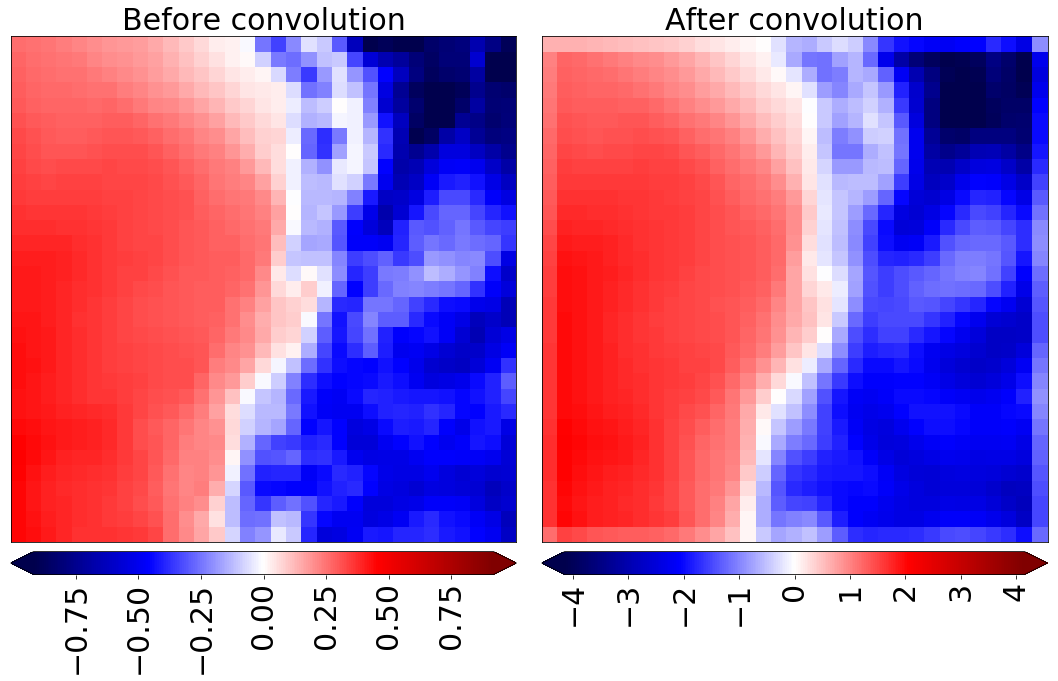

In [38]:
num_kernel_rows = 3
num_kernel_columns = 3

predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
temperature_index = predictor_names.index(TEMPERATURE_NAME)
temperature_matrix = predictor_matrix[8, ..., temperature_index]

_, axes_object_matrix = create_paneled_figure(num_rows=1, num_columns=2)

plot_feature_map(
    feature_matrix=temperature_matrix, axes_object=axes_object_matrix[0, 0]
)
axes_object_matrix[0, 0].set_title('Before convolution')

feature_matrix = numpy.expand_dims(temperature_matrix, axis=-1)
kernel_matrix = numpy.random.uniform(
    low=0., high=1., size=(num_kernel_rows, num_kernel_columns, 1, 1)
)

feature_matrix = do_2d_convolution(
    feature_matrix=feature_matrix, kernel_matrix=kernel_matrix,
    pad_edges=True, stride_length_px=1)
feature_matrix = feature_matrix[0, ..., 0]

print('Shape of output map = {0:s}'.format(
    str(feature_matrix.shape)
))

plot_feature_map(
    feature_matrix=feature_matrix, axes_object=axes_object_matrix[0, 1]
)
axes_object_matrix[0, 1].set_title('After convolution')

# Example 2 of random convolution

The next cell does stand-alone convolution with the same options but no edge-padding.  As shown above, edge-padding often leaves artifacts around the edge, making it undesirable.

With no edge-padding, if the input map is $M \times N$ and the kernel is $J \times K$, the output map is $(M - J + 1) \times (N - K + 1)$.  Thus, the larger the kernel, the more spatial dimensions shrink.

Shape of output map = (31, 31)


/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:340: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not (numpy.issubdtype(input_variable.dtype, int) or numpy.issubdtype(
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:341: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  input_variable.dtype, float)):


Text(0.5,1,'After convolution')

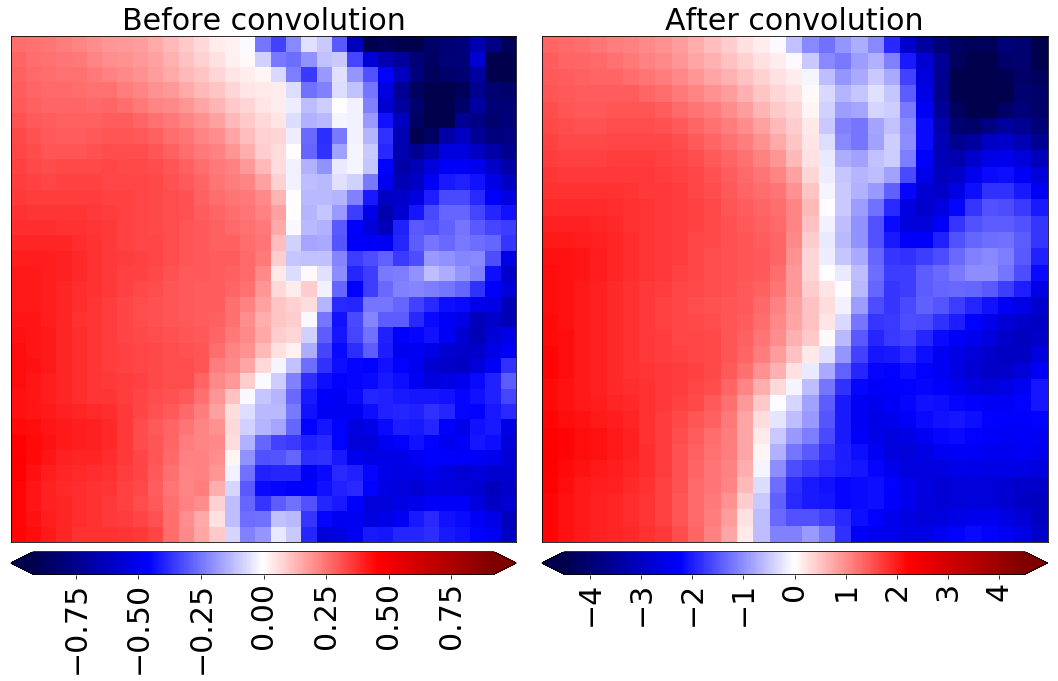

In [39]:
num_kernel_rows = 3
num_kernel_columns = 3

predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
temperature_index = predictor_names.index(TEMPERATURE_NAME)
temperature_matrix = predictor_matrix[8, ..., temperature_index]

_, axes_object_matrix = create_paneled_figure(num_rows=1, num_columns=2)

plot_feature_map(
    feature_matrix=temperature_matrix, axes_object=axes_object_matrix[0, 0]
)
axes_object_matrix[0, 0].set_title('Before convolution')

feature_matrix = numpy.expand_dims(temperature_matrix, axis=-1)
kernel_matrix = numpy.random.uniform(
    low=0., high=1., size=(num_kernel_rows, num_kernel_columns, 1, 1)
)

feature_matrix = do_2d_convolution(
    feature_matrix=feature_matrix, kernel_matrix=kernel_matrix,
    pad_edges=False, stride_length_px=1)
feature_matrix = feature_matrix[0, ..., 0]

print('Shape of output map = {0:s}'.format(
    str(feature_matrix.shape)
))

plot_feature_map(
    feature_matrix=feature_matrix, axes_object=axes_object_matrix[0, 1]
)
axes_object_matrix[0, 1].set_title('After convolution')

# Example 3 of random convolution

The next cell does stand-alone convolution with the following options:

 - One input channel, one output channel
 - Random kernel weights
 - Stride length of 2
 - No edge-padding

For strided convolution **with** edge-padding, if the input map is $M \times N$ and stride length is $L$, the output map is $\left\lfloor \frac{M}{L} \right\rfloor \times \left\lfloor \frac{N}{L} \right\rfloor$, where $\left\lfloor \textrm{ } \right\rfloor$ is the floor function.

For strided convolution **without** edge-padding, if the input map is $M \times N$, kernel is $J \times K$, and stride length is $L$, the output map is $\left\lfloor \frac{M - J + 1}{L} \right\rfloor \times \left\lfloor \frac{N - K + 1}{L} \right\rfloor$.

Shape of output map = (16, 16)


/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:340: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not (numpy.issubdtype(input_variable.dtype, int) or numpy.issubdtype(
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:341: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  input_variable.dtype, float)):


Text(0.5,1,'After convolution')

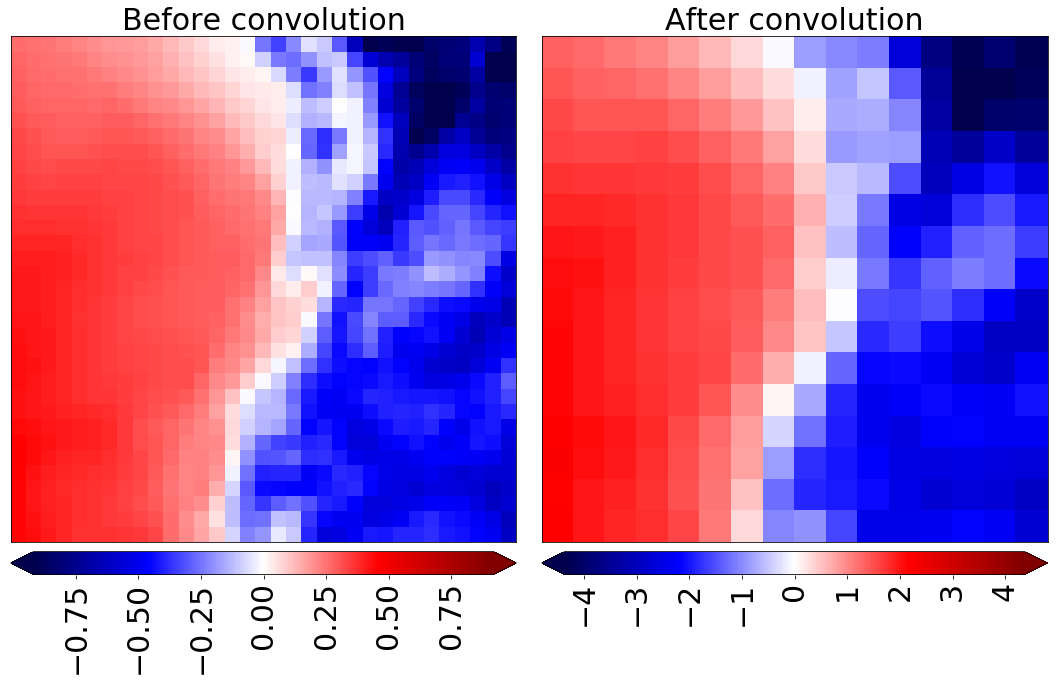

In [40]:
num_kernel_rows = 3
num_kernel_columns = 3

predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
temperature_index = predictor_names.index(TEMPERATURE_NAME)
temperature_matrix = predictor_matrix[8, ..., temperature_index]

_, axes_object_matrix = create_paneled_figure(num_rows=1, num_columns=2)

plot_feature_map(
    feature_matrix=temperature_matrix, axes_object=axes_object_matrix[0, 0]
)
axes_object_matrix[0, 0].set_title('Before convolution')

feature_matrix = numpy.expand_dims(temperature_matrix, axis=-1)
kernel_matrix = numpy.random.uniform(
    low=0., high=1., size=(num_kernel_rows, num_kernel_columns, 1, 1)
)

feature_matrix = do_2d_convolution(
    feature_matrix=feature_matrix, kernel_matrix=kernel_matrix,
    pad_edges=False, stride_length_px=2)
feature_matrix = feature_matrix[0, ..., 0]

print('Shape of output map = {0:s}'.format(
    str(feature_matrix.shape)
))

plot_feature_map(
    feature_matrix=feature_matrix, axes_object=axes_object_matrix[0, 1]
)
axes_object_matrix[0, 1].set_title('After convolution')

# Example 1 of edge detection

The next cell does stand-alone convolution with the following options:

 - One input channel, one output channel
 - Stride length of 1
 - No edge-padding
 - Preset kernel

The preset kernel (`EDGE_DETECTOR_MATRIX1`) is known to be effective for edge detection and has been used in image-processing for decades (since before deep learning).  We expect the output map to "light up" (have large absolute values) where the input map has large gradients, which are often caused by a front.

Shape of output map = (31, 31)


/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:340: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not (numpy.issubdtype(input_variable.dtype, int) or numpy.issubdtype(
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:341: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  input_variable.dtype, float)):


Text(0.5,1,'After convolution')

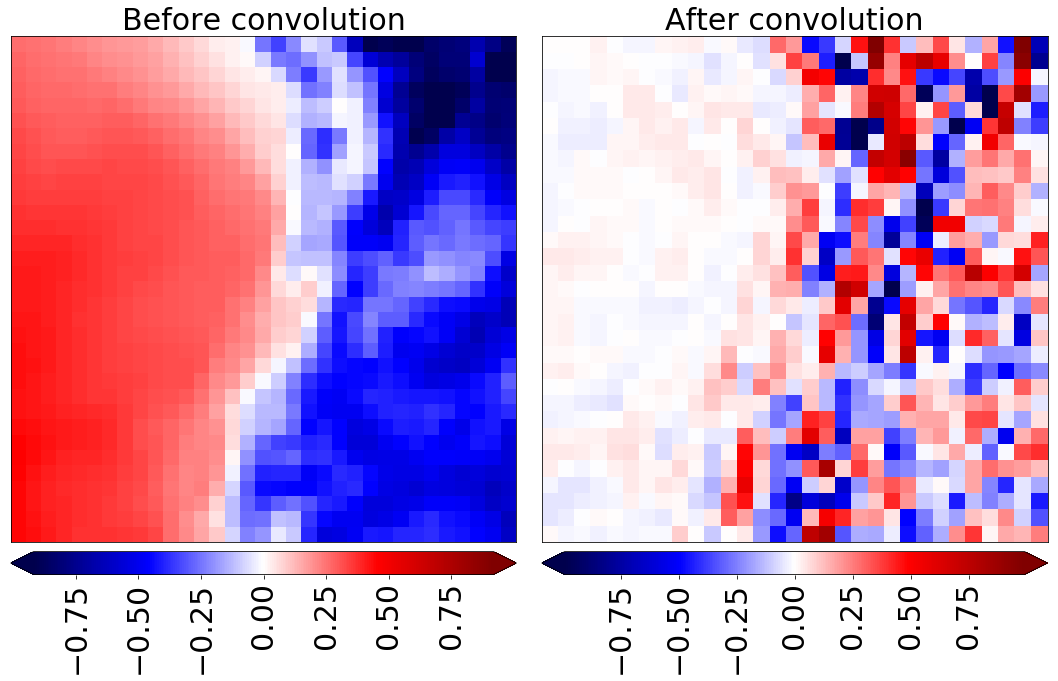

In [42]:
predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
temperature_index = predictor_names.index(TEMPERATURE_NAME)
temperature_matrix = predictor_matrix[8, ..., temperature_index]

_, axes_object_matrix = create_paneled_figure(num_rows=1, num_columns=2)

plot_feature_map(
    feature_matrix=temperature_matrix, axes_object=axes_object_matrix[0, 0]
)
axes_object_matrix[0, 0].set_title('Before convolution')

feature_matrix = numpy.expand_dims(temperature_matrix, axis=-1)
kernel_matrix = numpy.expand_dims(EDGE_DETECTOR_MATRIX1, axis=-1)
kernel_matrix = numpy.expand_dims(kernel_matrix, axis=-1)

feature_matrix = do_2d_convolution(
    feature_matrix=feature_matrix, kernel_matrix=kernel_matrix,
    pad_edges=False, stride_length_px=1)
feature_matrix = feature_matrix[0, ..., 0]

print('Shape of output map = {0:s}'.format(
    str(feature_matrix.shape)
))

plot_feature_map(
    feature_matrix=feature_matrix, axes_object=axes_object_matrix[0, 1]
)
axes_object_matrix[0, 1].set_title('After convolution')

# Example 2 of edge detection

Same as Example 1 but with a different preset kernel (`EDGE_DETECTOR_MATRIX2`), which has also been used in image-processing since before deep learning.

Shape of output map = (31, 31)


/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:340: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not (numpy.issubdtype(input_variable.dtype, int) or numpy.issubdtype(
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:341: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  input_variable.dtype, float)):


Text(0.5,1,'After convolution')

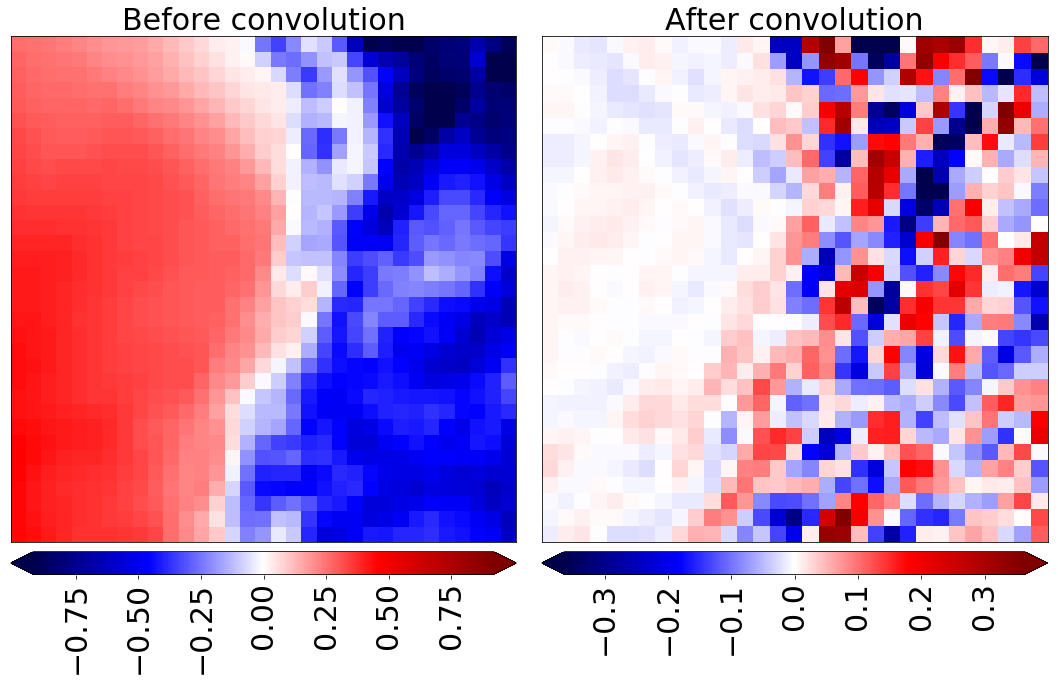

In [43]:
predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
temperature_index = predictor_names.index(TEMPERATURE_NAME)
temperature_matrix = predictor_matrix[8, ..., temperature_index]

_, axes_object_matrix = create_paneled_figure(num_rows=1, num_columns=2)

plot_feature_map(
    feature_matrix=temperature_matrix, axes_object=axes_object_matrix[0, 0]
)
axes_object_matrix[0, 0].set_title('Before convolution')

feature_matrix = numpy.expand_dims(temperature_matrix, axis=-1)
kernel_matrix = numpy.expand_dims(EDGE_DETECTOR_MATRIX2, axis=-1)
kernel_matrix = numpy.expand_dims(kernel_matrix, axis=-1)

feature_matrix = do_2d_convolution(
    feature_matrix=feature_matrix, kernel_matrix=kernel_matrix,
    pad_edges=False, stride_length_px=1)
feature_matrix = feature_matrix[0, ..., 0]

print('Shape of output map = {0:s}'.format(
    str(feature_matrix.shape)
))

plot_feature_map(
    feature_matrix=feature_matrix, axes_object=axes_object_matrix[0, 1]
)
axes_object_matrix[0, 1].set_title('After convolution')

# Example 3 of edge detection

Same as Examples 1 and 2 but with a different preset kernel (`EDGE_DETECTOR_MATRIX3`).

Shape of output map = (31, 31)


/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:340: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not (numpy.issubdtype(input_variable.dtype, int) or numpy.issubdtype(
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:341: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  input_variable.dtype, float)):


Text(0.5,1,'After convolution')

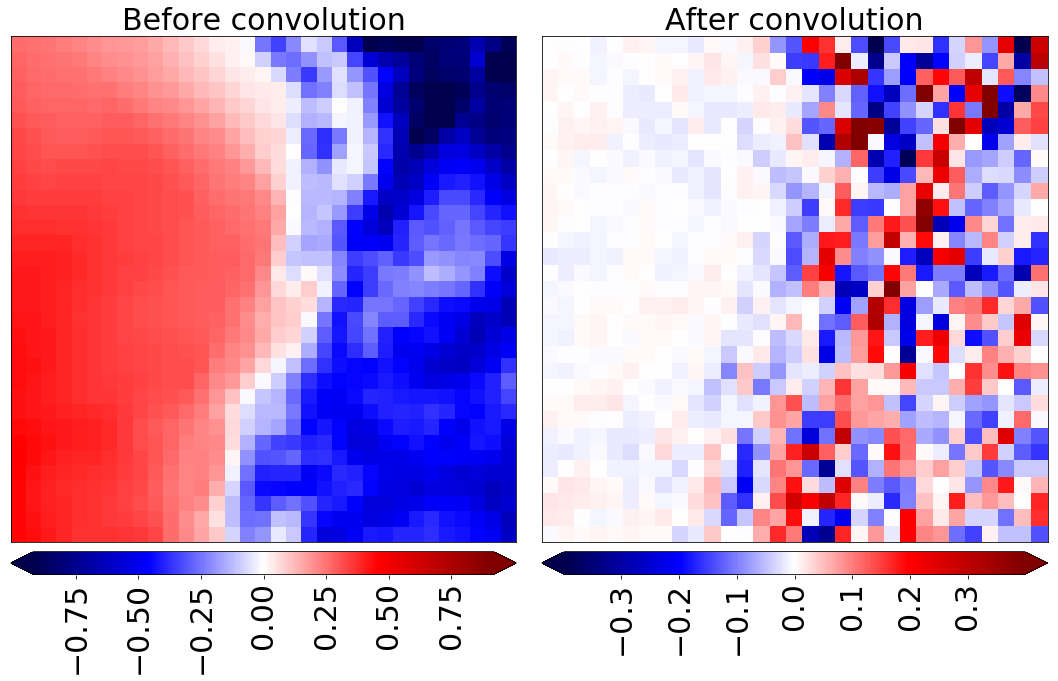

In [44]:
predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
temperature_index = predictor_names.index(TEMPERATURE_NAME)
temperature_matrix = predictor_matrix[8, ..., temperature_index]

_, axes_object_matrix = create_paneled_figure(num_rows=1, num_columns=2)

plot_feature_map(
    feature_matrix=temperature_matrix, axes_object=axes_object_matrix[0, 0]
)
axes_object_matrix[0, 0].set_title('Before convolution')

feature_matrix = numpy.expand_dims(temperature_matrix, axis=-1)
kernel_matrix = numpy.expand_dims(EDGE_DETECTOR_MATRIX3, axis=-1)
kernel_matrix = numpy.expand_dims(kernel_matrix, axis=-1)

feature_matrix = do_2d_convolution(
    feature_matrix=feature_matrix, kernel_matrix=kernel_matrix,
    pad_edges=False, stride_length_px=1)
feature_matrix = feature_matrix[0, ..., 0]

print('Shape of output map = {0:s}'.format(
    str(feature_matrix.shape)
))

plot_feature_map(
    feature_matrix=feature_matrix, axes_object=axes_object_matrix[0, 1]
)
axes_object_matrix[0, 1].set_title('After convolution')

# Multi-channel Convolution

The next cell does multi-channel convolution with 3 input channels and 3 output channels.  The input channels are as follows:

 - Surface temperature
 - Surface $u$-wind
 - Surface $v$-wind

The first output channel is produced by applying `EDGE_DETECTOR_MATRIX1` to all 3 input channels.  Likewise, the second and third output channels are produced by applying `EDGE_DETECTOR_MATRIX2` and `EDGE_DETECTOR_MATRIX3`, respectively, to all 3 input channels.

The animation below shows what multi-channel convolution looks like on a smaller grid.

<img src="conv_animation_multichannel.gif" alt="Animated schematic for multi-channel convolution" width="750" />

/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:340: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not (numpy.issubdtype(input_variable.dtype, int) or numpy.issubdtype(
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:341: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  input_variable.dtype, float)):
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:251: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it wi

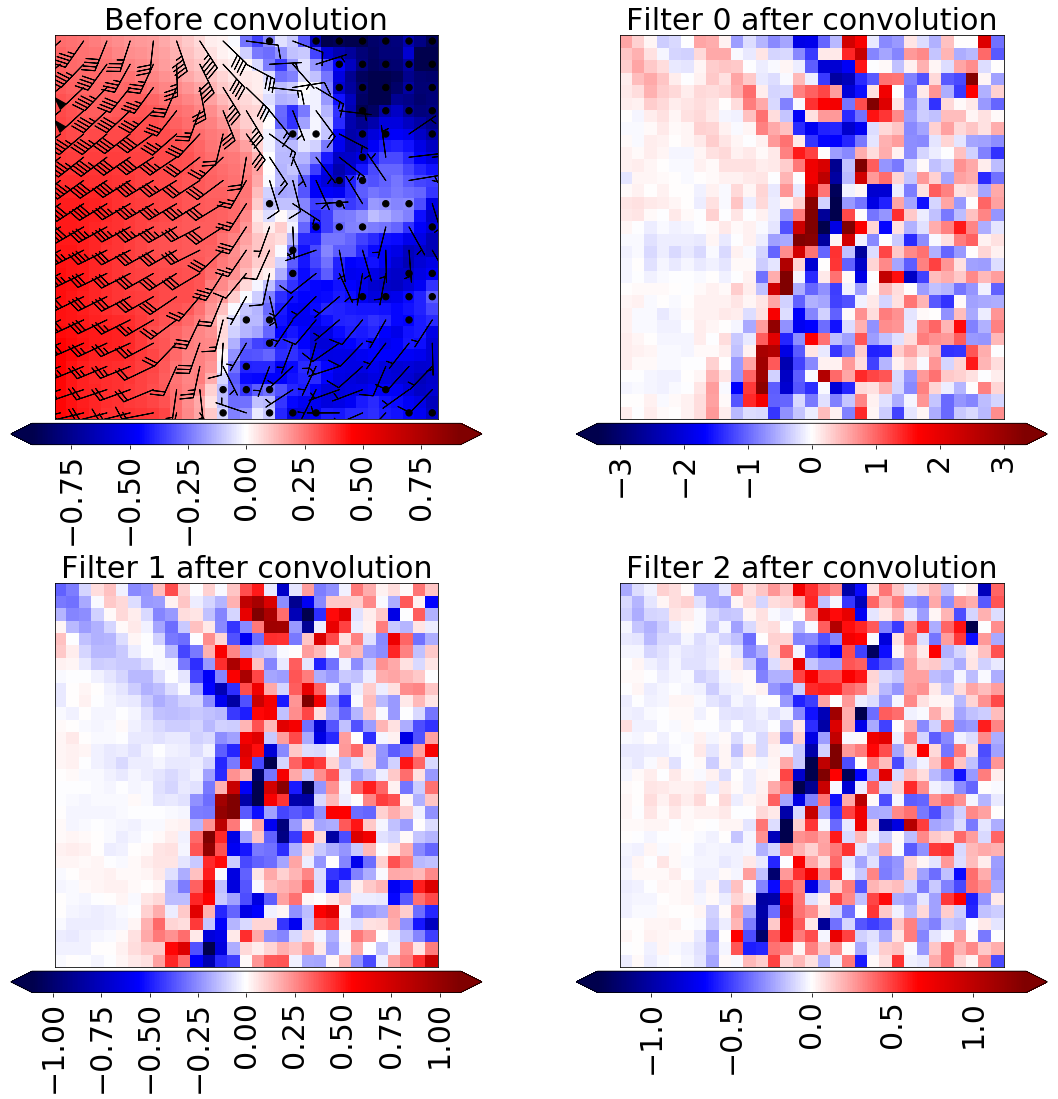

In [46]:
temperature_matrix = predictor_matrix[
    8, ..., predictor_names.index(TEMPERATURE_NAME)
]
u_wind_matrix = predictor_matrix[
    8, ..., predictor_names.index(U_WIND_GRID_RELATIVE_NAME)
]
v_wind_matrix = predictor_matrix[
    8, ..., predictor_names.index(V_WIND_GRID_RELATIVE_NAME)
]

_, axes_object_matrix = create_paneled_figure(
    num_rows=2, num_columns=2,
    horizontal_spacing=0.2, vertical_spacing=0.2)

plot_feature_map(
    feature_matrix=temperature_matrix, axes_object=axes_object_matrix[0, 0]
)
plot_wind_barbs(
    u_wind_matrix=u_wind_matrix, v_wind_matrix=v_wind_matrix,
    axes_object=axes_object_matrix[0, 0]
)
axes_object_matrix[0, 0].set_title('Before convolution')

kernel_matrix_to_channel0 = numpy.repeat(
    a=numpy.expand_dims(EDGE_DETECTOR_MATRIX1, axis=-1), repeats=3, axis=-1
)
kernel_matrix_to_channel1 = numpy.repeat(
    a=numpy.expand_dims(EDGE_DETECTOR_MATRIX2, axis=-1), repeats=3, axis=-1
)
kernel_matrix_to_channel2 = numpy.repeat(
    a=numpy.expand_dims(EDGE_DETECTOR_MATRIX3, axis=-1), repeats=3, axis=-1
)
kernel_matrix = numpy.stack((
    kernel_matrix_to_channel0, kernel_matrix_to_channel1,
    kernel_matrix_to_channel2
), axis=-1)

feature_matrix = numpy.stack(
    (temperature_matrix, u_wind_matrix, v_wind_matrix), axis=-1
)
feature_matrix = do_2d_convolution(
    feature_matrix=feature_matrix, kernel_matrix=kernel_matrix,
    pad_edges=False, stride_length_px=1)

feature_matrix = feature_matrix[0, ...]
num_output_channels = feature_matrix.shape[-1]

for k in range(num_output_channels):
    this_axes_object = numpy.ravel(axes_object_matrix)[k + 1]
    plot_feature_map(
        feature_matrix=feature_matrix[..., k], axes_object=this_axes_object
    )

    this_axes_object.set_title('Filter {0:d} after convolution'.format(k))

# Multi-channel Convolution (continued)

The figure below shows feature maps produced by the pre-trained CNN (which does multi-channel convolution over 8 input variables).

<img src="cnn_flow_chart.jpg" alt="Flow chart for pre-trained CNN" width="1000" />

# Stand-alone Activation

Each convolution or dense layer is followed by a non-linear activation function.  This is crucial, because convolution and dense layers perform linear transformations and a series of linear transformations is still linear.  Thus, without non-linear activation the CNN would learn only linear relationships.  Most real-world problems (especially in meteorology) are non-linear.

The following method performs stand-alone activation (outside of a CNN), using one of six activation functions.  The available activations are sigmoid, tanh (hyperbolic tangent), ReLU (rectified linear unit), leaky ReLU, eLU, and SeLU.  The last three are generalizations of ReLU.  All six activations are visualized in the next few cells.  The activation function is applied independently to each value.  For example, if the input is a 33 $\times$ 33 grid with 36 feature maps, the activation function is applied independently to all 33 $\times$ 33 $\times$ 36 = 39 204 values.  In other words, the activation function knows nothing about the structure of the input.

In [47]:
def do_activation(input_values, function_name, alpha_parameter=0.2):
    """Runs input array through activation function.

    :param input_values: Input numpy array.
    :param function_name: Name of activation function (must be accepted by
        `_check_activation_function`).
    :param alpha_parameter: Slope (used only for eLU and leaky ReLU functions).
    :return: output_values: Output numpy array (after activation).  Same
        dimensions.
    """

    _check_activation_function(function_name)
    input_object = K.placeholder()

    if function_name == ELU_FUNCTION_NAME:
        function_object = K.function(
            [input_object],
            [keras.layers.ELU(alpha=alpha_parameter)(input_object)]
        )
    elif function_name == LEAKY_RELU_FUNCTION_NAME:
        function_object = K.function(
            [input_object],
            [keras.layers.LeakyReLU(alpha=alpha_parameter)(input_object)]
        )
    else:
        function_object = K.function(
            [input_object],
            [keras.layers.Activation(function_name)(input_object)]
        )

    return function_object([input_values])[0]

# Standard Activation Functions

The next cell plots the three "standard" activation functions.  Tanh and sigmoid have been used in machine learning for a long, and although ReLU (Nair and Hinton 2010) is relatively new, it has become very common.

This plot is adapted from the [Swirlnet tutorial](https://github.com/djgagne/swirlnet/blob/master/notebooks/deep_swirl_tutorial.ipynb), which demonstrates the use of deep learning to predict mesocyclones (the precursors to most tornadoes) in simulated thunderstorms.  Swirlnet is another great resource for learning about deep learning and its applications to meteorology.

Nair, V., and G. Hinton, 2010: "Rectified linear units improve restricted Boltzmann machines." *International Conference on Machine Learning*, Haifa, Israel, International Machine Learning Society. [[link]](https://www.cs.toronto.edu/~hinton/absps/reluICML.pdf)

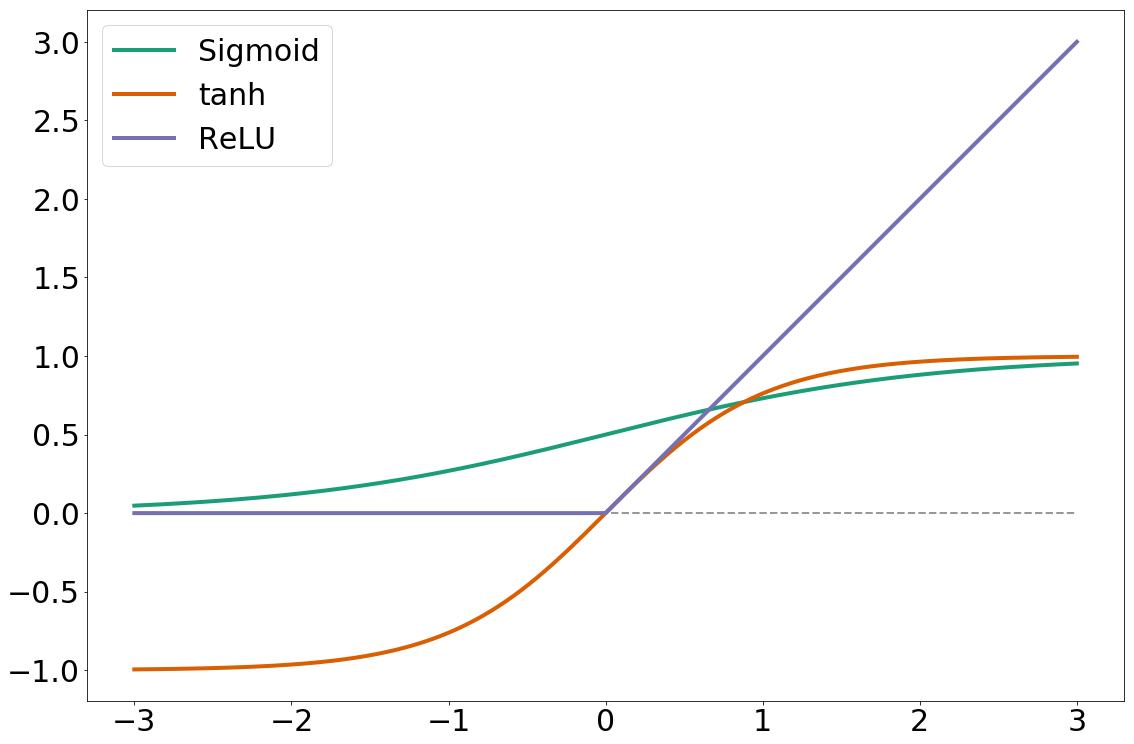

In [48]:
function_names_keras = [
    SIGMOID_FUNCTION_NAME, TANH_FUNCTION_NAME, RELU_FUNCTION_NAME
]
function_names_fancy = ['Sigmoid', 'tanh', 'ReLU']
input_values = numpy.linspace(-3, 3, num=1000, dtype=float)

colour_by_function = numpy.array([
    [27, 158, 119],
    [217, 95, 2],
    [117, 112, 179]
])
colour_by_function = colour_by_function.astype(float) / 255

_, axes_object_matrix = create_paneled_figure(num_rows=1, num_columns=1)
axes_object = axes_object_matrix[0, 0]

axes_object.plot(
    input_values, numpy.zeros(input_values.shape),
    linewidth=2, linestyle='dashed', color=numpy.full(3, 152. / 255)
)

for i in range(len(function_names_keras)):
    these_output_values = do_activation(
        input_values=input_values, function_name=function_names_keras[i]
    )

    axes_object.plot(
        input_values, these_output_values, linewidth=4, linestyle='solid',
        color=colour_by_function[i, :], label=function_names_fancy[i]
    )

axes_object.legend(loc='upper left')

# Variants of ReLU

The next cell plots the three variants of ReLU: leaky ReLU (Maas *et al.* 2013), eLU (exponential linear unit; Clevert *et al.* 2016), and SeLU (scaled exponential linear unit; Klambauer *et al.* 2017).  The benefit of these functions over plain ReLU is that they preserve some information from negative inputs, where ReLU transforms all negative inputs to zero.  This can lead to "dead neurons," whose weights stop being updated at some point in the training process.

Clevert, D.-A., T. Unterthiner, and S. Hochreiter, 2016: "Fast and accurate deep network learning by exponential linear units (ELUs)." *arXiv e-prints*, **1511 (07289v5)**. [[link]](https://arxiv.org/abs/1511.07289)

Klambauer, G., T. Unterthiner, A. Mayr, and S. Hochreiter, 2017: "Self-normalizing neural networks." *arXiv e-prints*, **1706 (02515v5)**. [[link]](https://arxiv.org/abs/1706.02515)

Maas, A.L., A.Y. Hannun, and A.Y. Ng: "Rectifier nonlinearities improve neural network acoustic models." *International Conference on Machine Learning*, Atlanta, GA, International Machine Learning Society. [[link]](https://ai.stanford.edu/~amaas/papers/relu_hybrid_icml2013_final.pdf)

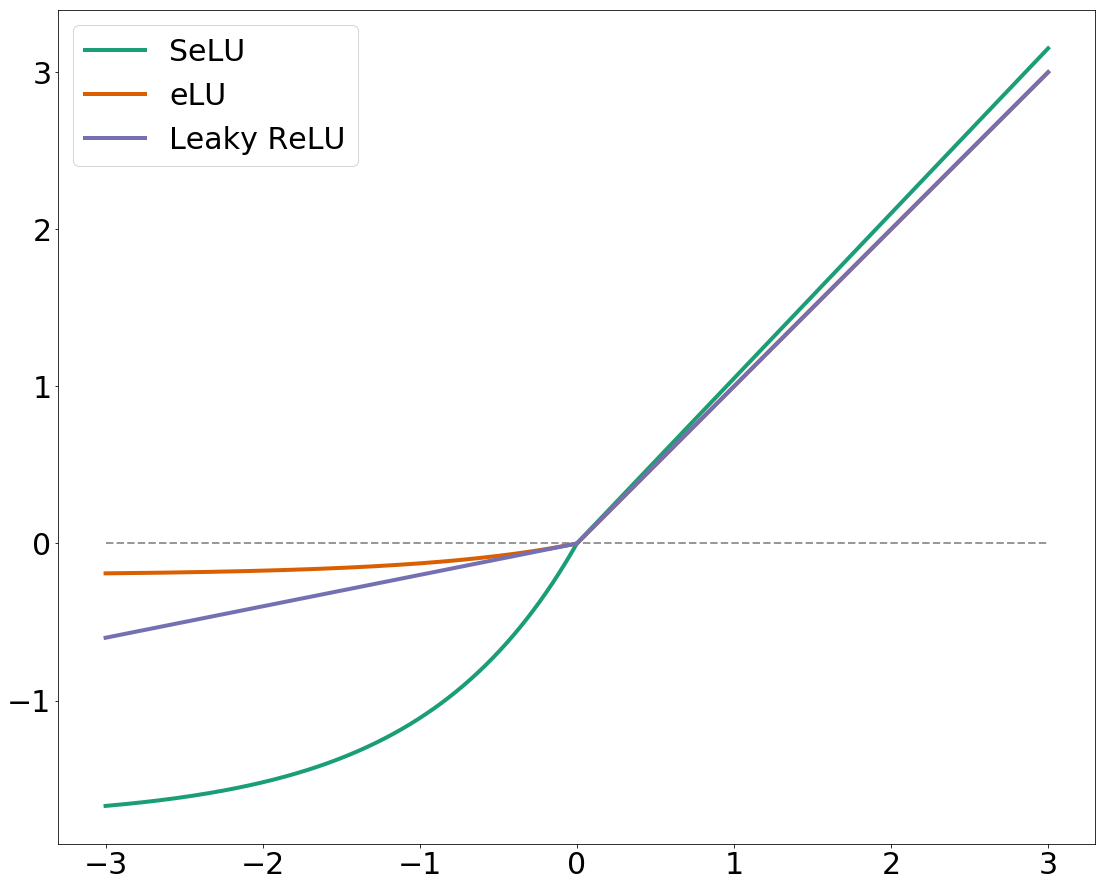

In [49]:
function_names_keras = [
    SELU_FUNCTION_NAME, ELU_FUNCTION_NAME, LEAKY_RELU_FUNCTION_NAME
]
function_names_fancy = ['SeLU', 'eLU', 'Leaky ReLU']
input_values = numpy.linspace(-3, 3, num=1000, dtype=float)

colour_by_function = numpy.array([
    [27, 158, 119],
    [217, 95, 2],
    [117, 112, 179]
])
colour_by_function = colour_by_function.astype(float) / 255

_, axes_object_matrix = create_paneled_figure(num_rows=1, num_columns=1)
axes_object = axes_object_matrix[0, 0]

axes_object.plot(
    input_values, numpy.zeros(input_values.shape),
    linewidth=2, linestyle='dashed', color=numpy.full(3, 152. / 255)
)

for i in range(len(function_names_keras)):
    these_output_values = do_activation(
        input_values=input_values, function_name=function_names_keras[i]
    )

    axes_object.plot(
        input_values, these_output_values, linewidth=4, linestyle='solid',
        color=colour_by_function[i, :], label=function_names_fancy[i]
    )

axes_object.legend(loc='upper left')

# Stand-alone Pooling

The following method performs stand-alone 2-D pooling.

In [50]:
def do_2d_pooling(
        feature_matrix, stride_length_px=2, pooling_type_string='max'):
    """Runs 2-D feature maps through pooling filter.

    M = number of rows before pooling
    N = number of columns after pooling
    m = number of rows after pooling
    n = number of columns after pooling

    :param feature_matrix: Input feature maps (numpy array).  Dimensions must be
        M x N x C_i or 1 x M x N x C_i.
    :param stride_length_px: Stride length (pixels).  The pooling window will
        move by this many rows or columns at a time as it slides over each input
        feature map.
    :param pooling_type_string: Pooling type (must be accepted by
        `_check_pooling_type`).
    :return: feature_matrix: Output feature maps (numpy array).  Dimensions will
        be 1 x m x n x C.
    """

    error_checking.assert_is_numpy_array_without_nan(feature_matrix)
    error_checking.assert_is_integer(stride_length_px)
    error_checking.assert_is_geq(stride_length_px, 2)
    _check_pooling_type(pooling_type_string)

    if len(feature_matrix.shape) == 3:
        feature_matrix = numpy.expand_dims(feature_matrix, axis=0)

    error_checking.assert_is_numpy_array(feature_matrix, num_dimensions=4)

    feature_tensor = K.pool2d(
        x=K.variable(feature_matrix), pool_mode=pooling_type_string,
        pool_size=(stride_length_px, stride_length_px),
        strides=(stride_length_px, stride_length_px), padding='valid',
        data_format='channels_last'
    )

    return feature_tensor.eval(session=K.get_session())

# Pooling (continued)

Unlike convolution, pooling does not change the number of feature maps (or channels).  Thus, if the input to a pooling layer contains $C$ channels, the output will contain $C$ channels.

Pooling merely downsamples (decreases the spatial resolution of) feature maps.  Specifically, pooling with stride length $L$ decreases the resolution by a factor of $L$.  In the example shown below (for the pre-trained CNN), the input maps have 32-km resolution and all pooling layers have stride length of 2.  Thus, feature maps have 64-km resolution after first pooling, 128-km resolution after the second, and 256-km resolution after the third.  Concurrently, the grid size shrinks by a factor of 2, from 33 $\times$ 33 to 16 $\times$ 16 to 8 $\times$ 8 to 4 $\times$ 4.

The two types of pooling are max and mean.  In max (mean)-pooling, each value in the output map is a max (mean) within an $L \times L$ window of the input map.

The animation below shows what max-pooling looks like on a smaller grid.  [a] is the input map, and [b] is the output map.

<img src="pooling_animation.gif" alt="Animated schematic for max-pooling" width="750" />

# Example 1 of pooling

The next cell does max-pooling with a stride length of 2.  The input map contains surface temperature.

/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:340: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not (numpy.issubdtype(input_variable.dtype, int) or numpy.issubdtype(
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:341: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  input_variable.dtype, float)):


Text(0.5,1,'After max-pooling')

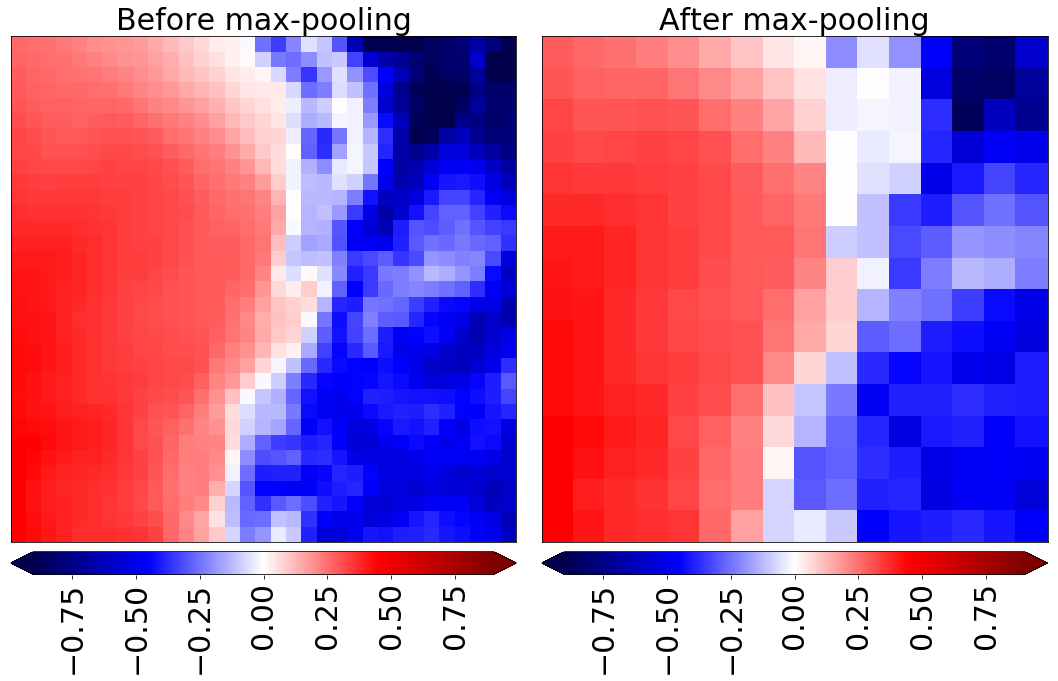

In [51]:
predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
temperature_index = predictor_names.index(TEMPERATURE_NAME)
temperature_matrix = predictor_matrix[8, ..., temperature_index]

feature_matrix = numpy.expand_dims(temperature_matrix, axis=-1)
feature_matrix = do_2d_pooling(
    feature_matrix=feature_matrix, stride_length_px=2,
    pooling_type_string=MAX_POOLING_TYPE_STRING)
feature_matrix = feature_matrix[0, ..., 0]

all_values = numpy.concatenate((
    numpy.ravel(temperature_matrix), numpy.ravel(feature_matrix)
))
max_colour_value = numpy.percentile(numpy.absolute(all_values), 99.)
min_colour_value = -1 * max_colour_value

_, axes_object_matrix = create_paneled_figure(num_rows=1, num_columns=2)

plot_feature_map(
    feature_matrix=temperature_matrix, axes_object=axes_object_matrix[0, 0],
    min_colour_value=min_colour_value, max_colour_value=max_colour_value
)
axes_object_matrix[0, 0].set_title('Before max-pooling')

plot_feature_map(
    feature_matrix=feature_matrix, axes_object=axes_object_matrix[0, 1],
    min_colour_value=min_colour_value, max_colour_value=max_colour_value
)
axes_object_matrix[0, 1].set_title('After max-pooling')

# Example 2 of pooling

The next cell does mean-pooling with a stride length of 2.

/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:340: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not (numpy.issubdtype(input_variable.dtype, int) or numpy.issubdtype(
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:341: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  input_variable.dtype, float)):


Text(0.5,1,'After mean-pooling')

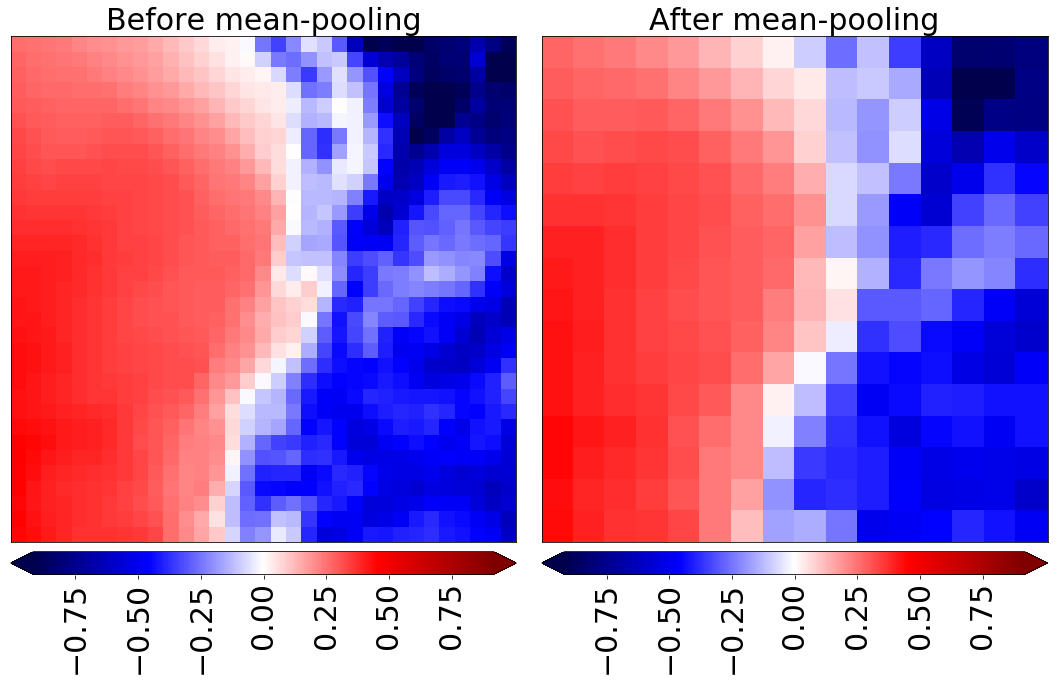

In [52]:
predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
temperature_index = predictor_names.index(TEMPERATURE_NAME)
temperature_matrix = predictor_matrix[8, ..., temperature_index]

feature_matrix = numpy.expand_dims(temperature_matrix, axis=-1)
feature_matrix = do_2d_pooling(
    feature_matrix=feature_matrix, stride_length_px=2,
    pooling_type_string=MEAN_POOLING_TYPE_STRING)
feature_matrix = feature_matrix[0, ..., 0]

all_values = numpy.concatenate((
    numpy.ravel(temperature_matrix), numpy.ravel(feature_matrix)
))
max_colour_value = numpy.percentile(numpy.absolute(all_values), 99.)
min_colour_value = -1 * max_colour_value

_, axes_object_matrix = create_paneled_figure(num_rows=1, num_columns=2)

plot_feature_map(
    feature_matrix=temperature_matrix, axes_object=axes_object_matrix[0, 0],
    min_colour_value=min_colour_value, max_colour_value=max_colour_value
)
axes_object_matrix[0, 0].set_title('Before mean-pooling')

plot_feature_map(
    feature_matrix=feature_matrix, axes_object=axes_object_matrix[0, 1],
    min_colour_value=min_colour_value, max_colour_value=max_colour_value
)
axes_object_matrix[0, 1].set_title('After mean-pooling')

# Example 3 of pooling

The next cell does max-pooling with a stride length of 4.

/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:340: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not (numpy.issubdtype(input_variable.dtype, int) or numpy.issubdtype(
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:341: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  input_variable.dtype, float)):


Text(0.5,1,'After max-pooling')

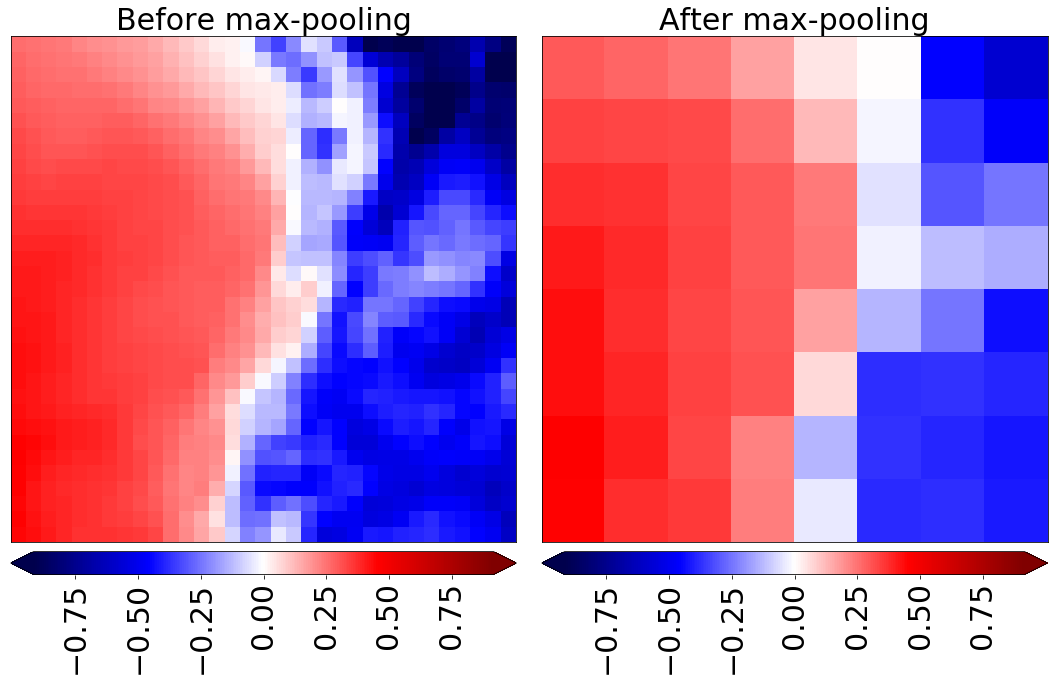

In [53]:
predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
temperature_index = predictor_names.index(TEMPERATURE_NAME)
temperature_matrix = predictor_matrix[8, ..., temperature_index]

feature_matrix = numpy.expand_dims(temperature_matrix, axis=-1)
feature_matrix = do_2d_pooling(
    feature_matrix=feature_matrix, stride_length_px=4,
    pooling_type_string=MAX_POOLING_TYPE_STRING)
feature_matrix = feature_matrix[0, ..., 0]

all_values = numpy.concatenate((
    numpy.ravel(temperature_matrix), numpy.ravel(feature_matrix)
))
max_colour_value = numpy.percentile(numpy.absolute(all_values), 99.)
min_colour_value = -1 * max_colour_value

_, axes_object_matrix = create_paneled_figure(num_rows=1, num_columns=2)

plot_feature_map(
    feature_matrix=temperature_matrix, axes_object=axes_object_matrix[0, 0],
    min_colour_value=min_colour_value, max_colour_value=max_colour_value
)
axes_object_matrix[0, 0].set_title('Before max-pooling')

plot_feature_map(
    feature_matrix=feature_matrix, axes_object=axes_object_matrix[0, 1],
    min_colour_value=min_colour_value, max_colour_value=max_colour_value
)
axes_object_matrix[0, 1].set_title('After max-pooling')

# Example 1 of convolution block

A "convolution block" consists of one or more convolution layers, each followed by a non-linear activation (and possibly batch normalization -- we will discuss this later), and one pooling layer at the end.

The next cell creates a convolution block with one convolution layer and the ReLU activation function.  Note that ReLU transforms all negative values to zero while leaving positive values untouched.

/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:340: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not (numpy.issubdtype(input_variable.dtype, int) or numpy.issubdtype(
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:341: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  input_variable.dtype, float)):


Text(0.5,1,'After max-pooling')

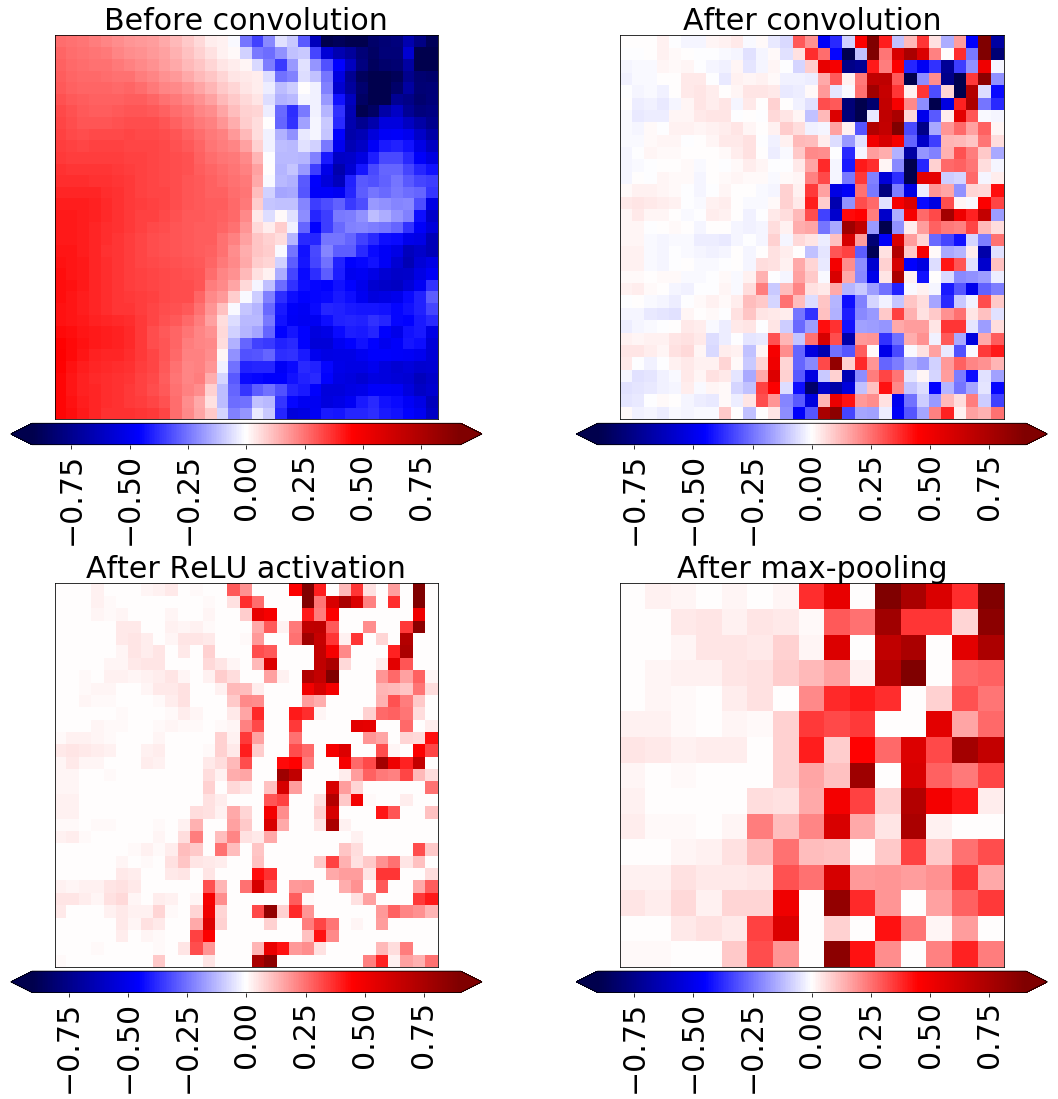

In [54]:
predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
temperature_index = predictor_names.index(TEMPERATURE_NAME)
temperature_matrix = predictor_matrix[8, ..., temperature_index]

_, axes_object_matrix = create_paneled_figure(
    num_rows=2, num_columns=2, horizontal_spacing=0.2, vertical_spacing=0.2)

plot_feature_map(
    feature_matrix=temperature_matrix, axes_object=axes_object_matrix[0, 0]
)
axes_object_matrix[0, 0].set_title('Before convolution')

kernel_matrix = numpy.expand_dims(EDGE_DETECTOR_MATRIX1, axis=-1)
kernel_matrix = numpy.expand_dims(kernel_matrix, axis=-1)

feature_matrix_after_conv = do_2d_convolution(
    feature_matrix=numpy.expand_dims(temperature_matrix, axis=-1),
    kernel_matrix=kernel_matrix, pad_edges=False, stride_length_px=1
)

feature_matrix_after_activn = do_activation(
    input_values=feature_matrix_after_conv,
    function_name=RELU_FUNCTION_NAME)

feature_matrix_after_pooling = do_2d_pooling(
    feature_matrix=feature_matrix_after_activn, stride_length_px=2,
    pooling_type_string=MAX_POOLING_TYPE_STRING)

feature_matrix_after_conv = feature_matrix_after_conv[0, ..., 0]
feature_matrix_after_activn = feature_matrix_after_activn[0, ..., 0]
feature_matrix_after_pooling = feature_matrix_after_pooling[0, ..., 0]

all_values = numpy.concatenate((
    numpy.ravel(feature_matrix_after_conv),
    numpy.ravel(feature_matrix_after_activn),
    numpy.ravel(feature_matrix_after_pooling)
))
max_colour_value = numpy.percentile(numpy.absolute(all_values), 99.)
min_colour_value = -1 * max_colour_value

plot_feature_map(
    feature_matrix=feature_matrix_after_conv,
    axes_object=axes_object_matrix[0, 1],
    min_colour_value=min_colour_value, max_colour_value=max_colour_value
)
axes_object_matrix[0, 1].set_title('After convolution')

plot_feature_map(
    feature_matrix=feature_matrix_after_activn,
    axes_object=axes_object_matrix[1, 0],
    min_colour_value=min_colour_value, max_colour_value=max_colour_value
)
axes_object_matrix[1, 0].set_title('After ReLU activation')

plot_feature_map(
    feature_matrix=feature_matrix_after_pooling,
    axes_object=axes_object_matrix[1, 1],
    min_colour_value=min_colour_value, max_colour_value=max_colour_value
)
axes_object_matrix[1, 1].set_title('After max-pooling')

# Example 2 of convolution block

The next cell creates a block with two convolution layers and the leaky-ReLU activation function.  Note that leaky ReLU preserves negative values but decreases their magnitude.

/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:340: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not (numpy.issubdtype(input_variable.dtype, int) or numpy.issubdtype(
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:341: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  input_variable.dtype, float)):


Text(0.5,1,'After max-pooling')

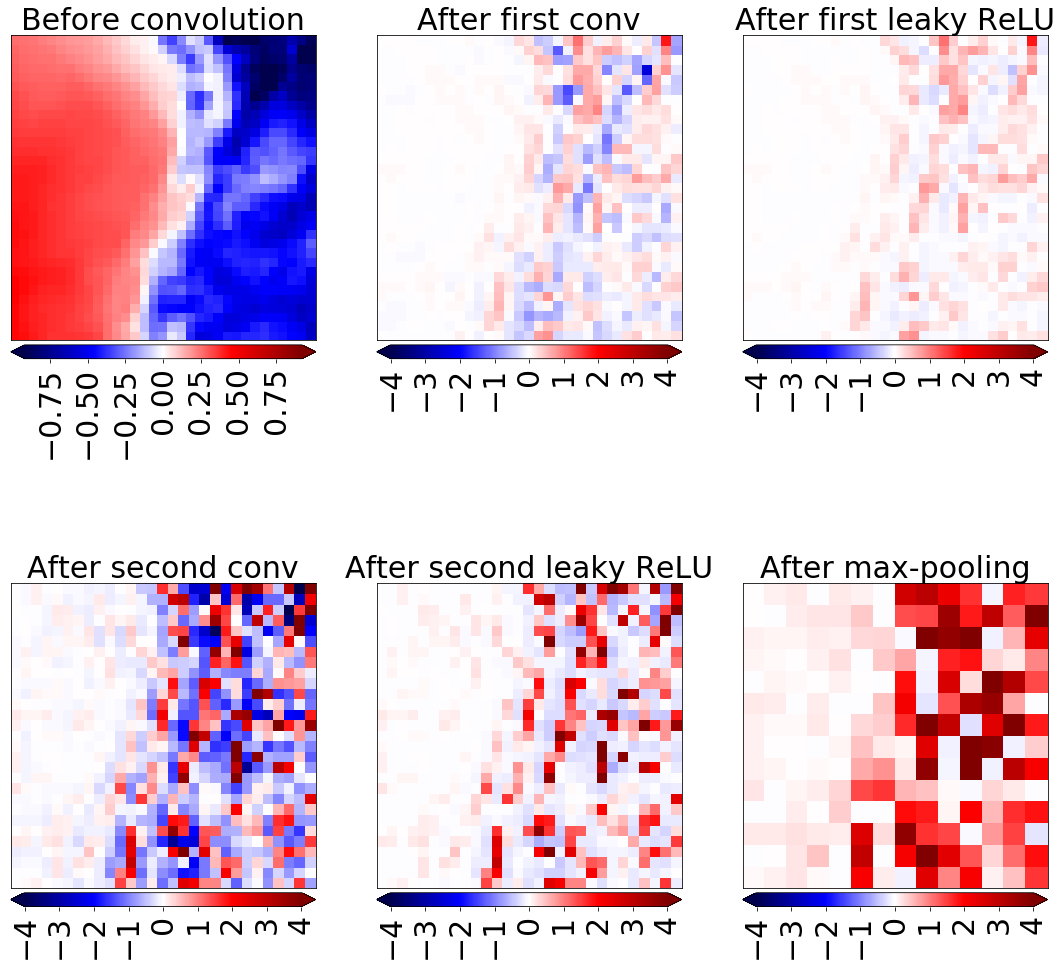

In [55]:
predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
temperature_index = predictor_names.index(TEMPERATURE_NAME)
temperature_matrix = predictor_matrix[8, ..., temperature_index]

_, axes_object_matrix = create_paneled_figure(
    num_rows=2, num_columns=3, horizontal_spacing=0.2, vertical_spacing=0.2)

plot_feature_map(
    feature_matrix=temperature_matrix, axes_object=axes_object_matrix[0, 0]
)
axes_object_matrix[0, 0].set_title('Before convolution')

kernel_matrix = numpy.expand_dims(EDGE_DETECTOR_MATRIX1, axis=-1)
kernel_matrix = numpy.expand_dims(kernel_matrix, axis=-1)

feature_matrix_after_conv1 = do_2d_convolution(
    feature_matrix=numpy.expand_dims(temperature_matrix, axis=-1),
    kernel_matrix=kernel_matrix, pad_edges=False, stride_length_px=1
)

feature_matrix_after_activn1 = do_activation(
    input_values=feature_matrix_after_conv1,
    function_name=LEAKY_RELU_FUNCTION_NAME)

feature_matrix_after_conv2 = do_2d_convolution(
    feature_matrix=feature_matrix_after_activn1,
    kernel_matrix=kernel_matrix, pad_edges=False, stride_length_px=1)

feature_matrix_after_activn2 = do_activation(
    input_values=feature_matrix_after_conv2,
    function_name=LEAKY_RELU_FUNCTION_NAME)

feature_matrix_after_pooling = do_2d_pooling(
    feature_matrix=feature_matrix_after_activn2, stride_length_px=2,
    pooling_type_string=MAX_POOLING_TYPE_STRING)

feature_matrix_after_conv1 = feature_matrix_after_conv1[0, ..., 0]
feature_matrix_after_activn1 = feature_matrix_after_activn1[0, ..., 0]
feature_matrix_after_conv2 = feature_matrix_after_conv2[0, ..., 0]
feature_matrix_after_activn2 = feature_matrix_after_activn2[0, ..., 0]
feature_matrix_after_pooling = feature_matrix_after_pooling[0, ..., 0]

all_values = numpy.concatenate((
    numpy.ravel(feature_matrix_after_conv1),
    numpy.ravel(feature_matrix_after_activn1),
    numpy.ravel(feature_matrix_after_conv2),
    numpy.ravel(feature_matrix_after_activn2),
    numpy.ravel(feature_matrix_after_pooling)
))
max_colour_value = numpy.percentile(numpy.absolute(all_values), 99.)
min_colour_value = -1 * max_colour_value

plot_feature_map(
    feature_matrix=feature_matrix_after_conv1,
    axes_object=axes_object_matrix[0, 1],
    min_colour_value=min_colour_value, max_colour_value=max_colour_value
)
axes_object_matrix[0, 1].set_title('After first conv')

plot_feature_map(
    feature_matrix=feature_matrix_after_activn1,
    axes_object=axes_object_matrix[0, 2],
    min_colour_value=min_colour_value, max_colour_value=max_colour_value
)
axes_object_matrix[0, 2].set_title('After first leaky ReLU')

plot_feature_map(
    feature_matrix=feature_matrix_after_conv2,
    axes_object=axes_object_matrix[1, 0],
    min_colour_value=min_colour_value, max_colour_value=max_colour_value
)
axes_object_matrix[1, 0].set_title('After second conv')

plot_feature_map(
    feature_matrix=feature_matrix_after_activn2,
    axes_object=axes_object_matrix[1, 1],
    min_colour_value=min_colour_value, max_colour_value=max_colour_value
)
axes_object_matrix[1, 1].set_title('After second leaky ReLU')

plot_feature_map(
    feature_matrix=feature_matrix_after_pooling,
    axes_object=axes_object_matrix[1, 2],
    min_colour_value=min_colour_value, max_colour_value=max_colour_value
)
axes_object_matrix[1, 2].set_title('After max-pooling')

# Batch Normalization

Batch normalization (Ioffe and Szegedy 2015) is normalization for features, as opposed to the raw input data (for which, recall, we use $z$-score normalization).  You can read about the benefits of batch normalization [here](https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c).

Batch normalization is typically applied after the non-linear activation.  Batch normalization is applied separately to each feature in each training batch.  For example, if layer A outputs 36 feature maps on a 33 $\times$ 33 grid, the batch normalization for layer A is applied separately to each of the 33 $\times$ 33 $\times$ 36 = 39204 values.

Specifically, batch normalization is implemented with the following equation, where $\overline{x}$ is the mean value of $x$ over the batch, $s$ is the standard deviation over the batch; $\gamma$ is the scale parameter; $\beta$ is the shift parameter; $x_i$ is the original value for the $i^{\textrm{th}}$ example; and $x'_i$ is the normalized value for the $i^{\textrm{th}}$ example.  $\gamma$ and $\beta$ are learned during training.

$x'_i = \gamma \frac{x_i - \overline{x}}{s} + \beta$

Ioffe, S., and C. Szegedy, 2015: "Batch normalization: Accelerating deep network training by reducing internal covariate shift." *International Conference on Machine Learning*, Lille, France, International Machine Learning Society. [[link]](https://arxiv.org/abs/1502.03167)

In [56]:
def do_batch_normalization(
        feature_matrix, scale_parameter=1., shift_parameter=0.):
    """Performs batch normalization on each feature in the batch.

    :param feature_matrix: E-by-M-by-N-by-C numpy array of feature values.
    :param scale_parameter: Scale parameter (beta in the equation on page 3 of
        Ioffe and Szegedy 2015).
    :param shift_parameter: Shift parameter (gamma in the equation).
    :return: feature_matrix: Feature matrix after batch norm (same dimensions).
    """

    error_checking.assert_is_numpy_array_without_nan(feature_matrix)
    error_checking.assert_is_numpy_array(feature_matrix, num_dimensions=4)
    error_checking.assert_is_greater(scale_parameter, 0.)

    # The following matrices will be M x N x C.
    stdev_matrix = numpy.std(feature_matrix, axis=0, ddof=1)
    mean_matrix = numpy.mean(feature_matrix, axis=0)

    # The following matrices will be E x M x N x C.
    stdev_matrix = numpy.expand_dims(stdev_matrix, axis=0)
    stdev_matrix = numpy.repeat(stdev_matrix, feature_matrix.shape[0], axis=0)
    mean_matrix = numpy.expand_dims(mean_matrix, axis=0)
    mean_matrix = numpy.repeat(mean_matrix, feature_matrix.shape[0], axis=0)

    return shift_parameter + scale_parameter * (
        (feature_matrix - mean_matrix) / (stdev_matrix + K.epsilon())
    )

# Example 1 of batch normalization

The next cell applies batch normalization with the default parameters ($\gamma = 1$ and $\beta = 0$), which is equivalent to $z$-score normalization.  The "batch" in this case is one training file ($\sim$512 examples), but only one example is shown.

Batch size = 560 examples


/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:340: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not (numpy.issubdtype(input_variable.dtype, int) or numpy.issubdtype(
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:341: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  input_variable.dtype, float)):


Text(0.5,1,'After batch norm')

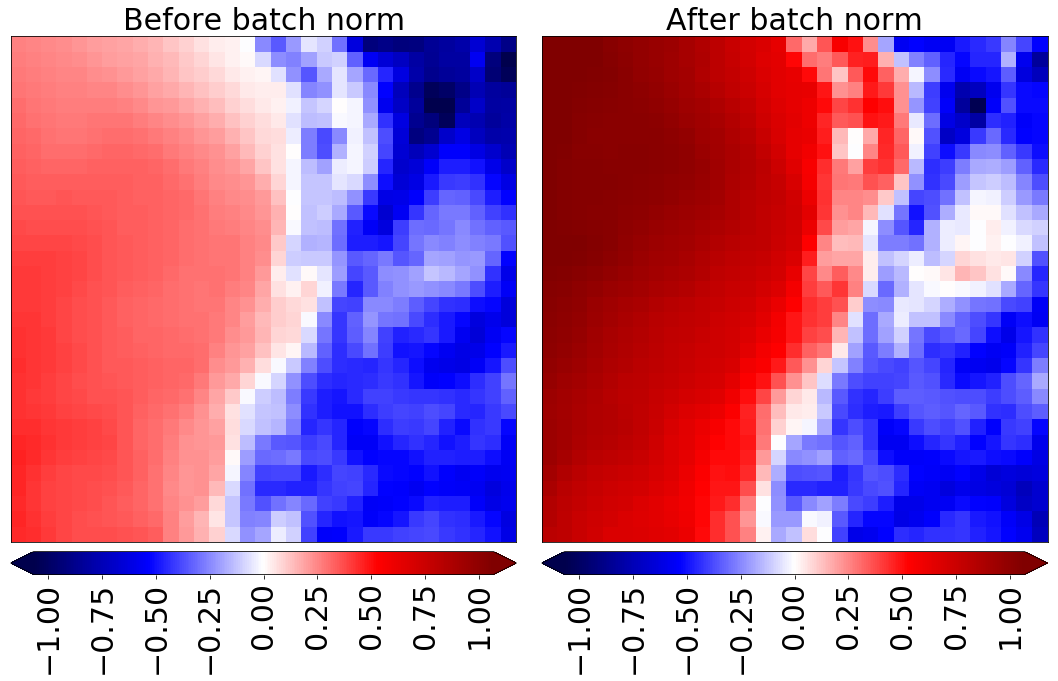

In [58]:
predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
temperature_index = predictor_names.index(TEMPERATURE_NAME)
temperature_matrix = predictor_matrix[..., temperature_index]

print('Batch size = {0:d} examples'.format(temperature_matrix.shape[0]))

feature_matrix = numpy.expand_dims(temperature_matrix, axis=-1)
feature_matrix = do_batch_normalization(
    feature_matrix=feature_matrix, scale_parameter=1., shift_parameter=0.)

temperature_matrix = temperature_matrix[8, ...]
feature_matrix = feature_matrix[8, ..., 0]

all_values = numpy.concatenate((
    numpy.ravel(temperature_matrix), numpy.ravel(feature_matrix)
))
max_colour_value = numpy.percentile(numpy.absolute(all_values), 99.)
min_colour_value = -1 * max_colour_value

_, axes_object_matrix = create_paneled_figure(num_rows=1, num_columns=2)

plot_feature_map(
    feature_matrix=temperature_matrix, axes_object=axes_object_matrix[0, 0],
    min_colour_value=min_colour_value, max_colour_value=max_colour_value
)
axes_object_matrix[0, 0].set_title('Before batch norm')

plot_feature_map(
    feature_matrix=feature_matrix, axes_object=axes_object_matrix[0, 1],
    min_colour_value=min_colour_value, max_colour_value=max_colour_value
)
axes_object_matrix[0, 1].set_title('After batch norm')

# Example 2 of batch normalization

The next cell applies batch normalization with different parameters ($\gamma = 3$ and $\beta = -2$).  The resulting distribution is not zero-centered (most values are negative).

Batch size = 560 examples


/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:340: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not (numpy.issubdtype(input_variable.dtype, int) or numpy.issubdtype(
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:341: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  input_variable.dtype, float)):


Text(0.5,1,'After batch norm')

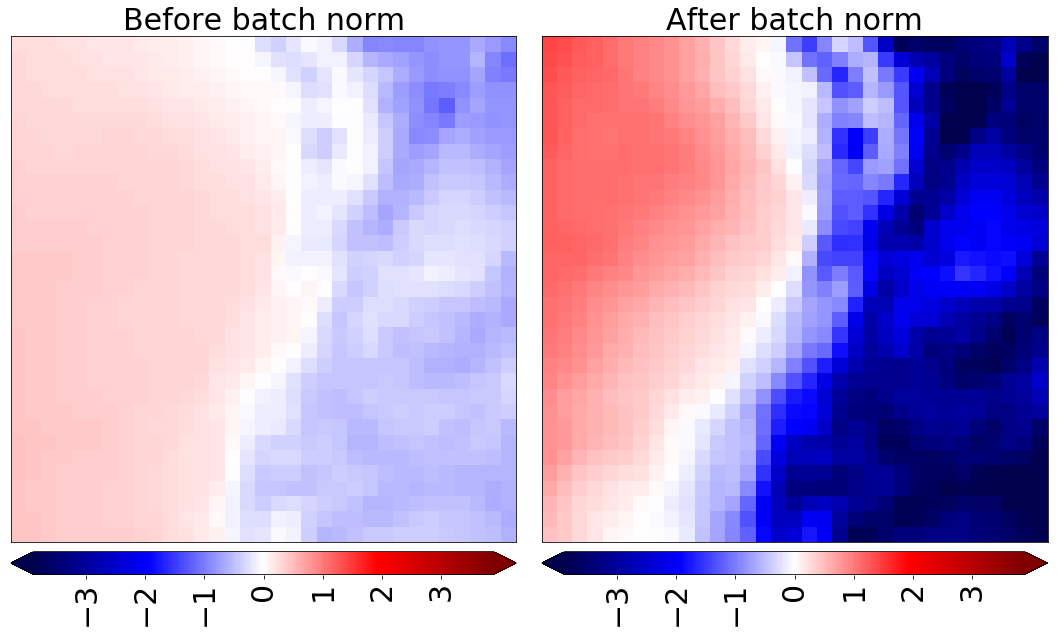

In [60]:
predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
temperature_index = predictor_names.index(TEMPERATURE_NAME)
temperature_matrix = predictor_matrix[..., temperature_index]

print('Batch size = {0:d} examples'.format(temperature_matrix.shape[0]))

feature_matrix = numpy.expand_dims(temperature_matrix, axis=-1)
feature_matrix = do_batch_normalization(
    feature_matrix=feature_matrix, scale_parameter=3., shift_parameter=-2.)

temperature_matrix = temperature_matrix[8, ...]
feature_matrix = feature_matrix[8, ..., 0]

all_values = numpy.concatenate((
    numpy.ravel(temperature_matrix), numpy.ravel(feature_matrix)
))
max_colour_value = numpy.percentile(numpy.absolute(all_values), 99.)
min_colour_value = -1 * max_colour_value

_, axes_object_matrix = create_paneled_figure(num_rows=1, num_columns=2)

plot_feature_map(
    feature_matrix=temperature_matrix, axes_object=axes_object_matrix[0, 0],
    min_colour_value=min_colour_value, max_colour_value=max_colour_value
)
axes_object_matrix[0, 0].set_title('Before batch norm')

plot_feature_map(
    feature_matrix=feature_matrix, axes_object=axes_object_matrix[0, 1],
    min_colour_value=min_colour_value, max_colour_value=max_colour_value
)
axes_object_matrix[0, 1].set_title('After batch norm')

# Example 3 of convolution block

The next cell creates a block with two convolution layers, leaky-ReLU activation, and batch normalization.

/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:340: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not (numpy.issubdtype(input_variable.dtype, int) or numpy.issubdtype(
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:341: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  input_variable.dtype, float)):


Convolving over example 1 of 100...
Convolving over example 11 of 100...
Convolving over example 21 of 100...
Convolving over example 31 of 100...
Convolving over example 41 of 100...
Convolving over example 51 of 100...
Convolving over example 61 of 100...
Convolving over example 71 of 100...
Convolving over example 81 of 100...
Convolving over example 91 of 100...
Convolving over example 1 of 100...
Convolving over example 11 of 100...
Convolving over example 21 of 100...
Convolving over example 31 of 100...
Convolving over example 41 of 100...
Convolving over example 51 of 100...
Convolving over example 61 of 100...
Convolving over example 71 of 100...
Convolving over example 81 of 100...
Convolving over example 91 of 100...


Text(0.5,1,'After max-pooling')

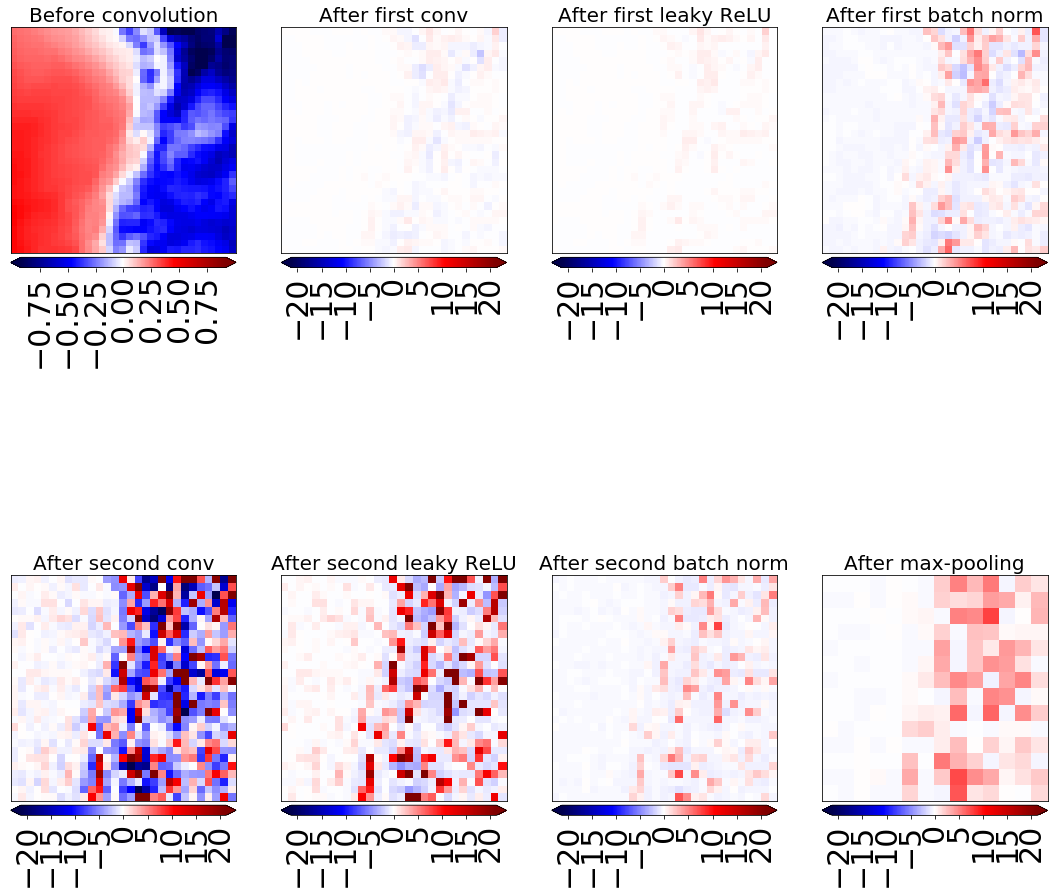

In [62]:
num_examples = 100

predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
temperature_index = predictor_names.index(TEMPERATURE_NAME)
temperature_matrix = predictor_matrix[:num_examples, ..., temperature_index]

_, axes_object_matrix = create_paneled_figure(
    num_rows=2, num_columns=4, horizontal_spacing=0.2, vertical_spacing=0.2)

plot_feature_map(
    feature_matrix=temperature_matrix[8, ...],
    axes_object=axes_object_matrix[0, 0]
)
axes_object_matrix[0, 0].set_title('Before convolution', fontsize=20)

kernel_matrix = numpy.expand_dims(EDGE_DETECTOR_MATRIX1, axis=-1)
kernel_matrix = numpy.expand_dims(kernel_matrix, axis=-1)
feature_matrix_after_conv1 = None

for i in range(num_examples):
    if numpy.mod(i, 10) == 0:
        print('Convolving over example {0:d} of {1:d}...'.format(
            i + 1, num_examples
        ))

    this_feature_matrix = do_2d_convolution(
        feature_matrix=numpy.expand_dims(temperature_matrix[[i]], axis=-1),
        kernel_matrix=kernel_matrix, pad_edges=False, stride_length_px=1
    )

    if feature_matrix_after_conv1 is None:
        dimensions = (num_examples,) + this_feature_matrix.shape[1:]
        feature_matrix_after_conv1 = numpy.full(dimensions, numpy.nan)

    feature_matrix_after_conv1[i, ...] = this_feature_matrix[0, ...]

feature_matrix_after_activn1 = do_activation(
    input_values=feature_matrix_after_conv1,
    function_name=LEAKY_RELU_FUNCTION_NAME)

feature_matrix_after_bn1 = do_batch_normalization(
    feature_matrix=feature_matrix_after_activn1,
    scale_parameter=1., shift_parameter=0.)

feature_matrix_after_conv2 = None

for i in range(num_examples):
    if numpy.mod(i, 10) == 0:
        print('Convolving over example {0:d} of {1:d}...'.format(
            i + 1, num_examples
        ))

    this_feature_matrix = do_2d_convolution(
        feature_matrix=feature_matrix_after_bn1[i, ...],
        kernel_matrix=kernel_matrix, pad_edges=False, stride_length_px=1
    )

    if feature_matrix_after_conv2 is None:
        dimensions = (num_examples,) + this_feature_matrix.shape[1:]
        feature_matrix_after_conv2 = numpy.full(dimensions, numpy.nan)

    feature_matrix_after_conv2[i, ...] = this_feature_matrix[0, ...]

feature_matrix_after_activn2 = do_activation(
    input_values=feature_matrix_after_conv2,
    function_name=LEAKY_RELU_FUNCTION_NAME)

feature_matrix_after_bn2 = do_batch_normalization(
    feature_matrix=feature_matrix_after_activn2,
    scale_parameter=1., shift_parameter=0.)

feature_matrix_after_pooling = do_2d_pooling(
    feature_matrix=feature_matrix_after_bn2, stride_length_px=2,
    pooling_type_string=MAX_POOLING_TYPE_STRING)

feature_matrix_after_conv1 = feature_matrix_after_conv1[8, ..., 0]
feature_matrix_after_activn1 = feature_matrix_after_activn1[8, ..., 0]
feature_matrix_after_bn1 = feature_matrix_after_bn1[8, ..., 0]
feature_matrix_after_conv2 = feature_matrix_after_conv2[8, ..., 0]
feature_matrix_after_activn2 = feature_matrix_after_activn2[8, ..., 0]
feature_matrix_after_bn2 = feature_matrix_after_bn2[8, ..., 0]
feature_matrix_after_pooling = feature_matrix_after_pooling[8, ..., 0]

all_values = numpy.concatenate((
    numpy.ravel(feature_matrix_after_conv1),
    numpy.ravel(feature_matrix_after_activn1),
    numpy.ravel(feature_matrix_after_bn1),
    numpy.ravel(feature_matrix_after_conv2),
    numpy.ravel(feature_matrix_after_activn2),
    numpy.ravel(feature_matrix_after_bn2),
    numpy.ravel(feature_matrix_after_pooling)
))
max_colour_value = numpy.percentile(numpy.absolute(all_values), 99.)
min_colour_value = -1 * max_colour_value

plot_feature_map(
    feature_matrix=feature_matrix_after_conv1,
    axes_object=axes_object_matrix[0, 1],
    min_colour_value=min_colour_value, max_colour_value=max_colour_value
)
axes_object_matrix[0, 1].set_title('After first conv', fontsize=20)

plot_feature_map(
    feature_matrix=feature_matrix_after_activn1,
    axes_object=axes_object_matrix[0, 2],
    min_colour_value=min_colour_value, max_colour_value=max_colour_value
)
axes_object_matrix[0, 2].set_title('After first leaky ReLU', fontsize=20)

plot_feature_map(
    feature_matrix=feature_matrix_after_bn1,
    axes_object=axes_object_matrix[0, 3],
    min_colour_value=min_colour_value, max_colour_value=max_colour_value
)
axes_object_matrix[0, 3].set_title('After first batch norm', fontsize=20)

plot_feature_map(
    feature_matrix=feature_matrix_after_conv2,
    axes_object=axes_object_matrix[1, 0],
    min_colour_value=min_colour_value, max_colour_value=max_colour_value
)
axes_object_matrix[1, 0].set_title('After second conv', fontsize=20)

plot_feature_map(
    feature_matrix=feature_matrix_after_activn2,
    axes_object=axes_object_matrix[1, 1],
    min_colour_value=min_colour_value, max_colour_value=max_colour_value
)
axes_object_matrix[1, 1].set_title('After second leaky ReLU', fontsize=20)

plot_feature_map(
    feature_matrix=feature_matrix_after_bn2,
    axes_object=axes_object_matrix[1, 2],
    min_colour_value=min_colour_value, max_colour_value=max_colour_value
)
axes_object_matrix[1, 2].set_title('After second batch norm', fontsize=20)

plot_feature_map(
    feature_matrix=feature_matrix_after_pooling,
    axes_object=axes_object_matrix[1, 3],
    min_colour_value=min_colour_value, max_colour_value=max_colour_value
)
axes_object_matrix[1, 3].set_title('After max-pooling', fontsize=20)

# Setting up a CNN

There are three steps in setting up a CNN:

 1. Define the architecture (number of layers, order of layers, number of filters in each layer, activation functions, etc.).
 2. Define the loss function.  Weights are adjusted during training to minimize the loss function.  These adjustable weights reside in the convolution and dense layers.
 3. Define the optimizer (algorithm used to adjust weights during training).  Modern optimizers tend to be very complicated, and their inner workings are beyond the scope of this notebook.  Fundamentally, most of these optimizers are fancy versions of gradient descent.

In this notebook we use the cross-entropy loss function and Adam optimizer.  Cross-entropy ($\epsilon$) is defined below.  $y_{ik}$ = 1 if the $i^{\textrm{th}}$ example belongs to the $k^{\textrm{th}}$ class and 0 otherwise; $\hat{y}_{ik}$ is the predicted probability that the $i^{\textrm{th}}$ example belongs to the $k^{\textrm{th}}$ class; $K$ is the number of classes; and $N$ is the number of examples in the batch (cross-entropy is computed once for each batch).  $K$ = 3 in our case, because the classes are NF, WF, and CF.

$\epsilon = -\frac{1}{N} \sum\limits_{i = 1}^{N} \sum\limits_{k = 1}^{K} y_{ik}\textrm{ log}_2(p_{ik})$

The next cell defines helper methods for setting up the architecture.  These are low-level, and you can safely ignore them.

In [63]:
def _get_activation_layer(function_name, alpha_parameter=0.2):
    """Creates activation layer.

    :param function_name: See doc for `do_activation`.
    :param alpha_parameter: Same.
    :return: layer_object: Instance of `keras.layers.Activation`,
        `keras.layers.ELU`, or `keras.layers.LeakyReLU`.
    """

    if function_name == ELU_FUNCTION_NAME:
        return keras.layers.ELU(alpha=alpha_parameter)

    if function_name == LEAKY_RELU_FUNCTION_NAME:
        return keras.layers.LeakyReLU(alpha=alpha_parameter)

    return keras.layers.Activation(function_name)


def _get_batch_norm_layer():
    """Creates batch-normalization layer.

    :return: layer_object: Instance of `keras.layers.BatchNormalization`.
    """

    return keras.layers.BatchNormalization(
        axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True)


def _get_2d_pooling_layer(stride_length_px, pooling_type_string):
    """Creates 2-D pooling layer.
    
    :param stride_length_px: See doc for `do_pooling`.
    :param pooling_type_string: Same.
    :return: layer_object: Instance of `keras.layers.MaxPooling2D` or
        `keras.layers.AveragePooling2D`.
    """

    if pooling_type_string == MAX_POOLING_TYPE_STRING:
        return keras.layers.MaxPooling2D(
            pool_size=(stride_length_px, stride_length_px),
            strides=(stride_length_px, stride_length_px),
            padding='valid', data_format='channels_last')

    return keras.layers.AveragePooling2D(
        pool_size=(stride_length_px, stride_length_px),
        strides=(stride_length_px, stride_length_px),
        padding='valid', data_format='channels_last')


def _get_dense_layer_dimensions(
        num_features, num_predictions, num_dense_layers):
    """Returns dimensions (num input and output features) for each dense layer.

    D = number of dense layers

    :param num_features: Number of features (inputs to the first dense layer).
    :param num_predictions: Number of predictions (outputs from the last dense
        layer).
    :param num_dense_layers: Number of dense layers.
    :return: num_inputs_by_layer: length-D numpy array with number of input
        features per dense layer.
    :return: num_outputs_by_layer: length-D numpy array with number of output
        features per dense layer.
    """

    e_folding_param = (
        float(-1 * num_dense_layers) /
        numpy.log(float(num_predictions) / num_features)
    )

    dense_layer_indices = numpy.linspace(
        0, num_dense_layers - 1, num=num_dense_layers, dtype=float)
    num_inputs_by_layer = num_features * numpy.exp(
        -1 * dense_layer_indices / e_folding_param)
    num_inputs_by_layer = numpy.round(num_inputs_by_layer).astype(int)

    num_outputs_by_layer = numpy.concatenate((
        num_inputs_by_layer[1:],
        numpy.array([num_predictions], dtype=int)
    ))

    return num_inputs_by_layer, num_outputs_by_layer

# Example 1 of CNN architecture

The next cell defines a simple architecture with 3 convolution blocks, 1 convolution layer per block, the leaky-ReLU activation function, and no batch normalization.  This CNN also does not use common "tricks" to prevent overfitting, such as $\textrm{L}_2$ regularization and dropout.

The table is printed by `model_object.summary()`.  Sadly, I haven't found Python code that creates a nice graphical flow chart.  However, [http://alexlenail.me/NN-SVG/AlexNet.html](http://alexlenail.me/NN-SVG/AlexNet.html) allows you to do so by entering just a few numbers.

In [64]:
num_grid_rows = 33
num_grid_columns = 33
num_channels = 8

# Create input layer.
input_layer_object = keras.layers.Input(
    shape=(num_grid_rows, num_grid_columns, num_channels)
)
last_layer_object = input_layer_object

# Create first conv layer.
conv_layer_object = keras.layers.Conv2D(
    filters=16, kernel_size=(3, 3), strides=(1, 1),
    padding='same', data_format='channels_last', dilation_rate=(1, 1),
    activation=None, use_bias=True
)
last_layer_object = conv_layer_object(last_layer_object)

activation_layer_object = _get_activation_layer(LEAKY_RELU_FUNCTION_NAME)
last_layer_object = activation_layer_object(last_layer_object)

# First pooling layer.
pooling_layer_object = _get_2d_pooling_layer(
    stride_length_px=2, pooling_type_string=MAX_POOLING_TYPE_STRING)
last_layer_object = pooling_layer_object(last_layer_object)

# Second conv layer.
conv_layer_object = keras.layers.Conv2D(
    filters=32, kernel_size=(3, 3), strides=(1, 1),
    padding='same', data_format='channels_last', dilation_rate=(1, 1),
    activation=None, use_bias=True
)
last_layer_object = conv_layer_object(last_layer_object)

activation_layer_object = _get_activation_layer(LEAKY_RELU_FUNCTION_NAME)
last_layer_object = activation_layer_object(last_layer_object)

# Second pooling layer.
pooling_layer_object = _get_2d_pooling_layer(
    stride_length_px=2, pooling_type_string=MAX_POOLING_TYPE_STRING)
last_layer_object = pooling_layer_object(last_layer_object)

# Third conv layer.
conv_layer_object = keras.layers.Conv2D(
    filters=64, kernel_size=(3, 3), strides=(1, 1),
    padding='same', data_format='channels_last', dilation_rate=(1, 1),
    activation=None, use_bias=True
)
last_layer_object = conv_layer_object(last_layer_object)

activation_layer_object = _get_activation_layer(LEAKY_RELU_FUNCTION_NAME)
last_layer_object = activation_layer_object(last_layer_object)

# Third pooling layer.
pooling_layer_object = _get_2d_pooling_layer(
    stride_length_px=2, pooling_type_string=MAX_POOLING_TYPE_STRING)
last_layer_object = pooling_layer_object(last_layer_object)

# Flattening layer.
dimensions = numpy.array(
    last_layer_object.get_shape().as_list()[1:], dtype=int
)
num_scalar_features = numpy.prod(dimensions)

flattening_layer_object = keras.layers.Flatten()
last_layer_object = flattening_layer_object(last_layer_object)

# Dense layers.
dense_layer_object = keras.layers.Dense(128, activation=None, use_bias=True)
last_layer_object = dense_layer_object(last_layer_object)

activation_layer_object = _get_activation_layer(LEAKY_RELU_FUNCTION_NAME)
last_layer_object = activation_layer_object(last_layer_object)

dense_layer_object = keras.layers.Dense(3, activation=None, use_bias=True)
last_layer_object = dense_layer_object(last_layer_object)

activation_layer_object = _get_activation_layer('softmax')
last_layer_object = activation_layer_object(last_layer_object)

# Put everything together.
model_object = keras.models.Model(
    inputs=input_layer_object, outputs=last_layer_object)

model_object.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adam(), metrics=LIST_OF_METRIC_FUNCTIONS)

model_object.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 33, 33, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 33, 16)        1168      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 33, 33, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 16, 16, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
__________

# Training the CNN

In Keras there are two ways to train a CNN: using the model's `fit` method or using its `fit_generator` method.  With the `fit` method all data must be loaded into memory at once; with the `fit_generator` method, only one batch needs to be in memory at once.  This is convenient when you have a large dataset (this notebook contains a small fraction of the full dataset, which is several terabytes, making `fit_generator` absolutely necessary).  The `fit_generator` method calls a generator, which you must define, which reads a new batch from disk whenever it is called.  The next cell defines a method called `example_generator`, which does exactly that.

The next cell also defines a method called `train_cnn`, whose most important arguments are `model_object` (defining the untrained model), `training_generator` (defining the generator for training data), and `validation_generator` (defining the generator for validation data).  Validation data are used to monitor performance (the loss function and other metrics) after every epoch, but they are never used to adjust the model's weights; only the training data are used for this.

In [65]:
def example_generator(
        top_input_dir_name, predictor_names, pressure_levels_mb, num_half_rows,
        num_half_columns, num_examples_per_batch):
    """Generates training examples.

    E = number of examples
    M = number of rows in grid
    N = number of columns in grid
    C = number of channels (predictors)

    :param top_input_dir_name: Name of top-level input directory.  Training
        files therein will be found by `find_many_training_files`.
    :param predictor_names: See doc for `read_examples`.
    :param pressure_levels_mb: Same.
    :param num_half_rows: Same.
    :param num_half_columns: Same.
    :param num_examples_per_batch: Number of examples per batch.
    :return: predictor_matrix: E-by-M-by-N-by-C numpy array of predictor values.
    :return: target_matrix: E-by-K numpy array of target values (all 0 or 1).
        If target_matrix[i, k] = 1, the [i]th example is in the [k]th class.
    """

    error_checking.assert_is_integer(num_examples_per_batch)
    error_checking.assert_is_geq(num_examples_per_batch, 16)

    example_file_names = find_many_training_files(
        top_training_dir_name=top_input_dir_name, first_batch_number=0,
        last_batch_number=int(1e12)
    )
    random.shuffle(example_file_names)

    num_files = len(example_file_names)
    file_index = 0
    num_examples_in_memory = 0

    batch_indices = numpy.linspace(
        0, num_examples_per_batch - 1, num=num_examples_per_batch, dtype=int)

    while True:
        predictor_matrix = None
        target_matrix = None

        while num_examples_in_memory < num_examples_per_batch:
            print('Reading data from: "{0:s}"...'.format(
                example_file_names[file_index]
            ))

            this_example_dict = read_examples(
                netcdf_file_name=example_file_names[file_index],
                metadata_only=False, predictor_names_to_keep=predictor_names,
                pressure_levels_to_keep_mb=pressure_levels_mb,
                num_half_rows_to_keep=num_half_rows,
                num_half_columns_to_keep=num_half_columns)

            file_index = file_index + 1 if file_index + 1 < num_files else 0

            this_num_examples = len(this_example_dict[VALID_TIMES_KEY])
            if this_num_examples == 0:
                continue

            if target_matrix is None or target_matrix.size == 0:
                predictor_matrix = this_example_dict[PREDICTOR_MATRIX_KEY] + 0.
                target_matrix = this_example_dict[TARGET_MATRIX_KEY] + 0
            else:
                predictor_matrix = numpy.concatenate(
                    (predictor_matrix, this_example_dict[PREDICTOR_MATRIX_KEY]),
                    axis=0
                )
                target_matrix = numpy.concatenate(
                    (target_matrix, this_example_dict[TARGET_MATRIX_KEY]),
                    axis=0
                )

            num_examples_in_memory = target_matrix.shape[0]

        numpy.random.shuffle(batch_indices)
        predictor_matrix = predictor_matrix[batch_indices, ...].astype(
            'float32')
        target_matrix = target_matrix[batch_indices, ...].astype('float64')

        num_examples_by_class = numpy.sum(target_matrix, axis=0)
        print('Number of examples in each class: {0:s}'.format(
            str(num_examples_by_class)
        ))

        num_examples_in_memory = 0
        yield (predictor_matrix, target_matrix)


def train_cnn(
        model_object, output_model_file_name, num_epochs,
        num_training_batches_per_epoch, num_validation_batches_per_epoch,
        training_generator, validation_generator):
    """Trains new CNN.

    In this context "validation" means on-the-fly validation (monitoring during
    training).

    :param model_object: Untrained CNN (instance of `keras.models.Model` or
        `keras.models.Sequential`).
    :param output_model_file_name: Path to output file (will be in HDF5 format,
        so extension should be ".h5").
    :param num_epochs: Number of training epochs.
    :param num_training_batches_per_epoch: Number of training batches per epoch.
    :param num_validation_batches_per_epoch: Number of validation batches per
        epoch.
    :param training_generator: Generator for training data (created by
        `training_generator`).
    :param validation_generator: Generator for training data (created by
        `validation_generator`).
    """

    error_checking.assert_is_integer(num_epochs)
    error_checking.assert_is_geq(num_epochs, 2)
    error_checking.assert_is_integer(num_training_batches_per_epoch)
    error_checking.assert_is_geq(num_training_batches_per_epoch, 2)
    error_checking.assert_is_integer(num_validation_batches_per_epoch)
    error_checking.assert_is_geq(num_validation_batches_per_epoch, 2)

    file_system_utils.mkdir_recursive_if_necessary(
        file_name=output_model_file_name)

    checkpoint_object = keras.callbacks.ModelCheckpoint(
        output_model_file_name, monitor='val_loss', verbose=1,
        save_best_only=True, save_weights_only=False, mode='min', period=1)

    early_stopping_object = keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=0.005, patience=6, verbose=1, mode='min')

    model_object.fit_generator(
        generator=training_generator,
        steps_per_epoch=num_training_batches_per_epoch, epochs=num_epochs,
        verbose=1, callbacks=[checkpoint_object, early_stopping_object],
        validation_data=validation_generator,
        validation_steps=num_validation_batches_per_epoch)

# Example 1 of CNN-training

Here we train the simple CNN defined above, using the following options:

 - Batch size of 1024.  Thus, each weight update is based on 1024 examples.  Downsampling in the training files ensures that on average the batch contains 512 NF, 256 WF, and 256 CF examples.
 - 32 training batches per epoch.  Thus, each epoch uses 32 768 training examples.
 - 16 validation batches per epoch.  Thus, at the end of each epoch, 16 384 validation examples are used to monitor performance (but not to adjust weights).
 - 10 epochs.  The CNN will probably not converge within 10 epochs (*i.e.*, validation loss will not reach a minimum), but we do not have time in the live tutorial for more training.  If you are working through the notebook at home, feel free to adjust this, the batch size, and anything else you want.

In [66]:
simple_model_file_name = '{0:s}/simple_cnn.h5'.format(OUTPUT_DIR_NAME)

# training_generator = example_generator(
#     top_input_dir_name=TOP_TRAINING_DIR_NAME,
#     predictor_names=PREDICTOR_NAMES_FOR_CNN,
#     pressure_levels_mb=PRESSURE_LEVELS_FOR_CNN_MB,
#     num_half_rows=16, num_half_columns=16, num_examples_per_batch=1024)
# 
# validation_generator = example_generator(
#     top_input_dir_name=TOP_VALIDATION_DIR_NAME,
#     predictor_names=PREDICTOR_NAMES_FOR_CNN,
#     pressure_levels_mb=PRESSURE_LEVELS_FOR_CNN_MB,
#     num_half_rows=16, num_half_columns=16, num_examples_per_batch=1024)

training_generator = example_generator(
    top_input_dir_name=TOP_TRAINING_DIR_NAME,
    predictor_names=PREDICTOR_NAMES_FOR_CNN,
    pressure_levels_mb=PRESSURE_LEVELS_FOR_CNN_MB,
    num_half_rows=16, num_half_columns=16, num_examples_per_batch=32)

validation_generator = example_generator(
    top_input_dir_name=TOP_VALIDATION_DIR_NAME,
    predictor_names=PREDICTOR_NAMES_FOR_CNN,
    pressure_levels_mb=PRESSURE_LEVELS_FOR_CNN_MB,
    num_half_rows=16, num_half_columns=16, num_examples_per_batch=32)

train_cnn(
    model_object=model_object,
    output_model_file_name=simple_model_file_name, num_epochs=10,
    num_training_batches_per_epoch=32, num_validation_batches_per_epoch=16,
    training_generator=training_generator,
    validation_generator=validation_generator)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/validation/batches0750000-0750999/downsized_3d_examples_batch0750288.nc"...
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000361.nc"...


/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:251: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not numpy.issubdtype(input_variable.dtype, int):
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:340: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not (numpy.issubdtype(input_variable.dtype, int) or numpy.issubdtype(


Number of examples in each class: [16.  9.  7.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/validation/batches0750000-0750999/downsized_3d_examples_batch0750069.nc"...
Number of examples in each class: [15. 10.  7.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000017.nc"...
Number of examples in each class: [16.  6. 10.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/validation/batches0750000-0750999/downsized_3d_examples_batch0750305.nc"...
 1/32 [..............................] - ETA: 59s - loss: 1.0626 - accuracy: 0.1187 - binary_pod: 0.5745 - binary_pofd: 0.5635 - binary_peirce_score: 0.0110 - binary_csi: 0.3837 - binary_frequency_bias: 1.0717 - binary_success_ratio: 0.5361Number of examples in each class: [10. 13.  9.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000245.nc"...


16/32 [==============>...............] - ETA: 13s - loss: 0.7203 - accuracy: 0.1954 - binary_pod: 0.7298 - binary_pofd: 0.3242 - binary_peirce_score: 0.4055 - binary_csi: 0.5528 - binary_frequency_bias: 1.0686 - binary_success_ratio: 0.7027Number of examples in each class: [21.  5.  6.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000148.nc"...
17/32 [==============>...............] - ETA: 13s - loss: 0.7014 - accuracy: 0.1990 - binary_pod: 0.7330 - binary_pofd: 0.3147 - binary_peirce_score: 0.4183 - binary_csi: 0.5555 - binary_frequency_bias: 1.0701 - binary_success_ratio: 0.7035Number of examples in each class: [16. 10.  6.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000225.nc"...
18/32 [===============>..............] - ETA: 12s - loss: 0.6900 - accuracy: 0.2022 - binary_pod: 0.7377 - binary_pofd: 0.3036 - binary_peirce

Number of examples in each class: [13.  8. 11.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000174.nc"...
Number of examples in each class: [12. 10. 10.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/validation/batches0750000-0750999/downsized_3d_examples_batch0750390.nc"...
32/32 [==============================] - 31s 984ms/step - loss: 0.5721 - accuracy: 0.2248 - binary_pod: 0.7806 - binary_pofd: 0.2596 - binary_peirce_score: 0.5210 - binary_csi: 0.6280 - binary_frequency_bias: 1.0427 - binary_success_ratio: 0.7633 - val_loss: 1.7713 - val_accuracy: 0.1784 - val_binary_pod: 0.3593 - val_binary_pofd: 0.1421 - val_binary_peirce_score: 0.2172 - val_binary_csi: 0.3134 - val_binary_frequency_bias: 0.5046 - val_binary_success_ratio: 0.7155

Epoch 00001: val_loss improved from inf to 1.77130, saving model to /localdata/ryan.lagerquist/aiml_symposium/output/simple_cnn.h5
Number of examples

17/32 [==============>...............] - ETA: 8s - loss: 0.5315 - accuracy: 0.2458 - binary_pod: 0.8439 - binary_pofd: 0.2041 - binary_peirce_score: 0.6399 - binary_csi: 0.7129 - binary_frequency_bias: 1.0350 - binary_success_ratio: 0.8256Number of examples in each class: [15. 10.  7.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000071.nc"...
18/32 [===============>..............] - ETA: 8s - loss: 0.5358 - accuracy: 0.2449 - binary_pod: 0.8361 - binary_pofd: 0.2026 - binary_peirce_score: 0.6335 - binary_csi: 0.7071 - binary_frequency_bias: 1.0253 - binary_success_ratio: 0.8252Number of examples in each class: [14.  7. 11.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000213.nc"...
19/32 [================>.............] - ETA: 7s - loss: 0.5333 - accuracy: 0.2446 - binary_pod: 0.8345 - binary_pofd: 0.2021 - binary_peirce_sc


Epoch 00002: val_loss improved from 1.77130 to 1.22254, saving model to /localdata/ryan.lagerquist/aiml_symposium/output/simple_cnn.h5
Epoch 3/10
 1/32 [..............................] - ETA: 0s - loss: 0.3937 - accuracy: 0.2537 - binary_pod: 0.9114 - binary_pofd: 0.2410 - binary_peirce_score: 0.6703 - binary_csi: 0.7344 - binary_frequency_bias: 1.1524 - binary_success_ratio: 0.7908Number of examples in each class: [17. 10.  5.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000265.nc"...
 5/32 [===>..........................] - ETA: 3s - loss: 0.2665 - accuracy: 0.2766 - binary_pod: 0.8677 - binary_pofd: 0.1367 - binary_peirce_score: 0.7310 - binary_csi: 0.7523 - binary_frequency_bias: 1.0245 - binary_success_ratio: 0.8526Number of examples in each class: [17.  5. 10.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/validation/batches0750000-0750999/downsized_3d_examples_batch0750106.nc

18/32 [===============>..............] - ETA: 7s - loss: 0.4172 - accuracy: 0.2616 - binary_pod: 0.8572 - binary_pofd: 0.1651 - binary_peirce_score: 0.6921 - binary_csi: 0.7335 - binary_frequency_bias: 1.0278 - binary_success_ratio: 0.8407Number of examples in each class: [15.  5. 12.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000244.nc"...
19/32 [================>.............] - ETA: 7s - loss: 0.4267 - accuracy: 0.2600 - binary_pod: 0.8509 - binary_pofd: 0.1687 - binary_peirce_score: 0.6823 - binary_csi: 0.7271 - binary_frequency_bias: 1.0233 - binary_success_ratio: 0.8376Number of examples in each class: [12. 10. 10.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000100.nc"...
20/32 [=================>............] - ETA: 7s - loss: 0.4358 - accuracy: 0.2580 - binary_pod: 0.8466 - binary_pofd: 0.1658 - binary_peirce_sc


Epoch 00003: val_loss improved from 1.22254 to 1.11085, saving model to /localdata/ryan.lagerquist/aiml_symposium/output/simple_cnn.h5
Epoch 4/10
 1/32 [..............................] - ETA: 0s - loss: 0.4641 - accuracy: 0.2552 - binary_pod: 0.9073 - binary_pofd: 0.3467 - binary_peirce_score: 0.5605 - binary_csi: 0.7333 - binary_frequency_bias: 1.1445 - binary_success_ratio: 0.7927Number of examples in each class: [15. 10.  7.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000017.nc"...
 5/32 [===>..........................] - ETA: 2s - loss: 0.3618 - accuracy: 0.2590 - binary_pod: 0.8815 - binary_pofd: 0.1861 - binary_peirce_score: 0.6954 - binary_csi: 0.7701 - binary_frequency_bias: 1.0312 - binary_success_ratio: 0.8574Number of examples in each class: [15.  9.  8.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/validation/batches0750000-0750999/downsized_3d_examples_batch0750096.nc

18/32 [===============>..............] - ETA: 6s - loss: 0.3598 - accuracy: 0.2640 - binary_pod: 0.8452 - binary_pofd: 0.1533 - binary_peirce_score: 0.6919 - binary_csi: 0.7358 - binary_frequency_bias: 0.9983 - binary_success_ratio: 0.8504Number of examples in each class: [14. 12.  6.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000166.nc"...
19/32 [================>.............] - ETA: 6s - loss: 0.3568 - accuracy: 0.2649 - binary_pod: 0.8503 - binary_pofd: 0.1551 - binary_peirce_score: 0.6951 - binary_csi: 0.7403 - binary_frequency_bias: 1.0030 - binary_success_ratio: 0.8512Number of examples in each class: [13. 13.  6.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000024.nc"...
20/32 [=================>............] - ETA: 5s - loss: 0.3691 - accuracy: 0.2635 - binary_pod: 0.8495 - binary_pofd: 0.1611 - binary_peirce_sc


Epoch 00004: val_loss did not improve from 1.11085
Epoch 5/10
 1/32 [..............................] - ETA: 0s - loss: 0.2650 - accuracy: 0.2771 - binary_pod: 0.8809 - binary_pofd: 0.1875 - binary_peirce_score: 0.6934 - binary_csi: 0.8021 - binary_frequency_bias: 0.9792 - binary_success_ratio: 0.8997Number of examples in each class: [17.  5. 10.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000314.nc"...
 5/32 [===>..........................] - ETA: 0s - loss: 0.3115 - accuracy: 0.2798 - binary_pod: 0.8960 - binary_pofd: 0.1442 - binary_peirce_score: 0.7518 - binary_csi: 0.7937 - binary_frequency_bias: 1.0275 - binary_success_ratio: 0.8734Number of examples in each class: [19.  9.  4.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/validation/batches0750000-0750999/downsized_3d_examples_batch0750150.nc"...
Number of examples in each class: [20.  4.  8.]
Reading data from: "/localdata/

18/32 [===============>..............] - ETA: 6s - loss: 0.3731 - accuracy: 0.2683 - binary_pod: 0.8636 - binary_pofd: 0.1466 - binary_peirce_score: 0.7170 - binary_csi: 0.7618 - binary_frequency_bias: 1.0005 - binary_success_ratio: 0.8703Number of examples in each class: [14.  8. 10.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000044.nc"...
19/32 [================>.............] - ETA: 5s - loss: 0.3762 - accuracy: 0.2671 - binary_pod: 0.8672 - binary_pofd: 0.1526 - binary_peirce_score: 0.7146 - binary_csi: 0.7625 - binary_frequency_bias: 1.0076 - binary_success_ratio: 0.8677Number of examples in each class: [14. 12.  6.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000112.nc"...
20/32 [=================>............] - ETA: 5s - loss: 0.3763 - accuracy: 0.2674 - binary_pod: 0.8730 - binary_pofd: 0.1578 - binary_peirce_sc


Epoch 00005: val_loss did not improve from 1.11085
Epoch 6/10
 5/32 [===>..........................] - ETA: 0s - loss: 0.2898 - accuracy: 0.2773 - binary_pod: 0.9067 - binary_pofd: 0.1447 - binary_peirce_score: 0.7620 - binary_csi: 0.8119 - binary_frequency_bias: 1.0256 - binary_success_ratio: 0.8833Number of examples in each class: [20.  4.  8.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000253.nc"...
Number of examples in each class: [17.  6.  9.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000196.nc"...
 7/32 [=====>........................] - ETA: 1s - loss: 0.2721 - accuracy: 0.2792 - binary_pod: 0.8961 - binary_pofd: 0.1380 - binary_peirce_score: 0.7580 - binary_csi: 0.7921 - binary_frequency_bias: 1.0298 - binary_success_ratio: 0.8701Number of examples in each class: [14.  5. 13.]
Reading data from: "/localdata/ry

20/32 [=================>............] - ETA: 4s - loss: 0.3044 - accuracy: 0.2784 - binary_pod: 0.8830 - binary_pofd: 0.1302 - binary_peirce_score: 0.7528 - binary_csi: 0.7858 - binary_frequency_bias: 1.0089 - binary_success_ratio: 0.8789Number of examples in each class: [19.  4.  9.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000049.nc"...
21/32 [==================>...........] - ETA: 4s - loss: 0.3052 - accuracy: 0.2785 - binary_pod: 0.8839 - binary_pofd: 0.1292 - binary_peirce_score: 0.7547 - binary_csi: 0.7854 - binary_frequency_bias: 1.0115 - binary_success_ratio: 0.8775Number of examples in each class: [16.  7.  9.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000096.nc"...
22/32 [===================>..........] - ETA: 4s - loss: 0.3127 - accuracy: 0.2777 - binary_pod: 0.8853 - binary_pofd: 0.1311 - binary_peirce_sc

 6/32 [====>.........................] - ETA: 0s - loss: 0.3546 - accuracy: 0.2680 - binary_pod: 0.8695 - binary_pofd: 0.1593 - binary_peirce_score: 0.7102 - binary_csi: 0.7426 - binary_frequency_bias: 1.0524 - binary_success_ratio: 0.8323Number of examples in each class: [14.  7. 11.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/validation/batches0750000-0750999/downsized_3d_examples_batch0750127.nc"...
Number of examples in each class: [11. 11. 10.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000274.nc"...
 7/32 [=====>........................] - ETA: 2s - loss: 0.3302 - accuracy: 0.2714 - binary_pod: 0.8805 - binary_pofd: 0.1465 - binary_peirce_score: 0.7340 - binary_csi: 0.7669 - binary_frequency_bias: 1.0425 - binary_success_ratio: 0.8509Number of examples in each class: [16.  8.  8.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/validation/batches0750000-0

21/32 [==================>...........] - ETA: 4s - loss: 0.3148 - accuracy: 0.2726 - binary_pod: 0.8654 - binary_pofd: 0.1348 - binary_peirce_score: 0.7306 - binary_csi: 0.7626 - binary_frequency_bias: 1.0069 - binary_success_ratio: 0.8631Number of examples in each class: [16.  7.  9.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000098.nc"...
22/32 [===================>..........] - ETA: 4s - loss: 0.3116 - accuracy: 0.2731 - binary_pod: 0.8632 - binary_pofd: 0.1317 - binary_peirce_score: 0.7315 - binary_csi: 0.7627 - binary_frequency_bias: 1.0013 - binary_success_ratio: 0.8659Number of examples in each class: [14. 12.  6.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000166.nc"...
23/32 [====================>.........] - ETA: 4s - loss: 0.3086 - accuracy: 0.2739 - binary_pod: 0.8664 - binary_pofd: 0.1328 - binary_peirce_sc

Number of examples in each class: [18.  3. 11.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/validation/batches0750000-0750999/downsized_3d_examples_batch0750029.nc"...
Number of examples in each class: [14.  8. 10.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000267.nc"...
 8/32 [======>.......................] - ETA: 4s - loss: 0.2151 - accuracy: 0.2925 - binary_pod: 0.9215 - binary_pofd: 0.1148 - binary_peirce_score: 0.8066 - binary_csi: 0.8346 - binary_frequency_bias: 1.0266 - binary_success_ratio: 0.8991Number of examples in each class: [19.  9.  4.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/validation/batches0750000-0750999/downsized_3d_examples_batch0750150.nc"...
Number of examples in each class: [17.  5. 10.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000314.nc"...
 

23/32 [====================>.........] - ETA: 4s - loss: 0.2903 - accuracy: 0.2794 - binary_pod: 0.8847 - binary_pofd: 0.1275 - binary_peirce_score: 0.7571 - binary_csi: 0.7927 - binary_frequency_bias: 1.0029 - binary_success_ratio: 0.8879Number of examples in each class: [14. 12.  6.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000112.nc"...
24/32 [=====================>........] - ETA: 3s - loss: 0.2922 - accuracy: 0.2794 - binary_pod: 0.8888 - binary_pofd: 0.1330 - binary_peirce_score: 0.7558 - binary_csi: 0.7938 - binary_frequency_bias: 1.0104 - binary_success_ratio: 0.8855Number of examples in each class: [16.  4. 12.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000326.nc"...
25/32 [======================>.......] - ETA: 3s - loss: 0.2882 - accuracy: 0.2803 - binary_pod: 0.8917 - binary_pofd: 0.1298 - binary_peirce_sc

 8/32 [======>.......................] - ETA: 4s - loss: 0.2807 - accuracy: 0.2777 - binary_pod: 0.8802 - binary_pofd: 0.1169 - binary_peirce_score: 0.7634 - binary_csi: 0.8125 - binary_frequency_bias: 0.9652 - binary_success_ratio: 0.9126Number of examples in each class: [14.  5. 13.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/validation/batches0750000-0750999/downsized_3d_examples_batch0750157.nc"...
Number of examples in each class: [16.  8.  8.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000224.nc"...
 9/32 [=======>......................] - ETA: 5s - loss: 0.2778 - accuracy: 0.2789 - binary_pod: 0.8890 - binary_pofd: 0.1209 - binary_peirce_score: 0.7681 - binary_csi: 0.8146 - binary_frequency_bias: 0.9815 - binary_success_ratio: 0.9070Number of examples in each class: [15. 12.  5.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/validation/batches0750000-0

23/32 [====================>.........] - ETA: 3s - loss: 0.2733 - accuracy: 0.2833 - binary_pod: 0.8918 - binary_pofd: 0.1172 - binary_peirce_score: 0.7746 - binary_csi: 0.8066 - binary_frequency_bias: 1.0000 - binary_success_ratio: 0.8957Number of examples in each class: [17.  9.  6.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000091.nc"...
24/32 [=====================>........] - ETA: 3s - loss: 0.2713 - accuracy: 0.2838 - binary_pod: 0.8931 - binary_pofd: 0.1169 - binary_peirce_score: 0.7762 - binary_csi: 0.8072 - binary_frequency_bias: 1.0020 - binary_success_ratio: 0.8951Number of examples in each class: [19.  4.  9.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000049.nc"...
25/32 [======================>.......] - ETA: 3s - loss: 0.2714 - accuracy: 0.2842 - binary_pod: 0.8945 - binary_pofd: 0.1151 - binary_peirce_sc

# Example 2 of CNN architecture

The next cell creates an architecture similar to the pre-trained CNN.  Here we use $\textrm{L}_2$ regularization in the convolution layers, and dropout in all dense layers except the last, to reduce overfitting.  The $\textrm{L}_2$ strength is 0.01, and the dropout rate is 0.5.

$\textrm{L}_2$ regularization involves adding the term $\lambda_2\textrm{ SSW}$ to the loss function, where $\lambda_2$ is the strength and SSW is the sum of squared weights in all convolution layers.  This encourages the model to learn small weights, except where large weights are crucial to accurately modeling the relationship because inputs and outputs.

Dropout (Hinton *et al.* 2012) is a strategy applied to the dense layers, which contain most of the weights in our CNN.  For each training example, fraction $d$ of the dense-layer weights are randomly omitted, where $d$ is the dropout rate.  This forces weights in the dense layers to evolve more independently (rather than "co-adapting"), which reduces overfitting.

Hinton, G., N. Srivastava, A. Krizhevsky, I. Sutskever, and R. Salakhutdinov, 2012: "Improving neural networks by preventing co-adaptation of feature detectors." *arXiv e-prints*, **1207 (0580)**, [link](https://arxiv.org/abs/1207.0580).

Zou, H., and T. Hastie, 2005: "Regularization and variable selection via the elastic net." *Journal of the Royal Statistical Society: Series B (Statistical Methodology)*, **67 (2)**, 301-320, [link](https://rss.onlinelibrary.wiley.com/doi/full/10.1111/j.1467-9868.2005.00503.x%4010.1111/%28ISSN%291467-9868.TOP_SERIES_B_RESEARCH).

In [67]:
num_grid_rows = 33
num_grid_columns = 33
num_channels = 8
num_dense_layers = 3
dense_layer_dropout_rate = 0.5
conv_layer_regularizer = keras.regularizers.l1_l2(l1=0., l2=0.01)

# Create input layer.
input_layer_object = keras.layers.Input(
    shape=(num_grid_rows, num_grid_columns, num_channels)
)
last_layer_object = input_layer_object

# Create first conv layer in first conv block.
conv_layer_object = keras.layers.Conv2D(
    filters=36, kernel_size=(3, 3), strides=(1, 1),
    padding='same', data_format='channels_last', dilation_rate=(1, 1),
    activation=None, use_bias=True,
    kernel_regularizer=conv_layer_regularizer
)
last_layer_object = conv_layer_object(last_layer_object)

activation_layer_object = _get_activation_layer(LEAKY_RELU_FUNCTION_NAME)
last_layer_object = activation_layer_object(last_layer_object)

batch_norm_layer_object = _get_activation_layer(LEAKY_RELU_FUNCTION_NAME)
last_layer_object = batch_norm_layer_object(last_layer_object)

# Second conv layer in first conv block.
conv_layer_object = keras.layers.Conv2D(
    filters=36, kernel_size=(3, 3), strides=(1, 1),
    padding='same', data_format='channels_last', dilation_rate=(1, 1),
    activation=None, use_bias=True,
    kernel_regularizer=conv_layer_regularizer
)
last_layer_object = conv_layer_object(last_layer_object)

activation_layer_object = _get_activation_layer(LEAKY_RELU_FUNCTION_NAME)
last_layer_object = activation_layer_object(last_layer_object)

batch_norm_layer_object = _get_activation_layer(LEAKY_RELU_FUNCTION_NAME)
last_layer_object = batch_norm_layer_object(last_layer_object)

# Pooling layer in first conv block (this ends the block).
pooling_layer_object = _get_2d_pooling_layer(
    stride_length_px=2, pooling_type_string=MAX_POOLING_TYPE_STRING)
last_layer_object = pooling_layer_object(last_layer_object)

# First conv layer, second conv block.
conv_layer_object = keras.layers.Conv2D(
    filters=72, kernel_size=(3, 3), strides=(1, 1),
    padding='same', data_format='channels_last', dilation_rate=(1, 1),
    activation=None, use_bias=True,
    kernel_regularizer=conv_layer_regularizer
)
last_layer_object = conv_layer_object(last_layer_object)

activation_layer_object = _get_activation_layer(LEAKY_RELU_FUNCTION_NAME)
last_layer_object = activation_layer_object(last_layer_object)

batch_norm_layer_object = _get_activation_layer(LEAKY_RELU_FUNCTION_NAME)
last_layer_object = batch_norm_layer_object(last_layer_object)

# Second conv layer, second conv block.
conv_layer_object = keras.layers.Conv2D(
    filters=72, kernel_size=(3, 3), strides=(1, 1),
    padding='same', data_format='channels_last', dilation_rate=(1, 1),
    activation=None, use_bias=True,
    kernel_regularizer=conv_layer_regularizer
)
last_layer_object = conv_layer_object(last_layer_object)

activation_layer_object = _get_activation_layer(LEAKY_RELU_FUNCTION_NAME)
last_layer_object = activation_layer_object(last_layer_object)

batch_norm_layer_object = _get_activation_layer(LEAKY_RELU_FUNCTION_NAME)
last_layer_object = batch_norm_layer_object(last_layer_object)

# Pooling layer in second conv block (this ends the block).
pooling_layer_object = _get_2d_pooling_layer(
    stride_length_px=2, pooling_type_string=MAX_POOLING_TYPE_STRING)
last_layer_object = pooling_layer_object(last_layer_object)

dimensions = numpy.array(
    last_layer_object.get_shape().as_list()[1:], dtype=int
)
num_scalar_features = numpy.prod(dimensions)

flattening_layer_object = keras.layers.Flatten()
last_layer_object = flattening_layer_object(last_layer_object)

_, num_outputs_by_dense_layer = _get_dense_layer_dimensions(
    num_features=num_scalar_features, num_predictions=3,
    num_dense_layers=num_dense_layers)

for i in range(num_dense_layers):
    dense_layer_object = keras.layers.Dense(
        num_outputs_by_dense_layer[i], activation=None, use_bias=True
    )
    last_layer_object = dense_layer_object(last_layer_object)

    if i == num_dense_layers - 1:
        activation_layer_object = _get_activation_layer('softmax')
        last_layer_object = activation_layer_object(last_layer_object)
        break

    activation_layer_object = _get_activation_layer(
        LEAKY_RELU_FUNCTION_NAME)
    last_layer_object = activation_layer_object(last_layer_object)

    dropout_layer_object = keras.layers.Dropout(
        rate=dense_layer_dropout_rate)
    last_layer_object = dropout_layer_object(last_layer_object)

model_object = keras.models.Model(
    inputs=input_layer_object, outputs=last_layer_object)

model_object.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adam(), metrics=LIST_OF_METRIC_FUNCTIONS)

model_object.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 33, 33, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 33, 33, 36)        2628      
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 33, 33, 36)        0         
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 33, 33, 36)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 33, 33, 36)        11700     
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 33, 33, 36)        0         
___________________________

# Example 2 of CNN-training

Here we train the fancy CNN over 10 epochs.  Again, feel free to change the number of epochs, batch size, etc.

In [43]:
fancy_model_file_name = '{0:s}/fancy_cnn.h5'.format(OUTPUT_DIR_NAME)

# training_generator = example_generator(
#     top_input_dir_name=TOP_TRAINING_DIR_NAME,
#     predictor_names=PREDICTOR_NAMES_FOR_CNN,
#     pressure_levels_mb=PRESSURE_LEVELS_FOR_CNN_MB,
#     num_half_rows=16, num_half_columns=16, num_examples_per_batch=1024)
# 
# validation_generator = example_generator(
#     top_input_dir_name=TOP_VALIDATION_DIR_NAME,
#     predictor_names=PREDICTOR_NAMES_FOR_CNN,
#     pressure_levels_mb=PRESSURE_LEVELS_FOR_CNN_MB,
#     num_half_rows=16, num_half_columns=16, num_examples_per_batch=1024)

training_generator = example_generator(
    top_input_dir_name=TOP_TRAINING_DIR_NAME,
    predictor_names=PREDICTOR_NAMES_FOR_CNN,
    pressure_levels_mb=PRESSURE_LEVELS_FOR_CNN_MB,
    num_half_rows=16, num_half_columns=16, num_examples_per_batch=32)

validation_generator = example_generator(
    top_input_dir_name=TOP_VALIDATION_DIR_NAME,
    predictor_names=PREDICTOR_NAMES_FOR_CNN,
    pressure_levels_mb=PRESSURE_LEVELS_FOR_CNN_MB,
    num_half_rows=16, num_half_columns=16, num_examples_per_batch=32)

train_cnn(
    model_object=model_object,
    output_model_file_name=fancy_model_file_name, num_epochs=10,
    num_training_batches_per_epoch=32, num_validation_batches_per_epoch=16,
    training_generator=training_generator,
    validation_generator=validation_generator)

Number of examples in each class: [15.  9.  8.]
Epoch 1/10
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/validation/batches0750000-0750999/downsized_3d_examples_batch0750390.nc"...
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000004.nc"...


/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:251: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not numpy.issubdtype(input_variable.dtype, int):
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:340: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not (numpy.issubdtype(input_variable.dtype, int) or numpy.issubdtype(


Number of examples in each class: [19.  4.  9.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000314.nc"...
Number of examples in each class: [19.  5.  8.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/validation/batches0750000-0750999/downsized_3d_examples_batch0750120.nc"...
 1/32 [..............................] - ETA: 40s - loss: 1.5711 - accuracy: 0.1215 - binary_pod: 0.6046 - binary_pofd: 0.6068 - binary_peirce_score: -0.0022 - binary_csi: 0.3204 - binary_frequency_bias: 1.4914 - binary_success_ratio: 0.4054Number of examples in each class: [20.  4.  8.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000326.nc"...
 2/32 [>.............................] - ETA: 21s - loss: 1.4995 - accuracy: 0.1601 - binary_pod: 0.4812 - binary_pofd: 0.4098 - binary_peirce_score: 0.0714 - binary_csi: 0.2923 - binary_fre

Number of examples in each class: [18.  5.  9.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000333.nc"...
Number of examples in each class: [12. 10. 10.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/validation/batches0750000-0750999/downsized_3d_examples_batch0750106.nc"...
Number of examples in each class: [21.  3.  8.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000168.nc"...
Number of examples in each class: [17.  4. 11.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/validation/batches0750000-0750999/downsized_3d_examples_batch0750221.nc"...
32/32 [==============================] - 23s 728ms/step - loss: 1.2307 - accuracy: 0.2031 - binary_pod: 0.7228 - binary_pofd: 0.2620 - binary_peirce_score: 0.4608 - binary_csi: 0.5718 - binary_frequency_bias: 1.0122 - binary_success_ratio: 

16/32 [==============>...............] - ETA: 7s - loss: 1.1008 - accuracy: 0.2074 - binary_pod: 0.7644 - binary_pofd: 0.2867 - binary_peirce_score: 0.4778 - binary_csi: 0.6044 - binary_frequency_bias: 1.0474 - binary_success_ratio: 0.7450Number of examples in each class: [13. 11.  8.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000024.nc"...
17/32 [==============>...............] - ETA: 7s - loss: 1.0979 - accuracy: 0.2087 - binary_pod: 0.7706 - binary_pofd: 0.2876 - binary_peirce_score: 0.4830 - binary_csi: 0.6112 - binary_frequency_bias: 1.0491 - binary_success_ratio: 0.7486Number of examples in each class: [21.  5.  6.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000269.nc"...
18/32 [===============>..............] - ETA: 6s - loss: 1.0825 - accuracy: 0.2113 - binary_pod: 0.7750 - binary_pofd: 0.2820 - binary_peirce_sc

Number of examples in each class: [16. 10.  6.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/validation/batches0750000-0750999/downsized_3d_examples_batch0750305.nc"...
Number of examples in each class: [13.  8. 11.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000267.nc"...
Number of examples in each class: [12. 10. 10.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/validation/batches0750000-0750999/downsized_3d_examples_batch0750038.nc"...
32/32 [==============================] - 21s 644ms/step - loss: 1.0275 - accuracy: 0.2238 - binary_pod: 0.7825 - binary_pofd: 0.2451 - binary_peirce_score: 0.5374 - binary_csi: 0.6378 - binary_frequency_bias: 1.0223 - binary_success_ratio: 0.7747 - val_loss: 1.6405 - val_accuracy: 0.1754 - val_binary_pod: 0.4917 - val_binary_pofd: 0.2492 - val_binary_peirce_score: 0.2424 - val_binary_csi: 0.3962 - val_binary_frequency_bias: 0


Epoch 00003: val_loss improved from 1.57559 to 1.45003, saving model to /localdata/ryan.lagerquist/aiml_symposium/output/fancy_cnn.h5
Epoch 4/10
 5/32 [===>..........................] - ETA: 2s - loss: 0.8496 - accuracy: 0.2303 - binary_pod: 0.7850 - binary_pofd: 0.2580 - binary_peirce_score: 0.5270 - binary_csi: 0.6312 - binary_frequency_bias: 1.0316 - binary_success_ratio: 0.7657Number of examples in each class: [20.  4.  8.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000326.nc"...
Number of examples in each class: [15.  9.  8.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/validation/batches0750000-0750999/downsized_3d_examples_batch0750029.nc"...
 6/32 [====>.........................] - ETA: 3s - loss: 0.8409 - accuracy: 0.2322 - binary_pod: 0.7905 - binary_pofd: 0.2573 - binary_peirce_score: 0.5333 - binary_csi: 0.6219 - binary_frequency_bias: 1.0665 - binary_success_ratio: 0.

 5/32 [===>..........................] - ETA: 2s - loss: 0.8593 - accuracy: 0.2322 - binary_pod: 0.7677 - binary_pofd: 0.1647 - binary_peirce_score: 0.6031 - binary_csi: 0.6863 - binary_frequency_bias: 0.8868 - binary_success_ratio: 0.8680Number of examples in each class: [22.  5.  5.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000073.nc"...
 6/32 [====>.........................] - ETA: 3s - loss: 0.8584 - accuracy: 0.2329 - binary_pod: 0.7629 - binary_pofd: 0.1752 - binary_peirce_score: 0.5877 - binary_csi: 0.6540 - binary_frequency_bias: 0.9458 - binary_success_ratio: 0.8227Number of examples in each class: [12. 10. 10.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/validation/batches0750000-0750999/downsized_3d_examples_batch0750106.nc"...
Number of examples in each class: [ 8. 10. 14.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-000

20/32 [=================>............] - ETA: 6s - loss: 0.8336 - accuracy: 0.2352 - binary_pod: 0.7980 - binary_pofd: 0.2018 - binary_peirce_score: 0.5962 - binary_csi: 0.6707 - binary_frequency_bias: 0.9986 - binary_success_ratio: 0.8104Number of examples in each class: [13. 11.  8.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000024.nc"...
21/32 [==================>...........] - ETA: 5s - loss: 0.8245 - accuracy: 0.2368 - binary_pod: 0.8057 - binary_pofd: 0.2041 - binary_peirce_score: 0.6017 - binary_csi: 0.6778 - binary_frequency_bias: 1.0050 - binary_success_ratio: 0.8122Number of examples in each class: [21.  5.  6.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000269.nc"...
22/32 [===================>..........] - ETA: 5s - loss: 0.8099 - accuracy: 0.2395 - binary_pod: 0.8122 - binary_pofd: 0.2004 - binary_peirce_sc

21/32 [==================>...........] - ETA: 4s - loss: 0.7038 - accuracy: 0.2578 - binary_pod: 0.8609 - binary_pofd: 0.1825 - binary_peirce_score: 0.6784 - binary_csi: 0.7452 - binary_frequency_bias: 1.0192 - binary_success_ratio: 0.8470Number of examples in each class: [14.  6. 12.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000213.nc"...
22/32 [===================>..........] - ETA: 4s - loss: 0.7201 - accuracy: 0.2571 - binary_pod: 0.8588 - binary_pofd: 0.1814 - binary_peirce_score: 0.6774 - binary_csi: 0.7443 - binary_frequency_bias: 1.0155 - binary_success_ratio: 0.8479Number of examples in each class: [17.  4. 11.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000360.nc"...
23/32 [====================>.........] - ETA: 4s - loss: 0.7235 - accuracy: 0.2564 - binary_pod: 0.8565 - binary_pofd: 0.1813 - binary_peirce_sc

 7/32 [=====>........................] - ETA: 3s - loss: 0.7492 - accuracy: 0.2525 - binary_pod: 0.8423 - binary_pofd: 0.1498 - binary_peirce_score: 0.6925 - binary_csi: 0.7262 - binary_frequency_bias: 1.0068 - binary_success_ratio: 0.8410Number of examples in each class: [16.  6. 10.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/validation/batches0750000-0750999/downsized_3d_examples_batch0750002.nc"...
Number of examples in each class: [12. 13.  7.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000004.nc"...
 8/32 [======>.......................] - ETA: 5s - loss: 0.7345 - accuracy: 0.2524 - binary_pod: 0.8444 - binary_pofd: 0.1622 - binary_peirce_score: 0.6822 - binary_csi: 0.7288 - binary_frequency_bias: 1.0071 - binary_success_ratio: 0.8424Number of examples in each class: [15.  9.  8.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/validation/batches0750000-0

Number of examples in each class: [16.  7.  9.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000017.nc"...
 8/32 [======>.......................] - ETA: 5s - loss: 0.6582 - accuracy: 0.2700 - binary_pod: 0.8445 - binary_pofd: 0.1230 - binary_peirce_score: 0.7215 - binary_csi: 0.7562 - binary_frequency_bias: 0.9663 - binary_success_ratio: 0.8768Number of examples in each class: [12. 10. 10.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/validation/batches0750000-0750999/downsized_3d_examples_batch0750106.nc"...
Number of examples in each class: [10. 13.  9.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000123.nc"...
 9/32 [=======>......................] - ETA: 6s - loss: 0.6643 - accuracy: 0.2673 - binary_pod: 0.8463 - binary_pofd: 0.1283 - binary_peirce_score: 0.7180 - binary_csi: 0.7610 - binary_freque

 8/32 [======>.......................] - ETA: 5s - loss: 0.7008 - accuracy: 0.2573 - binary_pod: 0.8107 - binary_pofd: 0.1323 - binary_peirce_score: 0.6784 - binary_csi: 0.7256 - binary_frequency_bias: 0.9280 - binary_success_ratio: 0.8738Number of examples in each class: [16. 10.  6.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/validation/batches0750000-0750999/downsized_3d_examples_batch0750305.nc"...
Number of examples in each class: [11. 11. 10.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/training/batches0000000-0000999/downsized_3d_examples_batch0000112.nc"...
 9/32 [=======>......................] - ETA: 6s - loss: 0.7108 - accuracy: 0.2593 - binary_pod: 0.8227 - binary_pofd: 0.1214 - binary_peirce_score: 0.7013 - binary_csi: 0.7453 - binary_frequency_bias: 0.9290 - binary_success_ratio: 0.8856Number of examples in each class: [12. 10. 10.]
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/validation/batches0750000-0

# Testing Files

The next cell defines methods that find testing files.

In [70]:
def _file_name_to_times(testing_file_name):
    """Parses start/end times from name of testing file.

    :param testing_file_name: See doc for `find_testing_file`.
    :return: first_time_unix_sec: First time in file.
    :return: last_time_unix_sec: Last time in file.
    :raises: ValueError: if times cannot be found in file name.
    """

    pathless_file_name = os.path.split(testing_file_name)[-1]
    extensionless_file_name = os.path.splitext(pathless_file_name)[0]
    time_strings = extensionless_file_name.split(
        'downsized_3d_examples_'
    )[-1].split('-')

    first_time_unix_sec = time_conversion.string_to_unix_sec(
        time_strings[0], TIME_FORMAT
    )
    last_time_unix_sec = time_conversion.string_to_unix_sec(
        time_strings[-1], TIME_FORMAT
    )

    return first_time_unix_sec, last_time_unix_sec


def find_testing_file(
        top_testing_dir_name, first_time_unix_sec, last_time_unix_sec,
        raise_error_if_missing=True):
    """Locates file with testing examples.

    :param top_testing_dir_name: Name of top-level directory with testing
        examples.
    :param first_time_unix_sec: First time in desired file.
    :param last_time_unix_sec: Last time in desired file.
    :param raise_error_if_missing: Boolean flag.  If file is missing and
        `raise_error_if_missing = True`, this method will error out.
    :return: testing_file_name: Path to file with testing examples.  If file
        is missing and `raise_error_if_missing = False`, this method will just
        return the expected path.
    :raises: ValueError: if file is missing and `raise_error_if_missing = True`.
    """

    error_checking.assert_is_string(top_testing_dir_name)
    error_checking.assert_is_integer(first_time_unix_sec)
    error_checking.assert_is_integer(last_time_unix_sec)
    error_checking.assert_is_geq(last_time_unix_sec, first_time_unix_sec)
    error_checking.assert_is_boolean(raise_error_if_missing)

    testing_file_name = (
        '{0:s}/downsized_3d_examples_{1:s}-{2:s}.nc'
    ).format(
        top_testing_dir_name,
        time_conversion.unix_sec_to_string(first_time_unix_sec, TIME_FORMAT),
        time_conversion.unix_sec_to_string(last_time_unix_sec, TIME_FORMAT)
    )

    if raise_error_if_missing and not os.path.isfile(testing_file_name):
        error_string = 'Cannot find file.  Expected at: "{0:s}"'.format(
            testing_file_name)
        raise ValueError(error_string)

    return testing_file_name


def find_many_testing_files(
        top_testing_dir_name, first_time_unix_sec, last_time_unix_sec):
    """Finds many files with testing examples.

    :param top_testing_dir_name: See doc for `find_testing_file`.
    :param first_time_unix_sec: First desired time.
    :param last_time_unix_sec: Last desired time.
    :return: testing_file_names: 1-D list of paths to testing files.
    :raises: ValueError: if no files are found.
    """

    error_checking.assert_is_string(top_testing_dir_name)
    error_checking.assert_is_integer(first_time_unix_sec)
    error_checking.assert_is_integer(last_time_unix_sec)
    error_checking.assert_is_geq(last_time_unix_sec, first_time_unix_sec)

    testing_file_pattern = (
        '{0:s}/downsized_3d_examples_{1:s}-{1:s}.nc'
    ).format(top_testing_dir_name, TIME_FORMAT_REGEX, TIME_FORMAT_REGEX)

    testing_file_names = glob.glob(testing_file_pattern)

    if len(testing_file_names) == 0:
        error_string = 'Cannot find any files with the pattern: "{0:s}"'.format(
            testing_file_names)
        raise ValueError(error_string)

    testing_file_names.sort()

    file_start_times_unix_sec = numpy.array(
        [_file_name_to_times(f)[0] for f in testing_file_names],
        dtype=int
    )
    file_end_times_unix_sec = numpy.array(
        [_file_name_to_times(f)[1] for f in testing_file_names],
        dtype=int
    )

    good_indices = numpy.where(numpy.invert(numpy.logical_or(
        file_start_times_unix_sec > last_time_unix_sec,
        file_end_times_unix_sec < first_time_unix_sec
    )))[0]

    if len(good_indices) == 0:
        error_string = (
            'Cannot find any files with time from {0:s} to {1:s}.'
        ).format(
            time_conversion.unix_sec_to_string(
                first_time_unix_sec, TIME_FORMAT),
            time_conversion.unix_sec_to_string(
                last_time_unix_sec, TIME_FORMAT)
        )
        raise ValueError(error_string)

    return [testing_file_names[i] for i in good_indices]

# Making New Predictions

The next cell defines `make_predictions`, which applies a trained CNN to new data (which could be testing data).

In [71]:
def model_to_grid_dimensions(model_object):
    """Reads grid dimensions from CNN.
    
    :param model_object: Trained CNN (instance of `keras.models.Model` or
        `keras.models.Sequential`).
    :return: num_half_rows: Number of rows in half-grid.
    :return: num_half_columns: Number of columns in half-grid.
    """

    input_dimensions = numpy.array(
        model_object.layers[0].input.get_shape().as_list()[1:], dtype=int
    )

    num_half_rows = int(numpy.round(
        (input_dimensions[0] - 1) / 2
    ))
    num_half_columns = int(numpy.round(
        (input_dimensions[1] - 1) / 2
    ))
    
    return num_half_rows, num_half_columns


def make_predictions(model_object, testing_file_names, predictor_names,
                     pressure_levels_mb):
    """Uses a trained CNN to make predictions.

    :param model_object: Trained CNN (instance of `keras.models.Model` or
        `keras.models.Sequential`).
    :param testing_file_names: 1-D list of paths to testing files (will be read
        by `read_examples`).
    :param predictor_names: See doc for `read_examples`.
    :param pressure_levels_mb: Same.
    :return: class_probability_matrix: E-by-3 numpy array of predicted
        probabilities.  class_probability_matrix[i, k] is the predicted
        probability that the [i]th example belongs to the [k]th class.
    :return: target_values: length-E numpy array of target values (integers).
        Possible values are `NO_FRONT_ENUM`, `WARM_FRONT_ENUM`, and
        `WARM_FRONT_ENUM`, listed at the top of this notebook.
    """

    num_half_rows, num_half_columns = model_to_grid_dimensions(model_object)

    class_probability_matrix = None
    target_values = None

    for this_file_name in testing_file_names:
        print('Reading data from: "{0:s}"...'.format(this_file_name))
        this_example_dict = read_examples(
            netcdf_file_name=this_file_name,
            predictor_names_to_keep=predictor_names,
            pressure_levels_to_keep_mb=pressure_levels_mb,
            num_half_rows_to_keep=num_half_rows,
            num_half_columns_to_keep=num_half_columns)

        these_target_values = numpy.argmax(
            this_example_dict[TARGET_MATRIX_KEY], axis=1
        )
        this_num_examples = len(these_target_values)

        print('Making predictions for all {0:d} examples in the file...'.format(
            this_num_examples
        ))

        this_probability_matrix = model_object.predict(
            this_example_dict[PREDICTOR_MATRIX_KEY],
            batch_size=this_num_examples
        )

        if class_probability_matrix is None:
            class_probability_matrix = this_probability_matrix + 0.
            target_values = these_target_values + 0.
        else:
            class_probability_matrix = numpy.concatenate(
                (class_probability_matrix, this_probability_matrix), axis=0
            )
            target_values = numpy.concatenate((
                target_values, these_target_values
            ))

    target_values = numpy.round(target_values).astype(int)
    return class_probability_matrix, target_values

# Application to Testing Data

The next cell applies the CNN to a subset of the testing data (a few time steps in winter 2015-2016).  Applying the CNN to **all** testing data would take much more computing time than we have for the live tutorial.

In [72]:
first_testing_time_unix_sec = time_conversion.string_to_unix_sec(
    '2015-12-01-00', '%Y-%m-%d-%H')
last_testing_time_unix_sec = time_conversion.string_to_unix_sec(
    '2016-02-29-21', '%Y-%m-%d-%H')
best_model_object = cnn.read_model(BEST_MODEL_FILE_NAME)

testing_file_names = find_many_testing_files(
    top_testing_dir_name=TOP_TESTING_DIR_NAME,
    first_time_unix_sec=first_testing_time_unix_sec,
    last_time_unix_sec=last_testing_time_unix_sec)

class_probability_matrix, observed_labels = make_predictions(
    model_object=best_model_object, testing_file_names=testing_file_names,
    predictor_names=PREDICTOR_NAMES_FOR_CNN,
    pressure_levels_mb=PRESSURE_LEVELS_FOR_CNN_MB)

Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/testing/downsized_3d_examples_2015120109-2015120109.nc"...


/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:251: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not numpy.issubdtype(input_variable.dtype, int):
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:340: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not (numpy.issubdtype(input_variable.dtype, int) or numpy.issubdtype(


Making predictions for all 1000 examples in the file...
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/testing/downsized_3d_examples_2015120200-2015120200.nc"...
Making predictions for all 1000 examples in the file...
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/testing/downsized_3d_examples_2015120406-2015120406.nc"...
Making predictions for all 1000 examples in the file...
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/testing/downsized_3d_examples_2015121306-2015121306.nc"...
Making predictions for all 1000 examples in the file...
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/testing/downsized_3d_examples_2016010312-2016010312.nc"...
Making predictions for all 1000 examples in the file...
Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/testing/downsized_3d_examples_2016011112-2016011112.nc"...
Making predictions for all 1000 examples in the file...
Reading data from: "/localdata/rya

# Model Evaluation

For classification models (those that predict categories such as NF, WF, and CF), evaluation is typically done by creating a contingency table or "confusion matrix".  The confusion matrix for this problem is defined below.  $n_{ij}$ is the number of examples where the $i^{\textrm{th}}$ class is predicted and the $j^{\textrm{th}}$ class is observed.  For a perfect model, all values off the leading diagonal are zero.  Mathematically, this means that $n_{ij} = 0\textrm{ }\forall\textrm{ }i \neq j$.

<img src="ternary_contingency_table.jpg" alt="3-class contingency table" width="500" \>

For the sake of simplicity, we will focus on the 2-class problem ("front or no front").  In other words, all WF and CF predictions become "front" and all NF predictions remain "no front".  The 2-class contingency table, which should be more familiar, is shown below.

<img src="binary_contingency_table.jpg" alt="2-class contingency table" width="500" />

 - $a$ = number of true positives (fronts correctly identified as fronts)
 - $b$ = number of false positives (non-fronts erroneously identified as fronts)
 - $c$ = number of false negatives (fronts erroneously identified as non-fronts)
 - $d$ = number of true negatives (non-fronts correctly identified as non-fronts)

The CNN requires deterministic predictions (yes or no), but the CNN outputs probabilities.  The process of converting probabilistic to deterministic predictions is called "determinization".  The rule is as follows.

 - If CF probability or WF probability $\ge$ 0.65, prediction = yes.
 - Otherwise, prediction = no.

The following scores can be defined from the contingency table:

 - POD = probability of detection = $\frac{a}{a + c}$.  This is percentage of fronts correctly identified as fronts.  Ranges from $\left[0, 1\right]$; higher is better.
 - POFD = probability of false detection = $\frac{b}{b + d}$.  This is percentage of non-fronts erroneously identified as fronts.  Ranges from $\left[0, 1\right]$; lower is better.
 - FAR = false-alarm ratio = $\frac{a}{a + b}$.  This is percentage of predicted fronts that are actually fronts.  Ranges from $\left[0, 1\right]$; lower is better.
 - Peirce score = POD - POFD.  Ranges from $\left[-1, 1\right]$; higher is better.
 - CSI = critical success index = $\frac{a}{a + b + c}$.  This is accuracy without correct negatives.  Ranges from $\left[0, 1\right]$; higher is better.
 - Frequency bias = $\frac{a + b}{a + c}$.  This is number of predicted fronts over actual fronts.  Ranges from $\left[0, \infty \right)$; 1.0 is perfect.

In [78]:
def plot_3class_contingency_table(contingency_matrix, axes_object=None):
    """Plots 3-class contingency table.

    :param contingency_matrix: 3-by-3 numpy array.
    :param axes_object: See doc for `plot_feature_map`.
    :return: axes_object: See doc for `plot_feature_map`.
    """

    if axes_object is None:
        _, axes_object = pyplot.subplots(
            1, 1, figsize=(FIGURE_WIDTH_INCHES, FIGURE_HEIGHT_INCHES)
        )

    colour_map_object = pyplot.get_cmap('binary')
    text_colour = numpy.array([31, 120, 180], dtype=float) / 255

    pyplot.imshow(
        contingency_matrix, axes=axes_object, origin='upper',
        cmap=colour_map_object, vmin=numpy.max(contingency_matrix),
        vmax=numpy.max(contingency_matrix) + 1
    )

    for i in range(contingency_matrix.shape[0]):
        for j in range(contingency_matrix.shape[1]):
            axes_object.text(
                i, j, contingency_matrix[j, i], fontsize=50, color=text_colour,
                horizontalalignment='center', verticalalignment='center')

    tick_locations = numpy.array([0, 1, 2], dtype=int)
    tick_labels = ['NF', 'WF', 'CF']

    pyplot.xticks(tick_locations, tick_labels)
    pyplot.xlabel('Actual')
    pyplot.yticks(tick_locations, tick_labels)
    pyplot.ylabel('Predicted')

    return axes_object


def plot_2class_contingency_table(contingency_matrix, axes_object=None):
    """Plots 2-class contingency table.

    :param contingency_matrix: 2-by-2 numpy array.
    :param axes_object: See doc for `plot_feature_map`.
    :return: axes_object: See doc for `plot_feature_map`.
    """

    if axes_object is None:
        _, axes_object = pyplot.subplots(
            1, 1, figsize=(FIGURE_WIDTH_INCHES, FIGURE_HEIGHT_INCHES)
        )

    colour_map_object = pyplot.get_cmap('binary')
    text_colour = numpy.array([31, 120, 180], dtype=float) / 255

    pyplot.imshow(
        contingency_matrix, axes=axes_object, origin='upper',
        cmap=colour_map_object, vmin=numpy.max(contingency_matrix),
        vmax=numpy.max(contingency_matrix) + 1
    )

    for i in range(contingency_matrix.shape[0]):
        for j in range(contingency_matrix.shape[1]):
            axes_object.text(
                i, j, contingency_matrix[j, i], fontsize=50, color=text_colour,
                horizontalalignment='center', verticalalignment='center')

    tick_locations = numpy.array([0, 1], dtype=int)
    tick_labels = ['Yes', 'No']

    pyplot.xticks(tick_locations, tick_labels)
    pyplot.xlabel('Actual')
    pyplot.yticks(tick_locations, tick_labels)
    pyplot.ylabel('Predicted')

    return axes_object

# Evaluation on Testing Data

The next cell evaluates the pre-trained CNN on testing data.

/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:251: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not numpy.issubdtype(input_variable.dtype, int):
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:340: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not (numpy.issubdtype(input_variable.dtype, int) or numpy.issubdtype(


POD (probability of detection) = fraction of fronts called fronts = 0.445
POFD (probability of false detection) = fraction of non-fronts called fronts = 0.053
FAR (false-alarm ratio) = fraction of predicted fronts that are wrong = 0.802
CSI (critical success index) = accuracy without correct negatives = 0.159
Frequency bias = number of predicted over actual fronts = 2.251


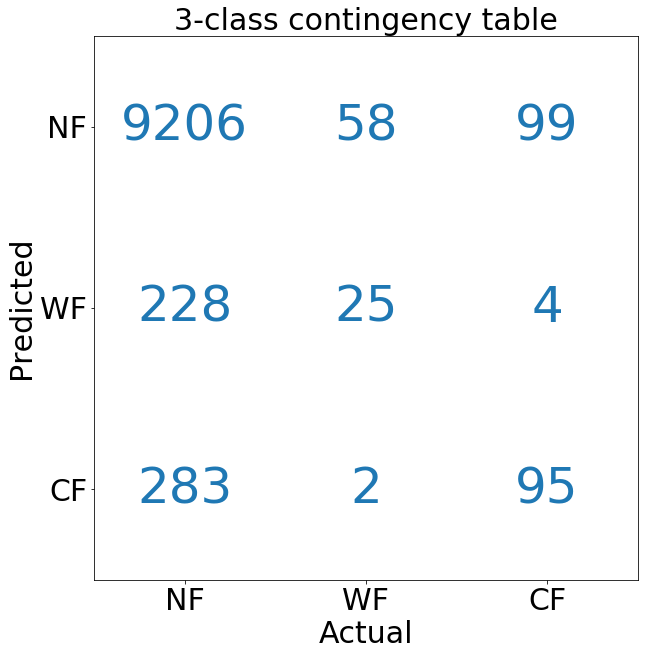

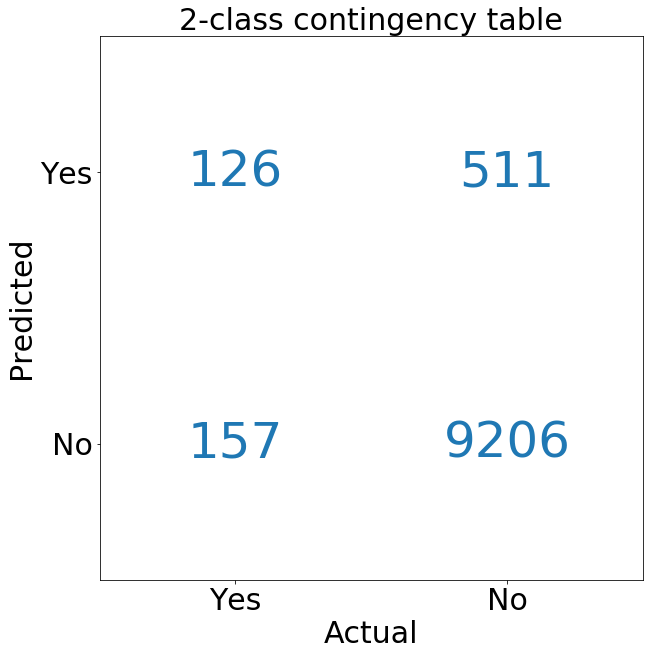

In [79]:
num_examples = len(observed_labels)
predicted_labels = numpy.full(num_examples, NO_FRONT_ENUM, dtype=int)

warm_front_probs = class_probability_matrix[:, WARM_FRONT_ENUM]
predicted_labels[
    warm_front_probs >= WARM_FRONT_PROB_THRESHOLD
] = WARM_FRONT_ENUM

cold_front_probs = class_probability_matrix[:, COLD_FRONT_ENUM]
predicted_labels[
    cold_front_probs >= COLD_FRONT_PROB_THRESHOLD
] = COLD_FRONT_ENUM

contingency_matrix = eval_utils.get_contingency_table(
    predicted_labels=predicted_labels, observed_labels=observed_labels,
    num_classes=3)

_, axes_object = pyplot.subplots(1, 1, figsize=(10, 10))
plot_3class_contingency_table(contingency_matrix=contingency_matrix,
                              axes_object=axes_object)
axes_object.set_title('3-class contingency table')

binary_contingency_dict = binary_eval.get_contingency_table(
    forecast_labels=(predicted_labels != NO_FRONT_ENUM).astype(int),
    observed_labels=(observed_labels != NO_FRONT_ENUM).astype(int)
)

a = binary_contingency_dict[binary_eval.NUM_TRUE_POSITIVES_KEY]
b = binary_contingency_dict[binary_eval.NUM_FALSE_POSITIVES_KEY]
c = binary_contingency_dict[binary_eval.NUM_FALSE_NEGATIVES_KEY]
d = binary_contingency_dict[binary_eval.NUM_TRUE_NEGATIVES_KEY]

binary_contingency_matrix = numpy.array([
    [a, b],
    [c, d]
])

_, axes_object = pyplot.subplots(1, 1, figsize=(10, 10))
plot_2class_contingency_table(contingency_matrix=binary_contingency_matrix,
                              axes_object=axes_object)
axes_object.set_title('2-class contingency table')

binary_pod = binary_eval.get_pod(binary_contingency_dict)
binary_pofd = binary_eval.get_pofd(binary_contingency_dict)
binary_far = binary_eval.get_far(binary_contingency_dict)
binary_csi = binary_eval.get_csi(binary_contingency_dict)
binary_frequency_bias = binary_eval.get_frequency_bias(
    binary_contingency_dict)

print((
    'POD (probability of detection) = fraction of fronts called fronts = '
    '{0:.3f}'
).format(
    binary_pod
))

print((
    'POFD (probability of false detection) = fraction of non-fronts called '
    'fronts = {0:.3f}'
).format(
    binary_pofd
))

print((
    'FAR (false-alarm ratio) = fraction of predicted fronts that are wrong '
    '= {0:.3f}'
).format(
    binary_far
))

print((
    'CSI (critical success index) = accuracy without correct negatives = '
    '{0:.3f}'
).format(
    binary_csi
))

print((
    'Frequency bias = number of predicted over actual fronts = {0:.3f}'
).format(
    binary_frequency_bias
))

# ROC Curve and Performance Diagram

The next cell plots the ROC (receiver operating characteristic) curve and performance diagram for testing data.  Each curve contains 1001 points, corresponding to probability thresholds of 0.000, 0.001, 0.002, $\ldots$, 0.999, 1.000.

Values in the ROC curve are explained/recapped below:

 - POD = probability of detection = $\frac{a}{a + c}$.  This is percentage of fronts correctly identified as fronts.
 - POFD = probability of false detection = $\frac{b}{b + d}$.  This is percentage of non-fronts erroneously identified as fronts.
 - Peirce score = POD - POFD

Values in the performance diagram are explained/recapped below:

 - FAR = false-alarm ratio = $\frac{a}{a + b}$.  This is percentage of predicted fronts that are actually fronts.
 - CSI = critical success index = $\frac{a}{a + b + c}$.  This is accuracy without correct negatives.
 - Frequency bias = $\frac{a + b}{a + c}$.  This is number of predicted fronts over actual fronts.

The quality of a ROC curve can be summarized by the area under the curve (AUC).  AUC ranges from $\left[ 0, 1 \right]$, with 1.0 indicating a perfect model and 0.5 indicating no better than random.  0.9 is generally considered the threshold for "excellent" performance.  The ROC curve is insensitive to event frequency (percentage of examples with a front), which allows such a threshold to be defined across prediction tasks.

No such threshold can be defined for the performance diagram, which is highly sensitive to event frequency.  Generally, as event frequency decreases, the curve shifts towards the bottom-left.  This is because, when event frequency is low, it is difficult to obtain a high POD with a low FAR.  To obtain a high POD, one must correctly identify a large percentage of events; to obtain a low FAR, a large percentage of predicted events must be correct.  For rare events it is difficult to achieve both objectives.

/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:340: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not (numpy.issubdtype(input_variable.dtype, int) or numpy.issubdtype(
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:341: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  input_variable.dtype, float)):
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:251: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it wi

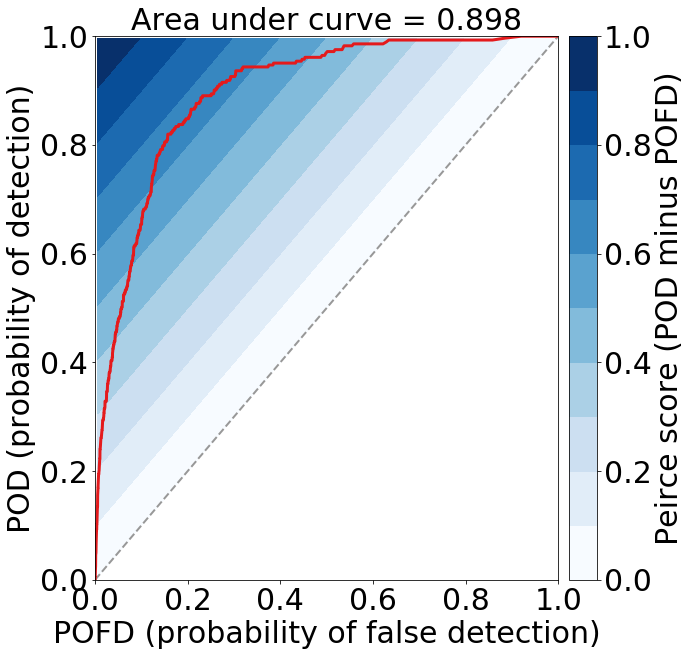

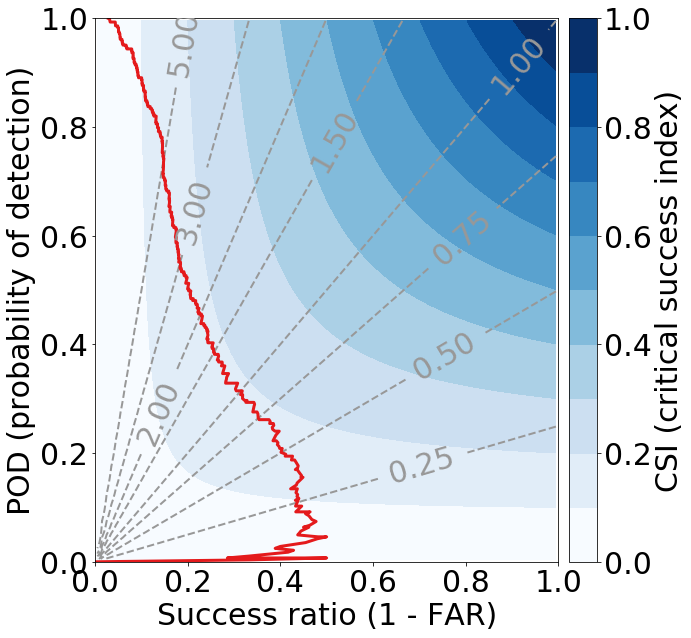

In [80]:
any_front_probs = 1. - class_probability_matrix[:, NO_FRONT_ENUM]

pofd_by_threshold, pod_by_threshold = binary_eval.get_points_in_roc_curve(
    forecast_probabilities=any_front_probs,
    observed_labels=(observed_labels != NO_FRONT_ENUM).astype(int),
    threshold_arg=1001)

_, axes_object = pyplot.subplots(1, 1, figsize=(10, 10))
model_eval_plotting.plot_roc_curve(
    axes_object=axes_object, pod_by_threshold=pod_by_threshold,
    pofd_by_threshold=pofd_by_threshold)

auc = binary_eval.get_area_under_roc_curve(
    pod_by_threshold=pod_by_threshold, pofd_by_threshold=pofd_by_threshold)

axes_object.set_title('Area under curve = {0:.3f}'.format(auc))

success_ratio_by_threshold, pod_by_threshold = (
    binary_eval.get_points_in_performance_diagram(
        forecast_probabilities=any_front_probs,
        observed_labels=(observed_labels != NO_FRONT_ENUM).astype(int),
        threshold_arg=1001)
)

_, axes_object = pyplot.subplots(1, 1, figsize=(10, 10))
model_eval_plotting.plot_performance_diagram(
    axes_object=axes_object, pod_by_threshold=pod_by_threshold,
    success_ratio_by_threshold=success_ratio_by_threshold)

# Attributes Diagram

The next cell plots the attributes diagram for testing data.  The main line (thick, red) is the **reliability curve**, which plots predicted probability vs. conditional event frequency.  This answers the question: "Given a predicted probability of $p$, how likely is the event to actually occur?"  If the model is perfectly **calibrated**, predicted probability = conditional event frequency for all points, so the curve is just the $x = y$ line.

Other lines in the attributes diagram are explained below:

 - Horizontal and vertical grey lines = "climatology".  This is how often fronts occur in the dataset, which is $\sim$1%.
 - Diagonal grey line = perfect reliability ($x = y$)
 - Shaded blue area = positive skill area.  This shows where the model is more reliable, or better calibrated, than always predicting climatology (front probability $\approx$ 1%).

Where the curve is below the diagonal grey line, the model is "overconfident" (predicting too high).  Where the curve is above the diagonal grey line, the model is "underconfident" (predicting too low).

In this case the model is overconfident for all probabilities, mainly due to the downsampling used for training.  The real event frequency is 1.05%, but event frequency in the training data is 50% and the model was not recalibrated.  In these cases probability calibration is often done with, *e.g.*, Platt scaling or isotonic regression.  In our case the overprediction problem is mitigated by setting a high probability threshold (0.65) and doing object conversion, described in Lagerquist *et al.* (2019a,b).

/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:340: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not (numpy.issubdtype(input_variable.dtype, int) or numpy.issubdtype(
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:341: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  input_variable.dtype, float)):
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:251: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it wi

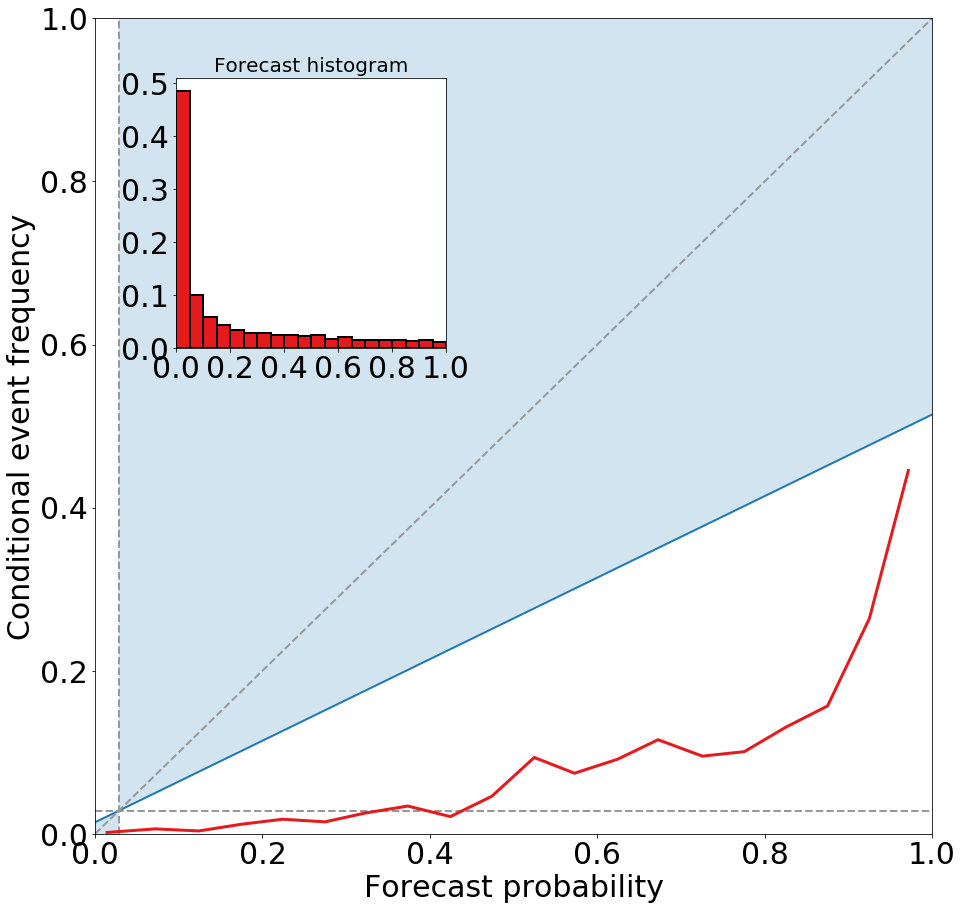

In [81]:
mean_forecast_probs, observed_frequencies, example_counts = (
    binary_eval.get_points_in_reliability_curve(
        forecast_probabilities=any_front_probs,
        observed_labels=(observed_labels != NO_FRONT_ENUM).astype(int)
    )
)

figure_object, axes_object = pyplot.subplots(
    1, 1, figsize=(FIGURE_WIDTH_INCHES, FIGURE_HEIGHT_INCHES)
)

model_eval_plotting.plot_attributes_diagram(
    figure_object=figure_object, axes_object=axes_object,
    mean_forecast_by_bin=mean_forecast_probs,
    event_frequency_by_bin=observed_frequencies,
    num_examples_by_bin=example_counts)

# Model Interpretation

The rest of this notebook discusses a few methods for model interpretation.

# Saliency Maps

Saliency is defined below.  $p_k$ is the probability of the $k^{\textrm{th}}$ class; $x$ is one predictor for the CNN; and $x_0$ is the true value of $x$ in one example.

$\textrm{saliency} = \frac{\partial p_k}{\partial x} \lvert_{x = x_0}$

In other words, saliency is the derivative of class probability (NF, WF, or CF) with respect to $x$, linearized around the value $x_0$ in a real data example.  More simply, saliency tells you how class probability changes when $x$ is perturbed around $x_0$.

Saliency can be computed for every input value (every predictor at every grid cell), resulting in a **saliency map**.  The next cell defines methods to compute and plot saliency maps.  The method to compute saliency maps, `get_saliency_maps`, is adapted from the [Swirlnet tutorial](https://github.com/djgagne/swirlnet/blob/master/notebooks/deep_swirl_tutorial.ipynb).

In [82]:
def get_saliency_maps(model_object, target_class, predictor_matrix):
    """Computes saliency map for each example in `predictor_matrix`.

    :param model_object: Trained CNN (instance of `keras.models`).  Saliency
        will be computed for this CNN only.  Different models give different
        answers.
    :param target_class: Target class (integer).  Possible values are
        `NO_FRONT_ENUM`, `WARM_FRONT_ENUM`, and `WARM_FRONT_ENUM`, listed at the
        top of this notebook.
    :param predictor_matrix: E-by-M-by-N-by-C numpy array of predictor values.
    :return: saliency_matrix: E-by-M-by-N-by-C numpy array of saliency values.
    """

    loss_tensor = K.mean(
        (model_object.layers[-1].output[..., target_class] - 1) ** 2
    )

    gradient_tensor = K.gradients(
        loss_tensor, [model_object.input]
    )[0]
    gradient_tensor = gradient_tensor / K.maximum(
        K.std(gradient_tensor), K.epsilon()
    )

    inputs_to_gradients_function = K.function(
        [model_object.input, K.learning_phase()], [gradient_tensor]
    )

    saliency_matrix = inputs_to_gradients_function(
        [predictor_matrix, 0]
    )[0]

    return -1 * saliency_matrix


def _plot_saliency_one_field(
        saliency_matrix, axes_object, max_absolute_contour_value,
        contour_interval, colour_map_object=SALIENCY_COLOUR_MAP_OBJECT):
    """Plots saliency map for one 2-D field.

    M = number of rows in grid
    N = number of columns in grid

    :param saliency_matrix: M-by-N numpy array of saliency values.
    :param axes_object: Existing axes (instance of
        `matplotlib.axes._subplots.AxesSubplot`).
    :param max_absolute_contour_value: Max absolute saliency value to plot.
    :param contour_interval: Interval between successive saliency contours.
    :param colour_map_object: Colour scheme (instance of
        `matplotlib.pyplot.cm`).
    """

    error_checking.assert_is_geq(max_absolute_contour_value, 0.)
    max_absolute_contour_value = numpy.maximum(max_absolute_contour_value, 1e-3)

    error_checking.assert_is_geq(contour_interval, 0.)
    contour_interval = numpy.maximum(contour_interval, 1e-4)
    error_checking.assert_is_less_than(
        contour_interval, max_absolute_contour_value)

    num_rows = saliency_matrix.shape[0]
    num_columns = saliency_matrix.shape[1]
    unique_y_coords = -0.5 + numpy.linspace(1, num_rows, num=num_rows)
    unique_x_coords = -0.5 + numpy.linspace(1, num_columns, num=num_columns)

    x_coord_matrix, y_coord_matrix = numpy.meshgrid(
        unique_x_coords, unique_y_coords)

    half_num_contours = int(numpy.round(
        1 + max_absolute_contour_value / contour_interval
    ))

    # Plot positive values.
    these_contour_values = numpy.linspace(
        0., max_absolute_contour_value, num=half_num_contours)

    axes_object.contour(
        x_coord_matrix, y_coord_matrix, saliency_matrix,
        these_contour_values, cmap=colour_map_object,
        vmin=numpy.min(these_contour_values),
        vmax=numpy.max(these_contour_values),
        linewidths=2, linestyles='solid', zorder=1e6)

    # Plot negative values.
    these_contour_values = these_contour_values[1:]

    axes_object.contour(
        x_coord_matrix, y_coord_matrix, -saliency_matrix,
        these_contour_values, cmap=colour_map_object,
        vmin=numpy.min(these_contour_values),
        vmax=numpy.max(these_contour_values),
        linewidths=2, linestyles='dashed', zorder=1e6)


def plot_saliency_one_example(
        predictor_matrix, saliency_matrix, predictor_names):
    """Plots saliency maps for one example.

    :param predictor_matrix: M-by-N-by-C numpy array of predictor values.
    :param saliency_matrix: M-by-N-by-C numpy array of saliency values.
    :param predictor_names: length-C list with names of predictor variables.
    :return: figure_object: See doc for `create_paneled_figure`.
    :return: axes_object_matrix: Same.
    """

    error_checking.assert_is_numpy_array_without_nan(predictor_matrix)
    error_checking.assert_is_numpy_array(predictor_matrix, num_dimensions=3)

    error_checking.assert_is_numpy_array_without_nan(saliency_matrix)
    error_checking.assert_is_numpy_array(
        saliency_matrix, exact_dimensions=numpy.array(predictor_matrix.shape)
    )

    num_predictors = predictor_matrix.shape[-1]
    expected_dim = numpy.array([num_predictors], dtype=int)
    error_checking.assert_is_numpy_array(
        numpy.array(predictor_names), exact_dimensions=expected_dim
    )

    num_panel_rows = int(numpy.floor(
        numpy.sqrt(num_predictors)
    ))
    num_panel_columns = int(numpy.ceil(
        float(num_predictors) / num_panel_rows
    ))

    figure_object, axes_object_matrix = create_paneled_figure(
        num_rows=num_panel_rows, num_columns=num_panel_columns,
        horizontal_spacing=0.2, vertical_spacing=0.2)

    max_absolute_saliency = numpy.percentile(
        numpy.absolute(saliency_matrix), 99.
    )

    for k in range(num_predictors):
        this_axes_object = numpy.ravel(axes_object_matrix)[k]
        plot_feature_map(
            feature_matrix=predictor_matrix[..., k],
            axes_object=this_axes_object
        )

        _plot_saliency_one_field(
            saliency_matrix=saliency_matrix[..., k],
            axes_object=this_axes_object,
            max_absolute_contour_value=max_absolute_saliency,
            contour_interval=max_absolute_saliency / 10)
        
        this_axes_object.set_title(predictor_names[k], fontsize=20)

    return figure_object, axes_object_matrix


def apply_median_filter(input_matrix_2d, num_cells_in_half_window):
    """Applies median filter to 2-D field.

    M = number of rows in grid
    N = number of columns in grid

    :param input_matrix_2d: M-by-N numpy array of raw (unfiltered) data.
    :param num_cells_in_half_window: Number of grid cells in half-window for
        smoothing filter.
    :return: output_matrix_2d: M-by-N numpy array of filtered data.
    """

    error_checking.assert_is_integer(num_cells_in_half_window)
    error_checking.assert_is_geq(num_cells_in_half_window, 1)

    return median_filter(
        input_matrix_2d, size=2 * num_cells_in_half_window + 1, mode='reflect',
        origin=0)

# Saliency example 1: WF saliency for NF example

The next cell plots a WF saliency map for an NF example.  In other words, the true label is NF (no front), and saliency tells us how to change the input data to increase WF (warm front) probability.

The colour fill shows the input fields (surface temperature, humidity, $u$-wind, $v$-wind).  Although 850-millibar fields are also involved in the calculation (by necessity because the model was trained with both surface and 850-mb data), they are omitted for the sake of simplicity.

The line contours on top show saliency:

 - Solid contours = positive saliency (WF probability increases with value underneath)
 - Dashed contours = negative saliency (WF probability decreases with value underneath)
 - Darker = greater magnitude

Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/testing/downsized_3d_examples_2015120109-2015120109.nc"...


/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:251: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not numpy.issubdtype(input_variable.dtype, int):
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:340: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not (numpy.issubdtype(input_variable.dtype, int) or numpy.issubdtype(
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:341: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated.

(<Figure size 1080x1080 with 8 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f62a6160208>,
       dtype=object))

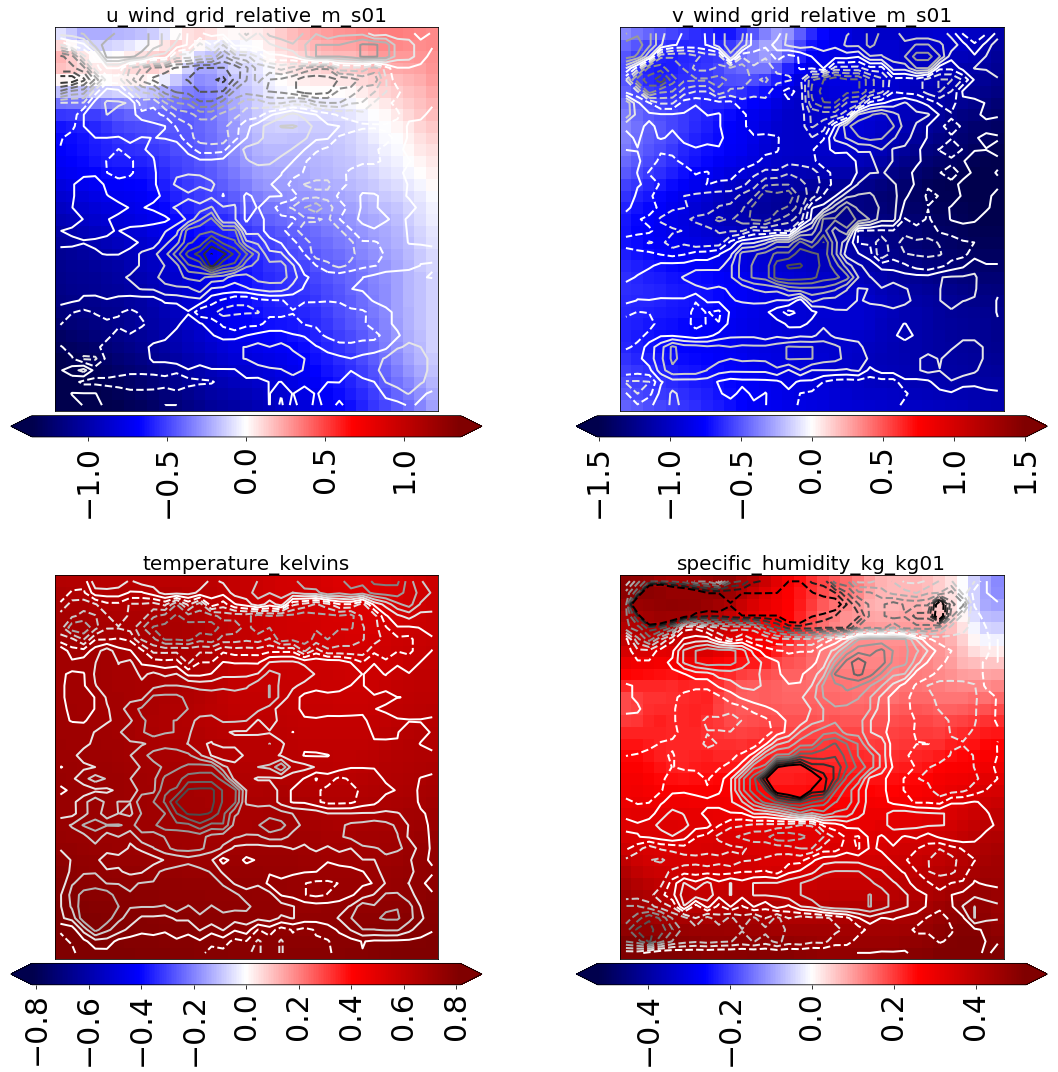

In [83]:
num_half_rows, num_half_columns = model_to_grid_dimensions(
    best_model_object)

print('Reading data from: "{0:s}"...'.format(testing_file_names[0]))
example_dict = read_examples(
    netcdf_file_name=testing_file_names[0],
    predictor_names_to_keep=PREDICTOR_NAMES_FOR_CNN,
    pressure_levels_to_keep_mb=PRESSURE_LEVELS_FOR_CNN_MB,
    num_half_rows_to_keep=num_half_rows,
    num_half_columns_to_keep=num_half_columns)

example_index = numpy.where(
    example_dict[TARGET_MATRIX_KEY][:, NO_FRONT_ENUM] == 1
)[0][0]
predictor_matrix = example_dict[PREDICTOR_MATRIX_KEY][example_index, ...]

saliency_matrix = get_saliency_maps(
    model_object=best_model_object, target_class=WARM_FRONT_ENUM,
    predictor_matrix=numpy.expand_dims(predictor_matrix, axis=0)
)

saliency_matrix = saliency_matrix[0, ...]
num_predictors = saliency_matrix.shape[-1]

for k in range(num_predictors):
    saliency_matrix[..., k] = apply_median_filter(
        input_matrix_2d=saliency_matrix[..., k], num_cells_in_half_window=1
    )

plot_saliency_one_example(
    predictor_matrix=predictor_matrix[..., :4],
    saliency_matrix=saliency_matrix[..., :4],
    predictor_names=PREDICTOR_NAMES_FOR_CNN[:4]
)

# Saliency example 2: CF saliency for NF example

Same as Example 1, but with CF saliency instead of WF saliency.

Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/testing/downsized_3d_examples_2015120109-2015120109.nc"...


/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:251: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not numpy.issubdtype(input_variable.dtype, int):
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:340: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not (numpy.issubdtype(input_variable.dtype, int) or numpy.issubdtype(
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:341: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated.

(<Figure size 1080x1080 with 8 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f62a524c518>,
       dtype=object))

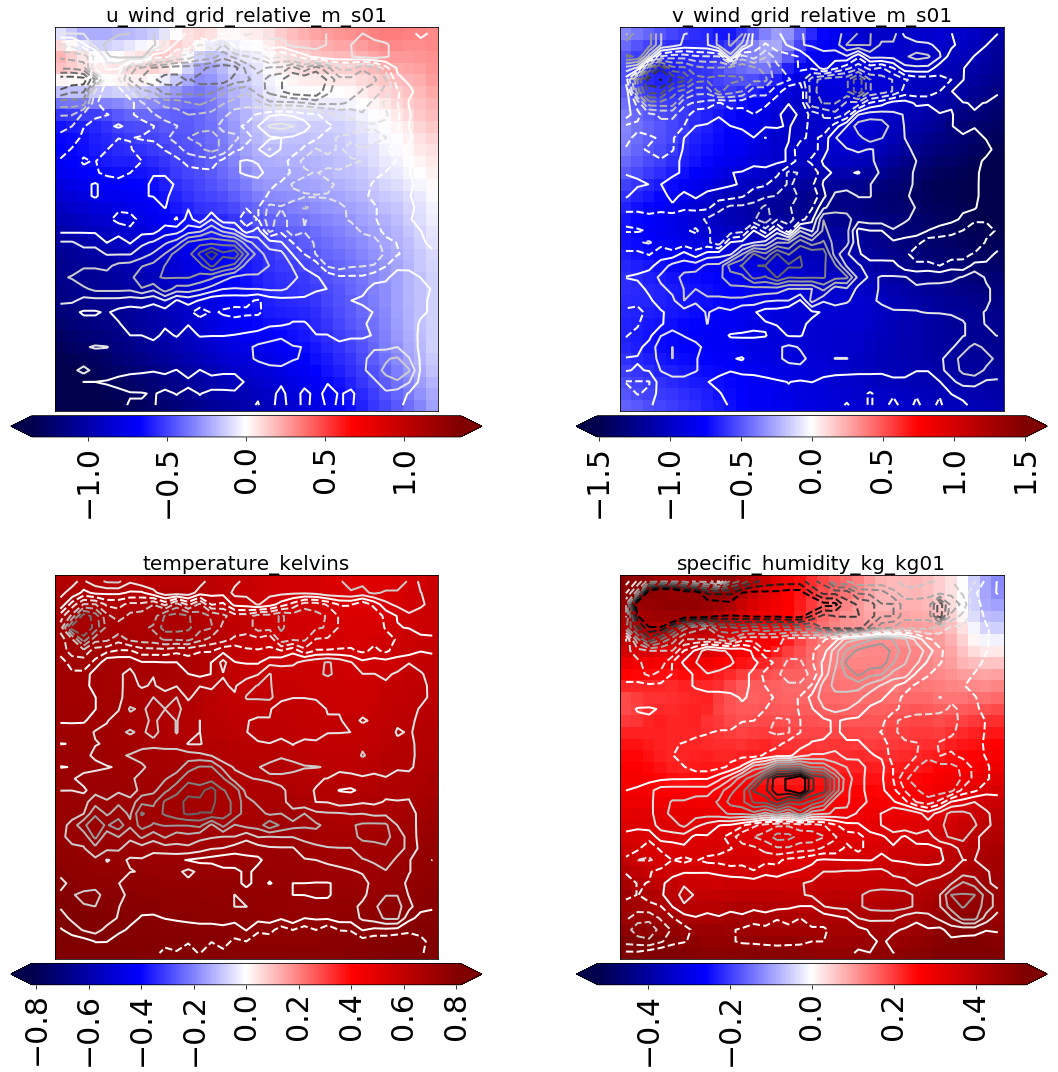

In [84]:
num_half_rows, num_half_columns = model_to_grid_dimensions(
    best_model_object)

print('Reading data from: "{0:s}"...'.format(testing_file_names[0]))
example_dict = read_examples(
    netcdf_file_name=testing_file_names[0],
    predictor_names_to_keep=PREDICTOR_NAMES_FOR_CNN,
    pressure_levels_to_keep_mb=PRESSURE_LEVELS_FOR_CNN_MB,
    num_half_rows_to_keep=num_half_rows,
    num_half_columns_to_keep=num_half_columns)

example_index = numpy.where(
    example_dict[TARGET_MATRIX_KEY][:, NO_FRONT_ENUM] == 1
)[0][0]
predictor_matrix = example_dict[PREDICTOR_MATRIX_KEY][example_index, ...]

saliency_matrix = get_saliency_maps(
    model_object=best_model_object, target_class=COLD_FRONT_ENUM,
    predictor_matrix=numpy.expand_dims(predictor_matrix, axis=0)
)

saliency_matrix = saliency_matrix[0, ...]
num_predictors = saliency_matrix.shape[-1]

for k in range(num_predictors):
    saliency_matrix[..., k] = apply_median_filter(
        input_matrix_2d=saliency_matrix[..., k], num_cells_in_half_window=1
    )

plot_saliency_one_example(
    predictor_matrix=predictor_matrix[..., :4],
    saliency_matrix=saliency_matrix[..., :4],
    predictor_names=PREDICTOR_NAMES_FOR_CNN[:4]
)

# Saliency example 3: CF saliency for CF example

Same as Example 1, but now we compute CF saliency for a CF example.  In other words, the true label is CF, and saliency tells us how to change the input to increase the CNN's probability of CF.

Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/testing/downsized_3d_examples_2015120109-2015120109.nc"...


/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:251: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not numpy.issubdtype(input_variable.dtype, int):
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:340: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not (numpy.issubdtype(input_variable.dtype, int) or numpy.issubdtype(
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:341: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated.

(<Figure size 1080x1080 with 8 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f62a43a2c50>,
       dtype=object))

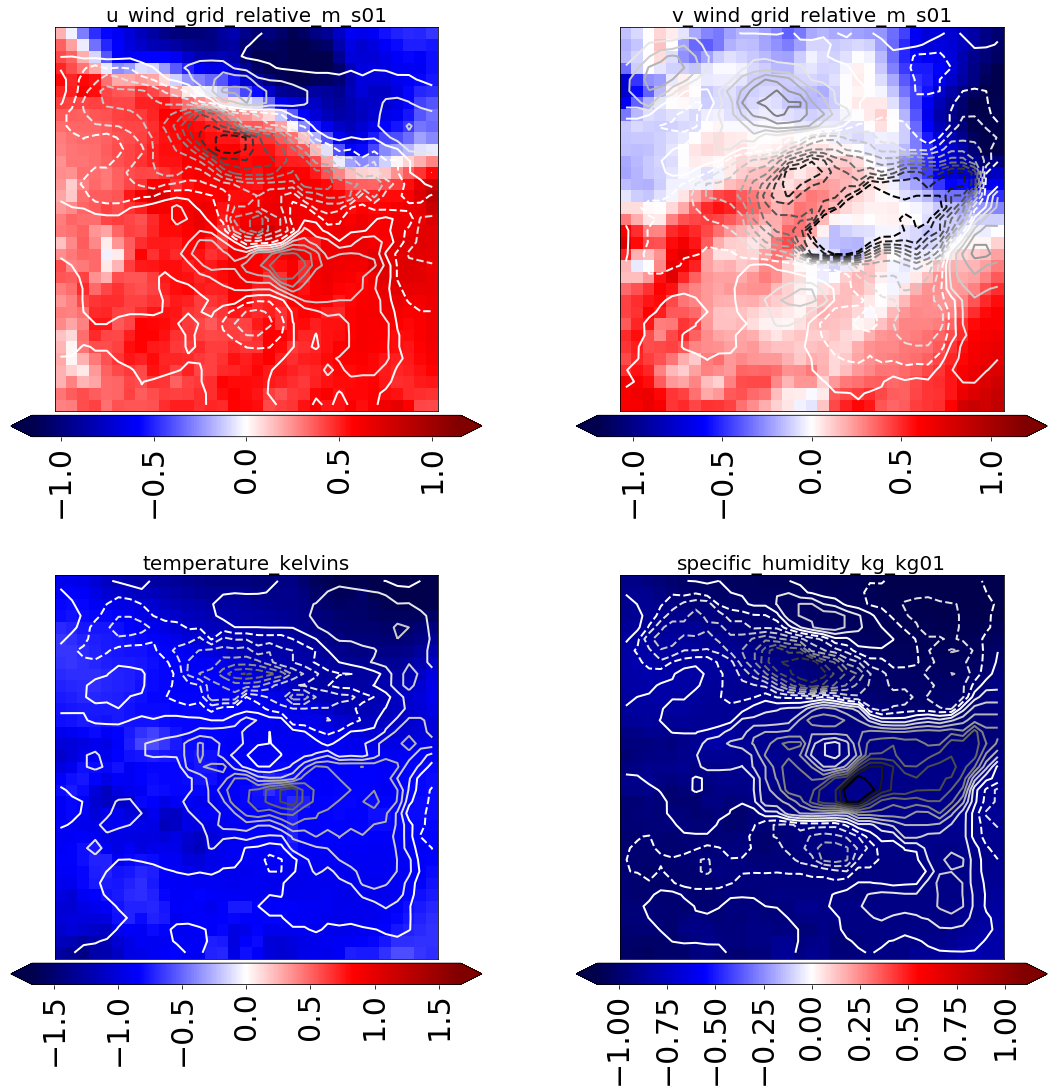

In [85]:
num_half_rows, num_half_columns = model_to_grid_dimensions(
    best_model_object)

print('Reading data from: "{0:s}"...'.format(testing_file_names[0]))
example_dict = read_examples(
    netcdf_file_name=testing_file_names[0],
    predictor_names_to_keep=PREDICTOR_NAMES_FOR_CNN,
    pressure_levels_to_keep_mb=PRESSURE_LEVELS_FOR_CNN_MB,
    num_half_rows_to_keep=num_half_rows,
    num_half_columns_to_keep=num_half_columns)

example_index = numpy.where(
    example_dict[TARGET_MATRIX_KEY][:, COLD_FRONT_ENUM] == 1
)[0][0]
predictor_matrix = example_dict[PREDICTOR_MATRIX_KEY][example_index, ...]

saliency_matrix = get_saliency_maps(
    model_object=best_model_object, target_class=COLD_FRONT_ENUM,
    predictor_matrix=numpy.expand_dims(predictor_matrix, axis=0)
)

saliency_matrix = saliency_matrix[0, ...]
num_predictors = saliency_matrix.shape[-1]

for k in range(num_predictors):
    saliency_matrix[..., k] = apply_median_filter(
        input_matrix_2d=saliency_matrix[..., k], num_cells_in_half_window=1
    )

plot_saliency_one_example(
    predictor_matrix=predictor_matrix[..., :4],
    saliency_matrix=saliency_matrix[..., :4],
    predictor_names=PREDICTOR_NAMES_FOR_CNN[:4]
)

# Saliency example 4: WF saliency for CF example

Same as Example 3 but for WF saliency.  In other words, the maps tell us how to change the input to increase WF probability for an example that is actually a cold front.

Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/testing/downsized_3d_examples_2015120109-2015120109.nc"...


/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:251: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not numpy.issubdtype(input_variable.dtype, int):
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:340: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not (numpy.issubdtype(input_variable.dtype, int) or numpy.issubdtype(
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:341: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated.

(<Figure size 1080x1080 with 8 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f62a70c79e8>,
       dtype=object))

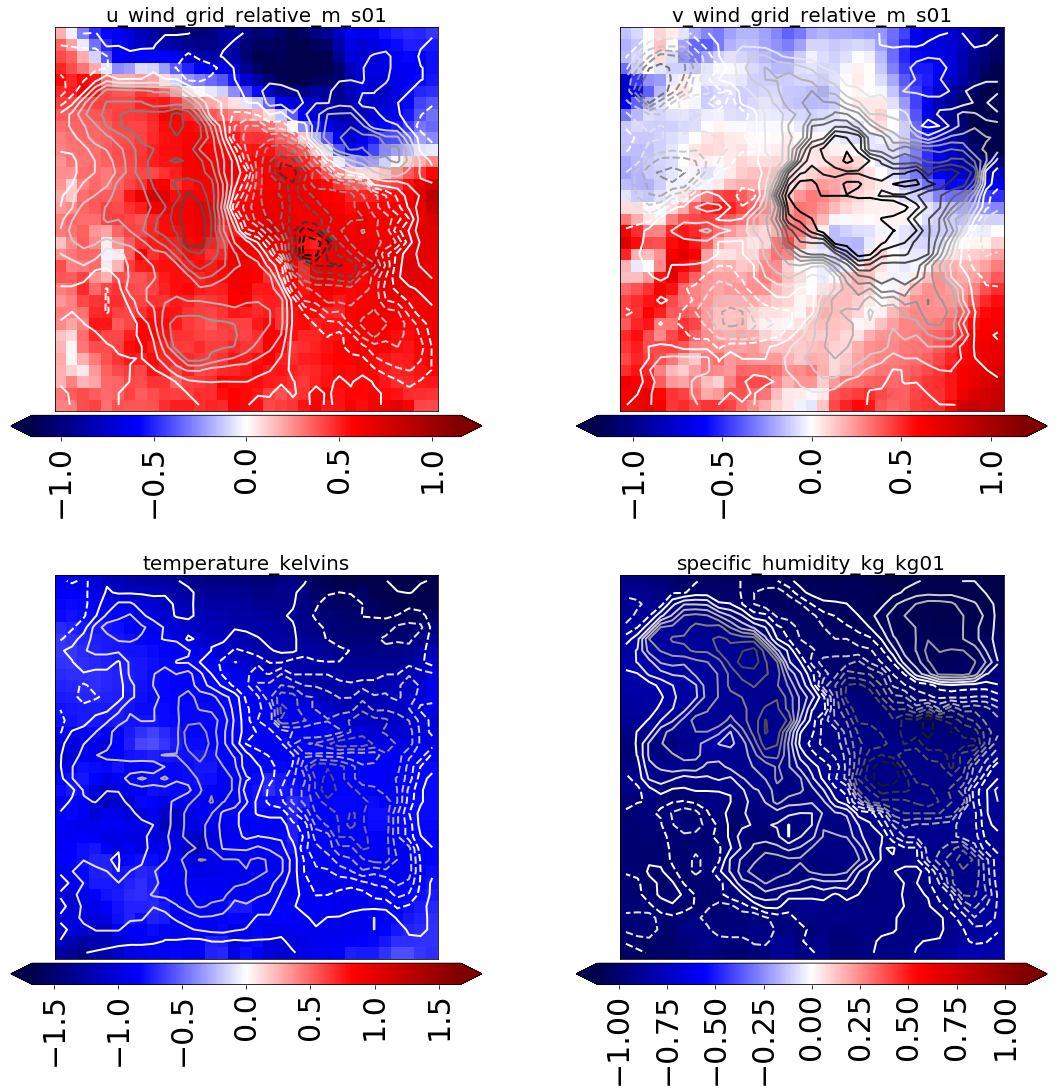

In [86]:
num_half_rows, num_half_columns = model_to_grid_dimensions(
    best_model_object)

print('Reading data from: "{0:s}"...'.format(testing_file_names[0]))
example_dict = read_examples(
    netcdf_file_name=testing_file_names[0],
    predictor_names_to_keep=PREDICTOR_NAMES_FOR_CNN,
    pressure_levels_to_keep_mb=PRESSURE_LEVELS_FOR_CNN_MB,
    num_half_rows_to_keep=num_half_rows,
    num_half_columns_to_keep=num_half_columns)

example_index = numpy.where(
    example_dict[TARGET_MATRIX_KEY][:, COLD_FRONT_ENUM] == 1
)[0][0]
predictor_matrix = example_dict[PREDICTOR_MATRIX_KEY][example_index, ...]

saliency_matrix = get_saliency_maps(
    model_object=best_model_object, target_class=WARM_FRONT_ENUM,
    predictor_matrix=numpy.expand_dims(predictor_matrix, axis=0)
)

saliency_matrix = saliency_matrix[0, ...]
num_predictors = saliency_matrix.shape[-1]

for k in range(num_predictors):
    saliency_matrix[..., k] = apply_median_filter(
        input_matrix_2d=saliency_matrix[..., k], num_cells_in_half_window=1
    )

plot_saliency_one_example(
    predictor_matrix=predictor_matrix[..., :4],
    saliency_matrix=saliency_matrix[..., :4],
    predictor_names=PREDICTOR_NAMES_FOR_CNN[:4]
)

# Class-activation Maps (CAM)

Class-activation maps quantify the amount of evidence for the given class (NF, WF, or CF) at each grid cell.  Some key differences between saliency maps and CAMs are summarized in the table below.

<img src="saliency_vs_cam.png" alt="Saliency vs. class-activation maps (CAM)" width="1000" />

The next cell defines methods to compute and plot CAMs.

In [87]:
def _upsample_cam(class_activation_matrix, num_target_rows, num_target_columns):
    """Upsamples class-activation map (CAM) to new dimensions.

    m = number of rows in original grid
    n = number of columns in original grid
    M = number of rows in new grid
    N = number of columns in new grid

    :param class_activation_matrix: m-by-n numpy array of class activations.
    :param num_target_rows: Number of rows in new (target) grid.
    :param num_target_columns: Number of columns in new (target) grid.
    :return: class_activation_matrix: M-by-N numpy array of class activations.
    """

    row_indices_new = numpy.linspace(
        1, num_target_rows, num=num_target_rows, dtype=float
    )
    row_indices_orig = numpy.linspace(
        1, num_target_rows, num=class_activation_matrix.shape[0], dtype=float
    )

    column_indices_new = numpy.linspace(
        1, num_target_columns, num=num_target_columns, dtype=float
    )
    column_indices_orig = numpy.linspace(
        1, num_target_columns, num=class_activation_matrix.shape[1], dtype=float
    )

    interp_object = RectBivariateSpline(
        x=row_indices_orig, y=column_indices_orig, z=class_activation_matrix,
        kx=1, ky=1, s=0)

    return interp_object(x=row_indices_new, y=column_indices_new, grid=True)


def run_gradcam(model_object, predictor_matrix, target_class,
                target_layer_name):
    """Runs Grad-CAM.

    :param model_object: See doc for `get_saliency_maps`.
    :param predictor_matrix: Same.
    :param target_class: Same.
    :param target_layer_name: Name of target layer.  Class-activation map will
        be computed for this layer.
    :return: class_activation_matrix: M-by-N numpy array of class activations.
    """

    # Set up tensors.
    loss_tensor = model_object.layers[-1].input[..., target_class]
    activation_tensor = model_object.get_layer(name=target_layer_name).output
    gradient_tensor = tensorflow.gradients(
        loss_tensor, [activation_tensor]
    )[0]

    root_mean_square_tensor = K.sqrt(K.mean(K.square(gradient_tensor)))
    gradient_tensor = gradient_tensor / (root_mean_square_tensor + K.epsilon())

    gradient_function = K.function(
        [model_object.input], [activation_tensor, gradient_tensor]
    )

    # Compute activation and gradient matrices for target layer.
    activation_matrix, gradient_matrix = gradient_function([predictor_matrix])
    activation_matrix = activation_matrix[0, ...]
    gradient_matrix = gradient_matrix[0, ...]

    # Compute class-activation map.
    mean_weight_by_filter = numpy.mean(gradient_matrix, axis=(0, 1))

    class_activation_matrix = numpy.ones(activation_matrix.shape[:-1])
    num_filters = len(mean_weight_by_filter)

    for k in range(num_filters):
        class_activation_matrix += (
            mean_weight_by_filter[k] * activation_matrix[..., k]
        )

    # Upsample class-activation map to input dimensions.
    class_activation_matrix = _upsample_cam(
        class_activation_matrix=class_activation_matrix,
        num_target_rows=predictor_matrix.shape[1],
        num_target_columns=predictor_matrix.shape[2]
    )

    class_activation_matrix = numpy.maximum(class_activation_matrix, 0.)
    return class_activation_matrix


def _plot_class_activn_one_field(
        class_activation_matrix, axes_object, max_contour_value,
        contour_interval, colour_map_object=SALIENCY_COLOUR_MAP_OBJECT):
    """Plots class-activation map for one 2-D field.

    M = number of rows in grid
    N = number of columns in grid

    :param class_activation_matrix: M-by-N numpy array of saliency values.
    :param axes_object: See doc for `_plot_saliency_one_field`.
    :param max_contour_value: Max value to plot.
    :param contour_interval: See doc for `_plot_saliency_one_field`.
    :param colour_map_object: Same.
    """

    error_checking.assert_is_geq(max_contour_value, 0.)
    max_contour_value = numpy.maximum(max_contour_value, 1e-3)

    error_checking.assert_is_geq(contour_interval, 0.)
    contour_interval = numpy.maximum(contour_interval, 1e-4)
    error_checking.assert_is_less_than(contour_interval, max_contour_value)

    num_rows = class_activation_matrix.shape[0]
    num_columns = class_activation_matrix.shape[1]
    unique_y_coords = -0.5 + numpy.linspace(1, num_rows, num=num_rows)
    unique_x_coords = -0.5 + numpy.linspace(1, num_columns, num=num_columns)

    x_coord_matrix, y_coord_matrix = numpy.meshgrid(
        unique_x_coords, unique_y_coords)

    num_contours = int(numpy.round(
        1 + max_contour_value / contour_interval
    ))
    contour_values = numpy.linspace(0., max_contour_value, num=num_contours)

    axes_object.contour(
        x_coord_matrix, y_coord_matrix, class_activation_matrix,
        contour_values, cmap=colour_map_object,
        vmin=numpy.min(contour_values), vmax=numpy.max(contour_values),
        linewidths=2, linestyles='solid', zorder=1e6)


def plot_class_activn_one_example(
        predictor_matrix, class_activation_matrix, predictor_names):
    """Plots saliency maps for one example.

    :param predictor_matrix: M-by-N-by-C numpy array of predictor values.
    :param class_activation_matrix: M-by-N numpy array of class activations.
    :param predictor_names: length-C list with names of predictor variables.
    :return: figure_object: See doc for `create_paneled_figure`.
    :return: axes_object_matrix: Same.
    """

    error_checking.assert_is_numpy_array_without_nan(predictor_matrix)
    error_checking.assert_is_numpy_array(predictor_matrix, num_dimensions=3)

    error_checking.assert_is_geq_numpy_array(class_activation_matrix, 0.)
    error_checking.assert_is_numpy_array(
        class_activation_matrix,
        exact_dimensions=numpy.array(predictor_matrix.shape[:-1])
    )

    num_predictors = predictor_matrix.shape[-1]
    expected_dim = numpy.array([num_predictors], dtype=int)
    error_checking.assert_is_numpy_array(
        numpy.array(predictor_names), exact_dimensions=expected_dim
    )

    num_panel_rows = int(numpy.floor(
        numpy.sqrt(num_predictors)
    ))
    num_panel_columns = 1 + int(numpy.ceil(
        float(num_predictors) / num_panel_rows
    ))

    column_widths = numpy.concatenate((
        numpy.full(num_panel_columns - 1, 3), numpy.array([1])
    ))

    figure_object, axes_object_matrix = create_paneled_figure(
        num_rows=num_panel_rows, num_columns=num_panel_columns,
        horizontal_spacing=0.2, vertical_spacing=0.2,
        grid_spec_dict={'width_ratios': column_widths}
    )

    for i in range(num_panel_rows):
        axes_object_matrix[i, -1].axis('off')

    max_activation = numpy.percentile(class_activation_matrix, 99.)

    for k in range(num_predictors):
        this_axes_object = numpy.ravel(axes_object_matrix[:, :-1])[k]
        plot_feature_map(
            feature_matrix=predictor_matrix[..., k],
            axes_object=this_axes_object
        )

        _plot_class_activn_one_field(
            class_activation_matrix=class_activation_matrix,
            axes_object=this_axes_object, max_contour_value=max_activation,
            contour_interval=max_activation / 10,
            colour_map_object=SALIENCY_COLOUR_MAP_OBJECT)

        this_axes_object.set_title(predictor_names[k], fontsize=20)

    colour_bar_object = _add_colour_bar(
        axes_object=axes_object_matrix[:, -1],
        colour_map_object=SALIENCY_COLOUR_MAP_OBJECT,
        values_to_colour=class_activation_matrix, min_colour_value=0.,
        max_colour_value=max_activation, orientation_string='vertical',
        extend_min=False, extend_max=True, fraction_of_axis_length=5.)

    colour_bar_object.set_label('Class activation')

    return figure_object, axes_object_matrix

# CAM example 1

The next cell plots the WF activation map for a WF example.  In other words, the true label is WF and the maps tell us which grid cells support the WF conclusion.

Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/testing/downsized_3d_examples_2015120109-2015120109.nc"...


/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:251: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not numpy.issubdtype(input_variable.dtype, int):
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:340: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not (numpy.issubdtype(input_variable.dtype, int) or numpy.issubdtype(
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:341: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated.

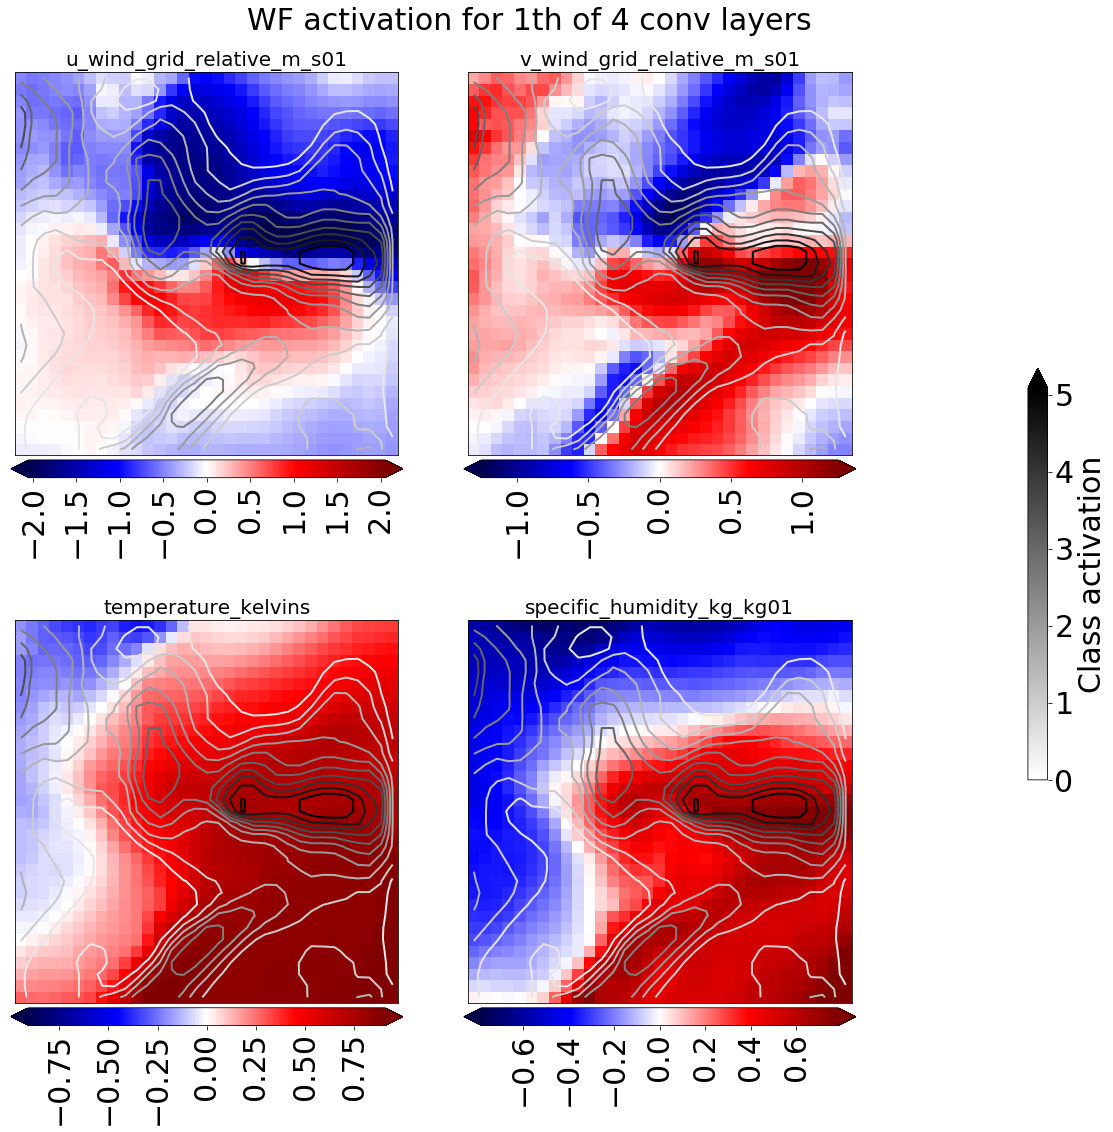

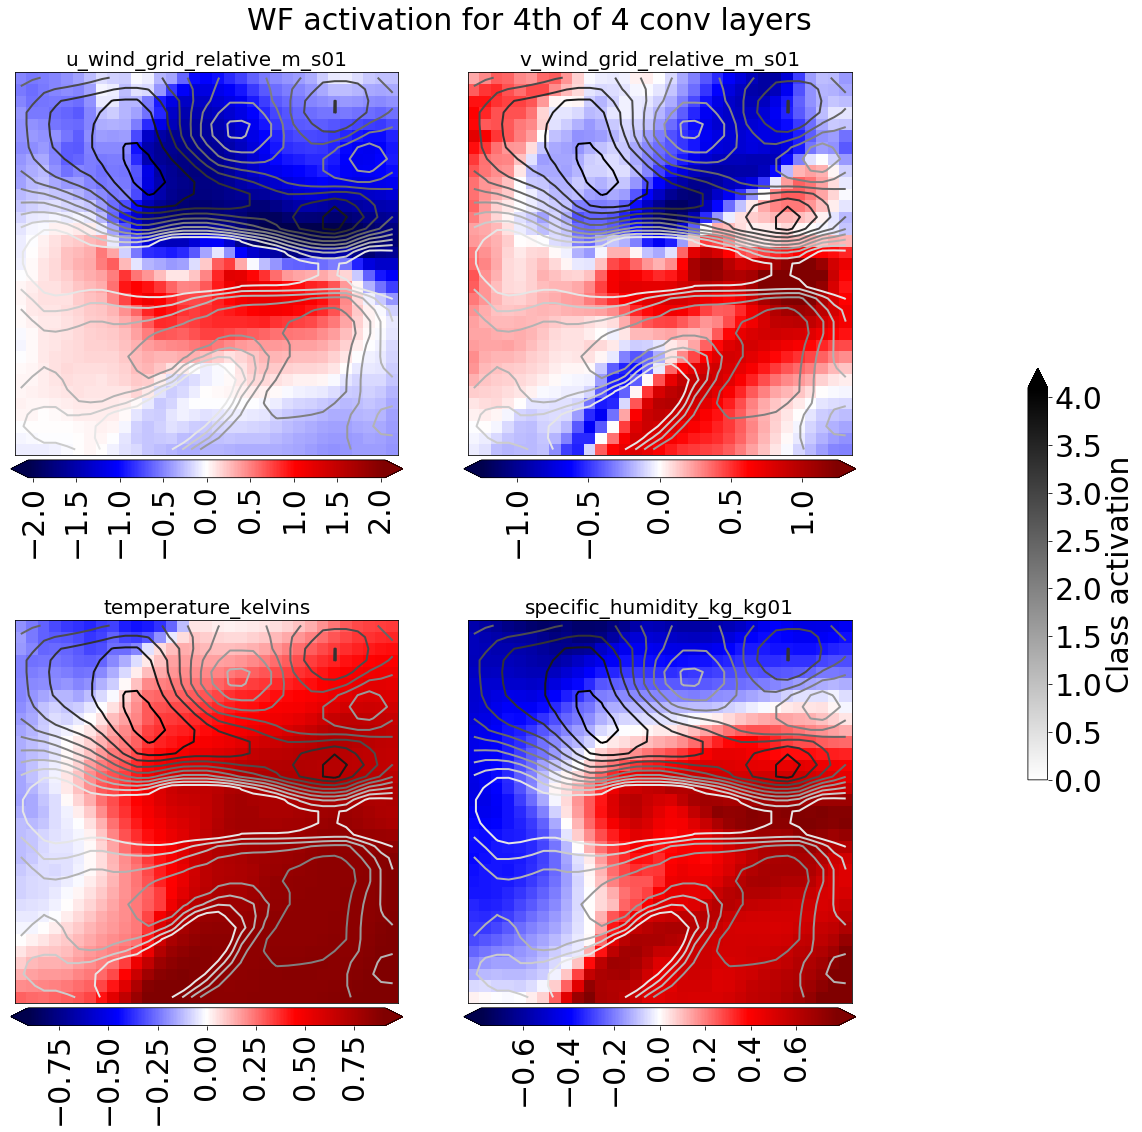

In [92]:
num_half_rows, num_half_columns = model_to_grid_dimensions(
    best_model_object)

print('Reading data from: "{0:s}"...'.format(testing_file_names[0]))
example_dict = read_examples(
    netcdf_file_name=testing_file_names[0],
    predictor_names_to_keep=PREDICTOR_NAMES_FOR_CNN,
    pressure_levels_to_keep_mb=PRESSURE_LEVELS_FOR_CNN_MB,
    num_half_rows_to_keep=num_half_rows,
    num_half_columns_to_keep=num_half_columns)

example_index = numpy.where(
    example_dict[TARGET_MATRIX_KEY][:, WARM_FRONT_ENUM] == 1
)[0][0]
predictor_matrix = example_dict[PREDICTOR_MATRIX_KEY][example_index, ...]

conv_layer_names = [
    l.name for l in best_model_object.layers
    if 'batch_normalization' in l.name
]

conv_layer_names = conv_layer_names[:4]
num_conv_layers = len(conv_layer_names)

for i in [0, 3]:
    class_activation_matrix = run_gradcam(
        model_object=best_model_object,
        predictor_matrix=numpy.expand_dims(predictor_matrix, axis=0),
        target_class=WARM_FRONT_ENUM, target_layer_name=conv_layer_names[i]
    )

    class_activation_matrix = apply_median_filter(
        input_matrix_2d=class_activation_matrix, num_cells_in_half_window=1)

    class_activation_matrix = numpy.maximum(class_activation_matrix, 0.)

    figure_object, _ = plot_class_activn_one_example(
        predictor_matrix=predictor_matrix[..., :4],
        class_activation_matrix=class_activation_matrix,
        predictor_names=PREDICTOR_NAMES_FOR_CNN[:4]
    )

    title_string = (
        'WF activation for {0:d}th of {1:d} conv layers'
    ).format(i + 1, num_conv_layers)

    figure_object.suptitle(title_string, y=1.01)

# CAM example 2

Same as Example 1, but now we compute CF activation for the WF example.  In other words, the maps tell us which grid cells would support a (wrong) CF conclusion.

Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/testing/downsized_3d_examples_2015120109-2015120109.nc"...


/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:251: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not numpy.issubdtype(input_variable.dtype, int):
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:340: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not (numpy.issubdtype(input_variable.dtype, int) or numpy.issubdtype(
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:341: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated.

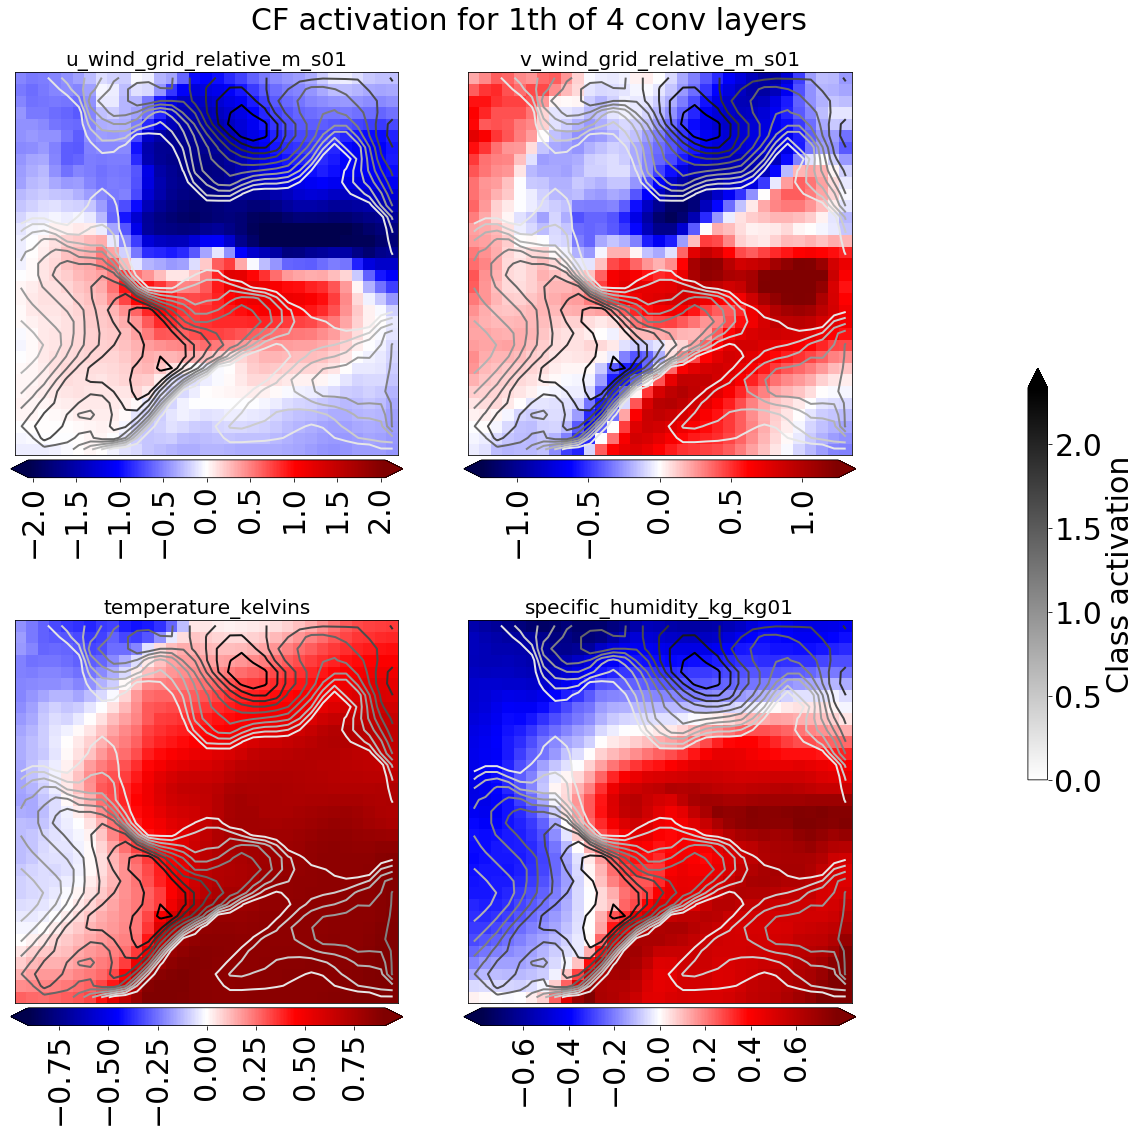

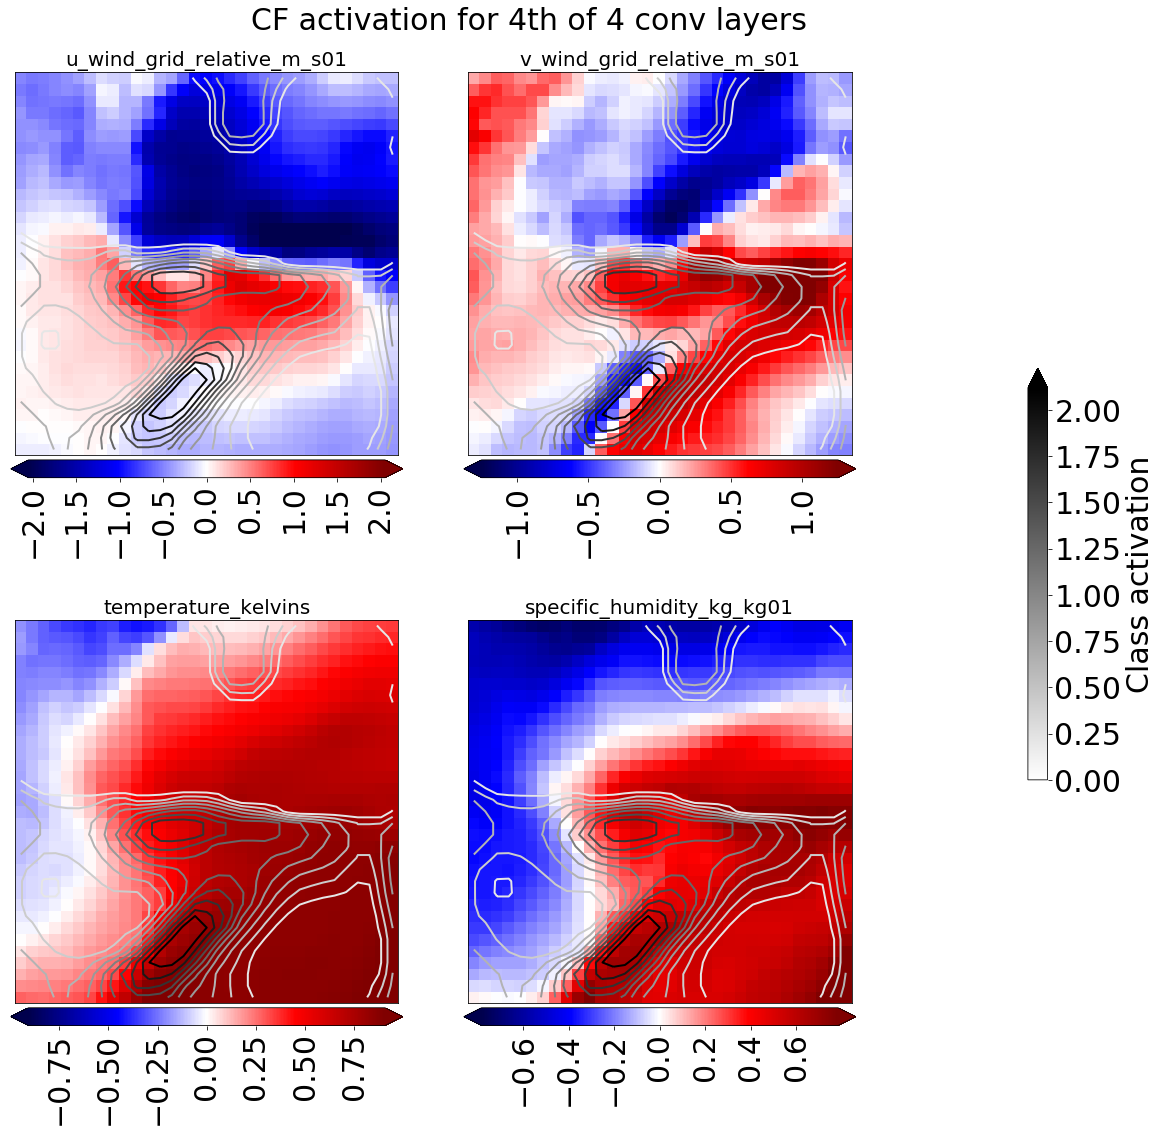

In [94]:
num_half_rows, num_half_columns = model_to_grid_dimensions(
    best_model_object)

print('Reading data from: "{0:s}"...'.format(testing_file_names[0]))
example_dict = read_examples(
    netcdf_file_name=testing_file_names[0],
    predictor_names_to_keep=PREDICTOR_NAMES_FOR_CNN,
    pressure_levels_to_keep_mb=PRESSURE_LEVELS_FOR_CNN_MB,
    num_half_rows_to_keep=num_half_rows,
    num_half_columns_to_keep=num_half_columns)

example_index = numpy.where(
    example_dict[TARGET_MATRIX_KEY][:, WARM_FRONT_ENUM] == 1
)[0][0]
predictor_matrix = example_dict[PREDICTOR_MATRIX_KEY][example_index, ...]

conv_layer_names = [
    l.name for l in best_model_object.layers
    if 'batch_normalization' in l.name
]

conv_layer_names = conv_layer_names[:4]
num_conv_layers = len(conv_layer_names)

for i in [0, 3]:
    class_activation_matrix = run_gradcam(
        model_object=best_model_object,
        predictor_matrix=numpy.expand_dims(predictor_matrix, axis=0),
        target_class=COLD_FRONT_ENUM, target_layer_name=conv_layer_names[i]
    )

    class_activation_matrix = apply_median_filter(
        input_matrix_2d=class_activation_matrix, num_cells_in_half_window=1)

    class_activation_matrix = numpy.maximum(class_activation_matrix, 0.)

    figure_object, _ = plot_class_activn_one_example(
        predictor_matrix=predictor_matrix[..., :4],
        class_activation_matrix=class_activation_matrix,
        predictor_names=PREDICTOR_NAMES_FOR_CNN[:4]
    )

    title_string = (
        'CF activation for {0:d}th of {1:d} conv layers'
    ).format(i + 1, num_conv_layers)

    figure_object.suptitle(title_string, y=1.01)

# CAM example 3

Now we compute CF activation for a CF example.  In other words, which grid cells support a (correct) CF conclusion?

Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/testing/downsized_3d_examples_2015120109-2015120109.nc"...


/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:251: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not numpy.issubdtype(input_variable.dtype, int):
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:340: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not (numpy.issubdtype(input_variable.dtype, int) or numpy.issubdtype(
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:341: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated.

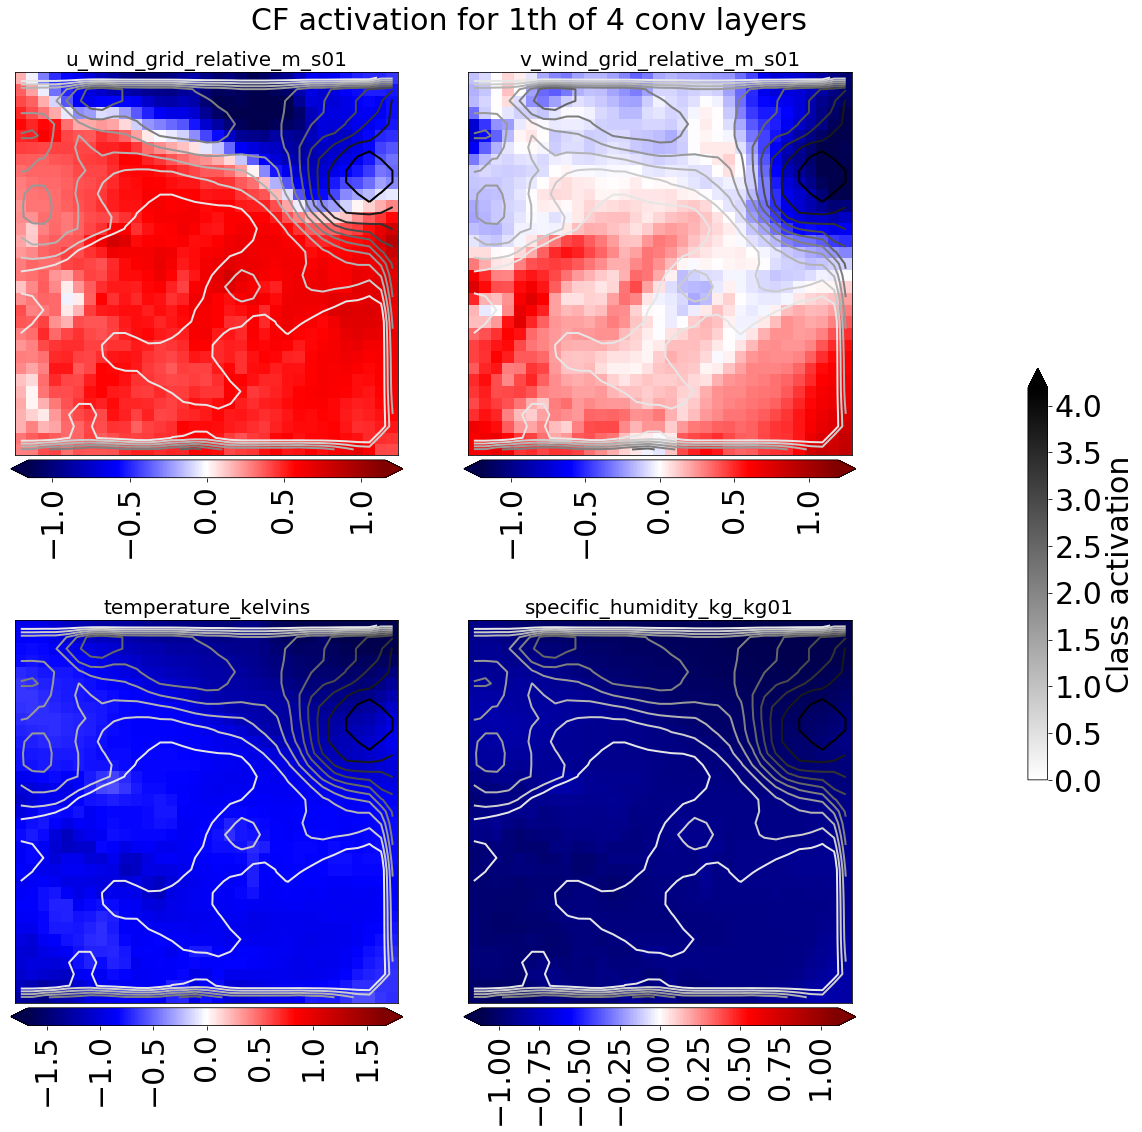

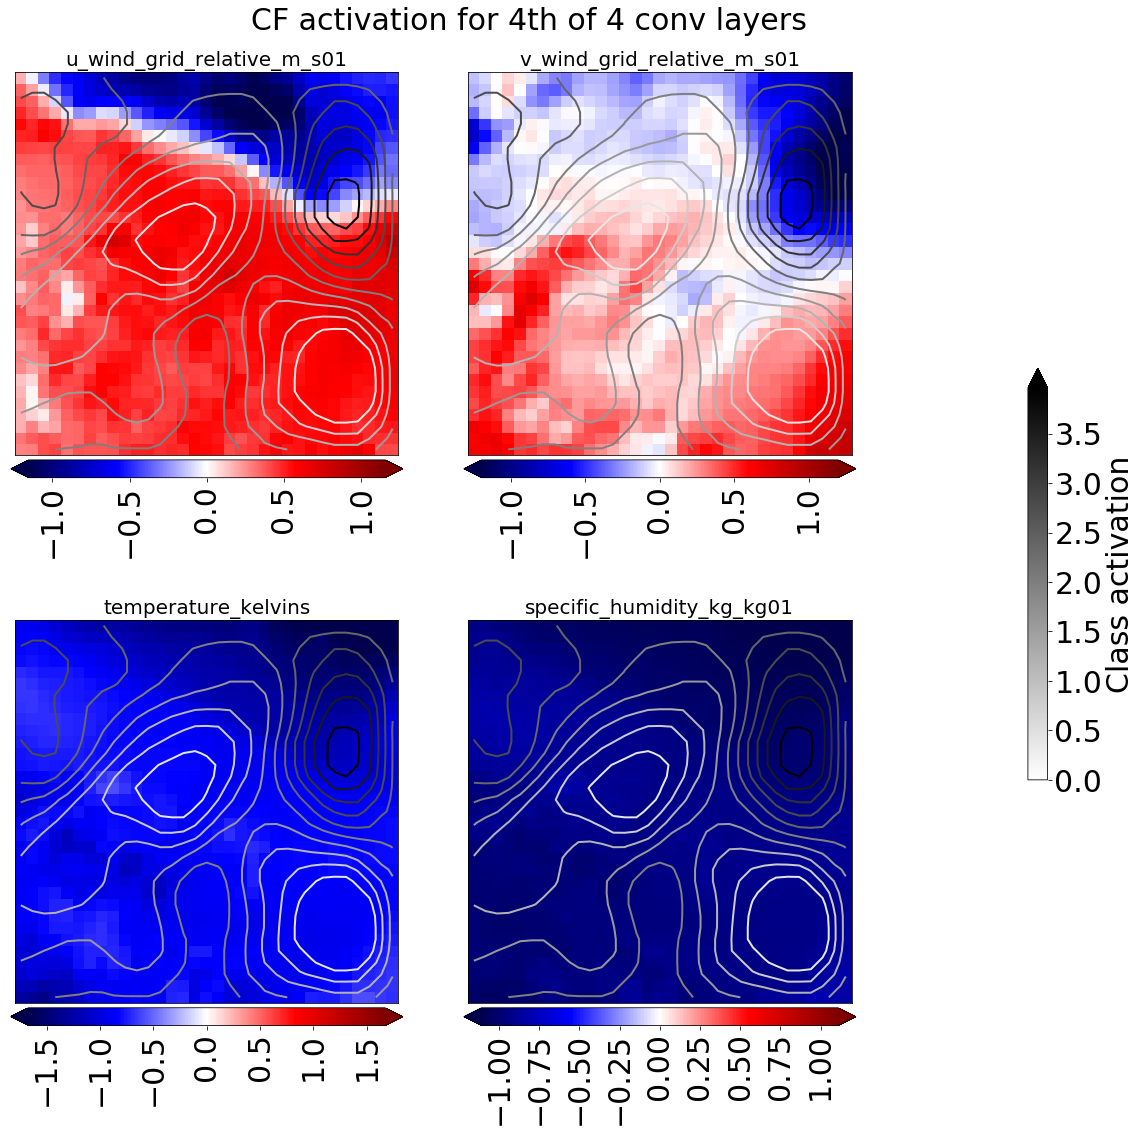

In [95]:
num_half_rows, num_half_columns = model_to_grid_dimensions(
    best_model_object)

print('Reading data from: "{0:s}"...'.format(testing_file_names[0]))
example_dict = read_examples(
    netcdf_file_name=testing_file_names[0],
    predictor_names_to_keep=PREDICTOR_NAMES_FOR_CNN,
    pressure_levels_to_keep_mb=PRESSURE_LEVELS_FOR_CNN_MB,
    num_half_rows_to_keep=num_half_rows,
    num_half_columns_to_keep=num_half_columns)

example_index = numpy.where(
    example_dict[TARGET_MATRIX_KEY][:, COLD_FRONT_ENUM] == 1
)[0][0]
predictor_matrix = example_dict[PREDICTOR_MATRIX_KEY][example_index, ...]

conv_layer_names = [
    l.name for l in best_model_object.layers
    if 'batch_normalization' in l.name
]

conv_layer_names = conv_layer_names[:4]
num_conv_layers = len(conv_layer_names)

for i in [0, 3]:
    class_activation_matrix = run_gradcam(
        model_object=best_model_object,
        predictor_matrix=numpy.expand_dims(predictor_matrix, axis=0),
        target_class=COLD_FRONT_ENUM, target_layer_name=conv_layer_names[i]
    )

    class_activation_matrix = apply_median_filter(
        input_matrix_2d=class_activation_matrix, num_cells_in_half_window=1)

    class_activation_matrix = numpy.maximum(class_activation_matrix, 0.)

    figure_object, _ = plot_class_activn_one_example(
        predictor_matrix=predictor_matrix[..., :4],
        class_activation_matrix=class_activation_matrix,
        predictor_names=PREDICTOR_NAMES_FOR_CNN[:4]
    )

    title_string = (
        'CF activation for {0:d}th of {1:d} conv layers'
    ).format(i + 1, num_conv_layers)

    figure_object.suptitle(title_string, y=1.01)

# CAM example 4

Now we compute WF activation for the same CF example.  In other words, which grid cells support a (wrong) WF conclusion?

Reading data from: "/localdata/ryan.lagerquist/aiml_symposium/data/testing/downsized_3d_examples_2015120109-2015120109.nc"...


/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:251: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not numpy.issubdtype(input_variable.dtype, int):
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:340: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not (numpy.issubdtype(input_variable.dtype, int) or numpy.issubdtype(
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/GewitterGefahr-0.1-py3.6.egg/gewittergefahr/gg_utils/error_checking.py:341: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated.

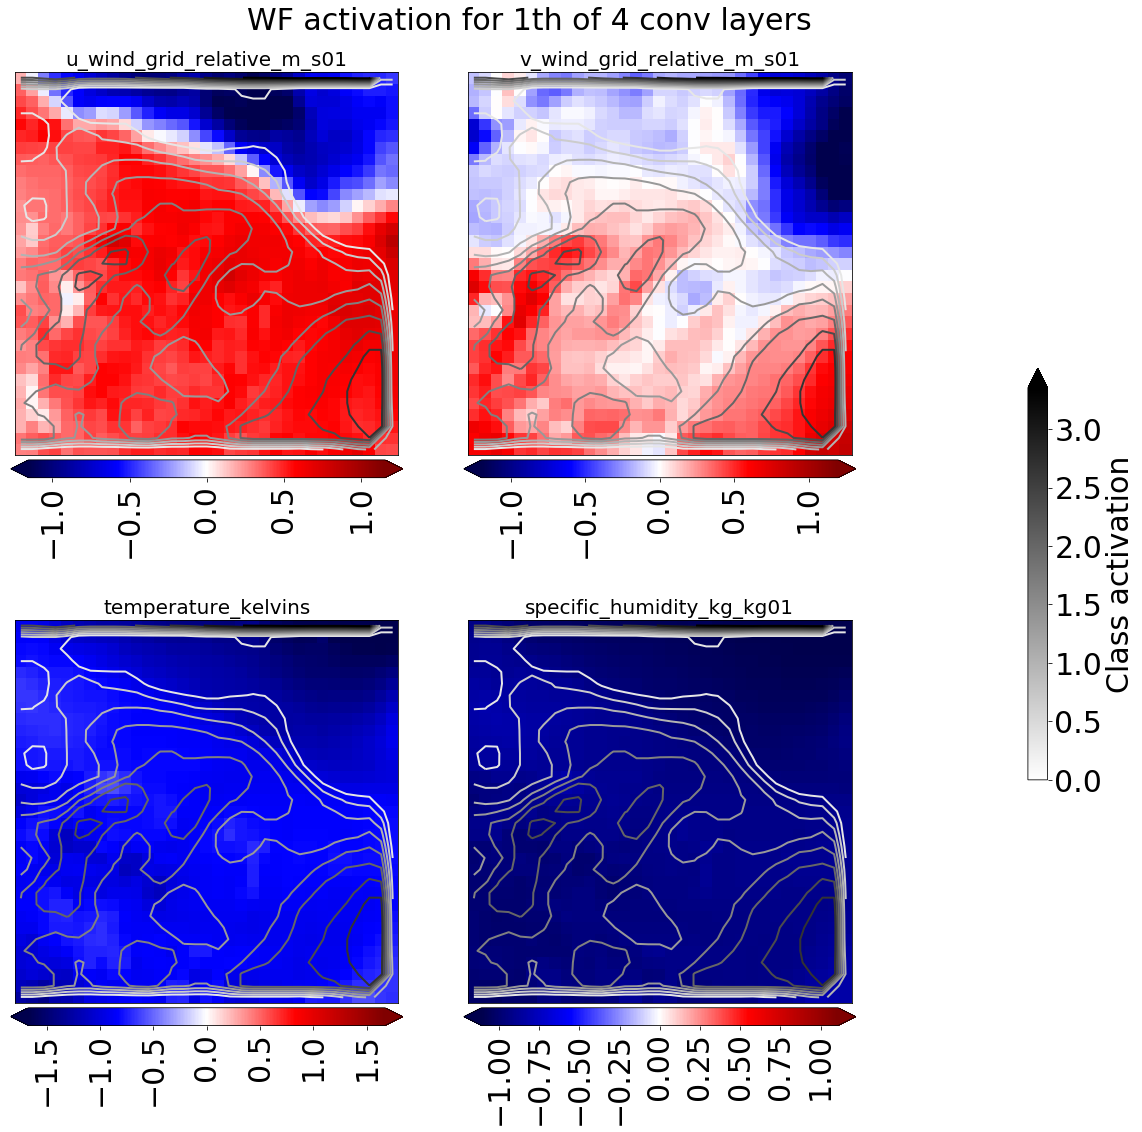

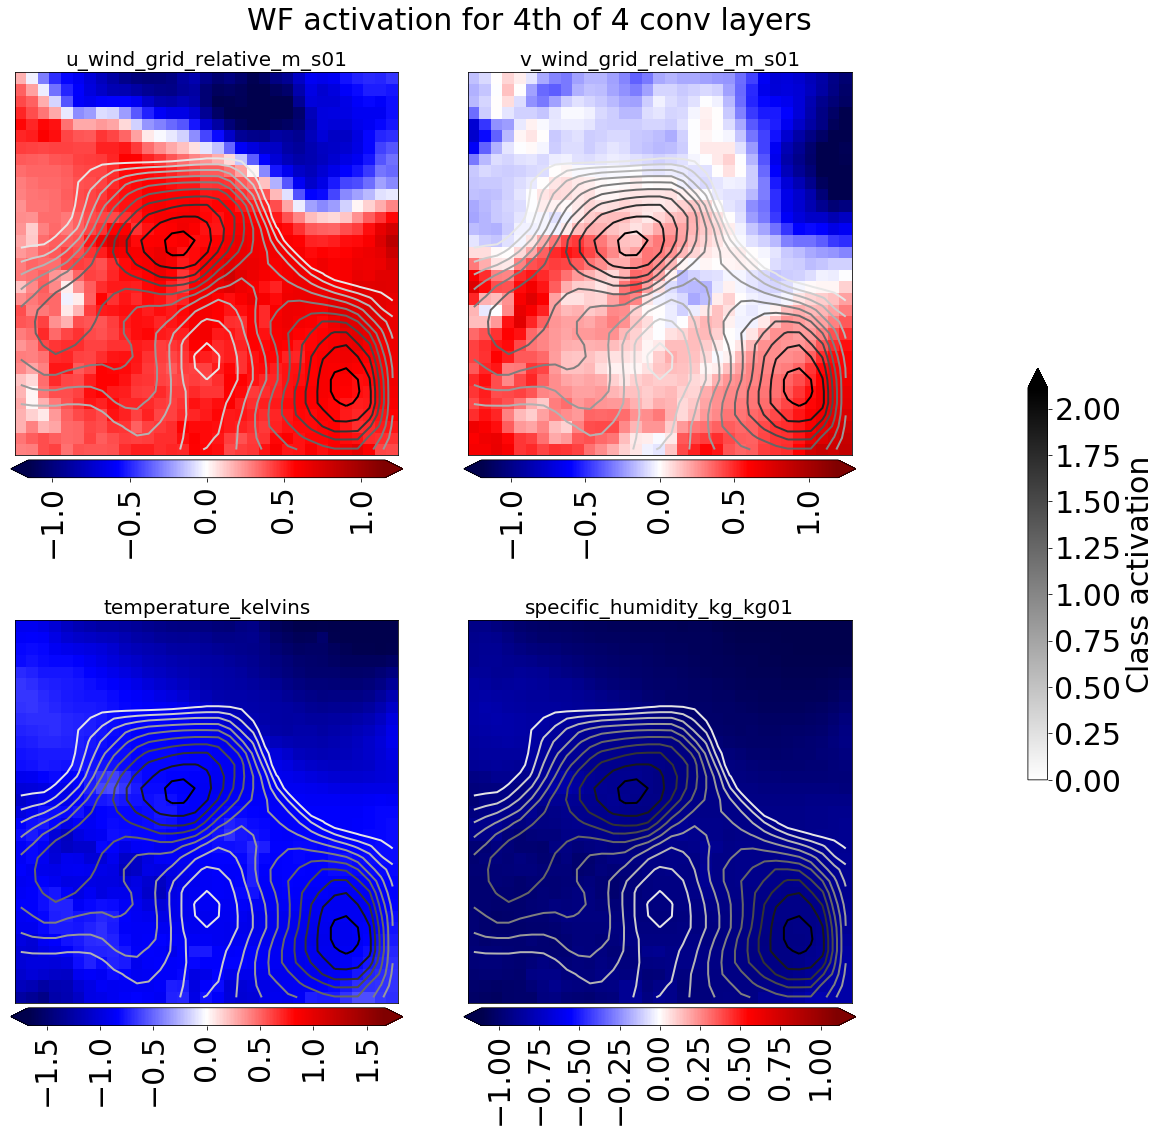

In [96]:
num_half_rows, num_half_columns = model_to_grid_dimensions(
    best_model_object)

print('Reading data from: "{0:s}"...'.format(testing_file_names[0]))
example_dict = read_examples(
    netcdf_file_name=testing_file_names[0],
    predictor_names_to_keep=PREDICTOR_NAMES_FOR_CNN,
    pressure_levels_to_keep_mb=PRESSURE_LEVELS_FOR_CNN_MB,
    num_half_rows_to_keep=num_half_rows,
    num_half_columns_to_keep=num_half_columns)

example_index = numpy.where(
    example_dict[TARGET_MATRIX_KEY][:, COLD_FRONT_ENUM] == 1
)[0][0]
predictor_matrix = example_dict[PREDICTOR_MATRIX_KEY][example_index, ...]

conv_layer_names = [
    l.name for l in best_model_object.layers
    if 'batch_normalization' in l.name
]

conv_layer_names = conv_layer_names[:4]
num_conv_layers = len(conv_layer_names)

for i in [0, 3]:
    class_activation_matrix = run_gradcam(
        model_object=best_model_object,
        predictor_matrix=numpy.expand_dims(predictor_matrix, axis=0),
        target_class=WARM_FRONT_ENUM, target_layer_name=conv_layer_names[i]
    )

    class_activation_matrix = apply_median_filter(
        input_matrix_2d=class_activation_matrix, num_cells_in_half_window=1)

    class_activation_matrix = numpy.maximum(class_activation_matrix, 0.)

    figure_object, _ = plot_class_activn_one_example(
        predictor_matrix=predictor_matrix[..., :4],
        class_activation_matrix=class_activation_matrix,
        predictor_names=PREDICTOR_NAMES_FOR_CNN[:4]
    )

    title_string = (
        'WF activation for {0:d}th of {1:d} conv layers'
    ).format(i + 1, num_conv_layers)

    figure_object.suptitle(title_string, y=1.01)